In [1]:
import numpy as np
import  matplotlib.pyplot as plt
from tensorflow import random
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import  mean_squared_error
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import shap
#from imblearn.over_sampling import ADASYN
import h5py
import joblib
from imblearn.over_sampling import ADASYN,SMOTE

###### Read the data and see how the data labels are distributed

In [100]:
df = pd.read_excel('data_imputed.xlsx')
from collections import Counter
def print_label_dist(label_col):
    c = Counter(label_col)
    print(f'label is {c}')
print_label_dist(df['CINV'])

label is Counter({0: 1567, 1: 184})


In [101]:
for val in df.columns:
    if np.std(df[val],ddof=1) > 100:
        eps=0.001
        df[val] = np.log(df.pop(val)+eps)

In [102]:
scaler = MinMaxScaler(feature_range=(0,1))
for val in df.columns.drop('CINV'):
    df[val] = scaler.fit_transform(np.reshape(np.array(df[val]),(-1,1)))

###### deepforest

In [103]:
from deepforest import CascadeForestRegressor,CascadeForestClassifier

In [104]:
def deep_forest(train,test):
    model_deepforest = CascadeForestRegressor(max_layers=6, n_estimators=5, max_depth=None, min_samples_split=6, min_samples_leaf=5, use_predictor=False, predictor='forest', delta=7.589301234258733e-05,random_state=1)
    #model_deepforest = CascadeForestRegressor(max_layers=13,n_estimators=3)
    #train , test = train_test_split(df,random_state=42,test_size = 0.2)
    #train['CINV'].replace(0,0.01)
    #train['CINV'].replace(1,0.99)
    x_train_deepforest , y_train_deepforest = train.drop('CINV',axis = 1),train['CINV']
    x_test_deepforest , y_test_deepforest = test.drop('CINV',axis = 1),test['CINV']
    #from sklearn.preprocessing import StandardScaler
    #sc_X = StandardScaler()
    #x_train_deepforest = sc_X.fit_transform(x_train_deepforest)
    #x_test_deepforest = sc_X.fit_transform(x_test_deepforest)
    print_label_dist(y_train_deepforest)
    #oversample = SMOTE(random_state = 42,sampling_strategy = {1:276})
    #x_train_deepforest,y_train_deepforest = oversample.fit_resample(x_train_deepforest,y_train_deepforest)
    y_train_deepforest = y_train_deepforest.replace({1:0.99,0:0.01})
    model_deepforest.fit(x_train_deepforest, y_train_deepforest)    
    preds_deepforest = model_deepforest.predict(x_test_deepforest)
    p = get_p(y_test_deepforest, preds_deepforest)
    print('Optimal threshold:',p)
    pred_y_thr = []
    for i in range(len(y_test_deepforest)):
        if  preds_deepforest[i] > p: #The prediction probability value is converted to the prediction label
            pred_y_thr.append(1)
        else:
            pred_y_thr.append(0)
    plot_cm(y_test_deepforest, pred_y_thr)
    print(confusion_matrix(y_test_deepforest, pred_y_thr))
    
   # print(y_test_deepforest)
    #print(preds_deepforest)
    auc_deepforest = roc_auc_score(y_test_deepforest,preds_deepforest)
    return auc_deepforest,model_deepforest,x_train_deepforest,x_test_deepforest,y_train_deepforest,y_test_deepforest

label is Counter({0: 1255, 1: 145})
[2023-03-04 13:46:37.850] Start to fit the model:
[2023-03-04 13:46:37.850] Fitting cascade layer = 0 
[2023-03-04 13:46:39.045] layer = 0  | Val MSE = 0.07808 | Elapsed = 1.195 s
[2023-03-04 13:46:39.045] Fitting cascade layer = 1 
[2023-03-04 13:46:40.482] layer = 1  | Val MSE = 0.07640 | Elapsed = 1.437 s
[2023-03-04 13:46:40.482] Fitting cascade layer = 2 
[2023-03-04 13:46:41.920] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.438 s
[2023-03-04 13:46:41.920] Early stopping counter: 1 out of 2
[2023-03-04 13:46:41.936] Fitting cascade layer = 3 
[2023-03-04 13:46:43.365] layer = 3  | Val MSE = 0.07733 | Elapsed = 1.429 s
[2023-03-04 13:46:43.365] Early stopping counter: 2 out of 2
[2023-03-04 13:46:43.365] Handling early stopping
[2023-03-04 13:46:43.365] The optimal number of layers: 2
[2023-03-04 13:46:43.365] Start to evalute the model:
[2023-03-04 13:46:43.365] Evaluating cascade layer = 0 
[2023-03-04 13:46:43.427] Evaluating cascade layer = 1

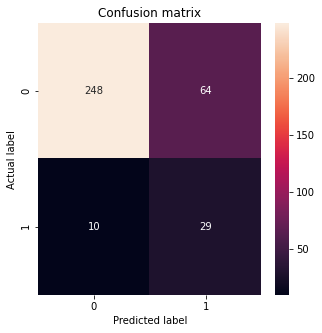

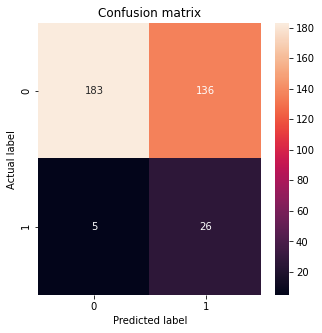

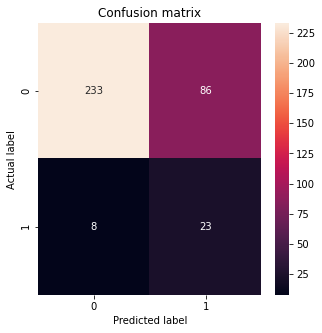

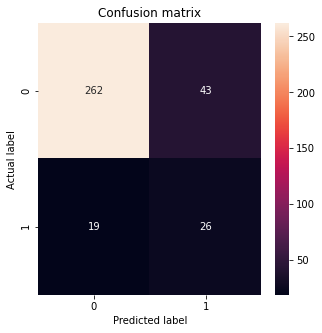

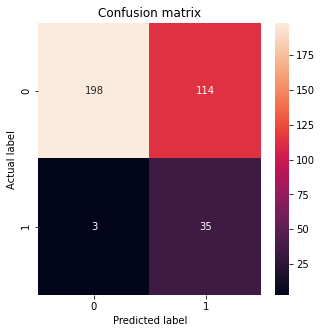

In [19]:
kf=KFold(n_splits=5,shuffle=True)
auc_t = 0
bestauccb = 0.5
for train_index, test_index in kf.split(df):
    #print('train_index', train_index, 'test_index', test_index)
    #train index and test index are subscripts
    train = df.iloc[train_index,:]
    test = df.iloc[test_index,:]
    auc_deepforest1,model_deepforest1,x_train_deepforest1,x_test_deepforest1,preds_deepforest1,y_test_deepforest1 = deep_forest(train,test)
    if auc_deepforest1 > bestauccb:
        bestauccb = auc_deepforest1
        print('save model')
        joblib.dump(filename='best_deepforest_model_delectshape0.1.h5',value=model_deepforest1) 
        best_trainx1_deepforest,best_testx1_deepforest,best_predy1_deepforest ,best_testy1_deepforest = x_train_deepforest1,x_test_deepforest1,preds_deepforest1,y_test_deepforest1
    print(auc_deepforest1)
    auc_t = auc_t + auc_deepforest1
print('AUC_ave:',auc_t/5)

In [130]:
best_trainy1_deepforest = best_trainy1_deepforest.replace({0.99:1,0.01:0})

In [131]:
best_testx1_deepforest.to_excel('deepforest_best_test_x10.1.xlsx',index = False)
best_trainx1_deepforest.to_excel('deepforest_best_train_x10.1.xlsx',index = False)
best_testy1_deepforest.to_excel('deepforest_best_test_y10.1.xlsx',index = False)
best_trainy1_deepforest.to_excel('deepforest_best_train_y10.1.xlsx',index = False)

In [30]:
# reading data
testx = pd.read_excel('deepforest_best_test_x1NOSMOTE.xlsx')
testy = pd.read_excel('deepforest_best_test_y1NOSMOTE.xlsx')

In [31]:
from tensorflow.keras.models import load_model  
model_keras = joblib.load(filename="best_deepforest_model_NOSMOTE.3.h5")
predy = model_keras.predict(testx)[:,0]

[2023-03-03 02:34:41.216] Start to evalute the model:
[2023-03-03 02:34:41.216] Evaluating cascade layer = 0 
[2023-03-03 02:34:41.285] Evaluating cascade layer = 1 


In [181]:
#Hyperparameter selection
from deepforest import CascadeForestRegressor,CascadeForestClassifier
def objective(trial):
    df = pd.read_excel('data_imputed.xlsx')
    data = df.drop('CINV',axis = 1)
    target = df['CINV']
    X_train, X_test, y_train, y_test=train_test_split(data, target, test_size=0.2, random_state=42)# Data set partitioning
    y_train = y_train.replace({1:0.99,0:0.01})
    print('Missing value number:',y_train.isnull().sum())
    param = {
    'max_layers':trial.suggest_int('max_layers', 3, 15), 
    'n_estimators':trial.suggest_int('n_estimators', 1, 10), 
    #'n_trees':trial.suggest_int('n_trees', 20, 100), 
    'min_samples_split':trial.suggest_int('min_samples_split', 2, 9), 
    'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1, 9), 
    'predictor':'forest', 
    'delta':trial.suggest_loguniform('delta', 1e-06, 1e-03),
    'random_state':1}
    
    cat=CascadeForestRegressor(**param)
    cat.fit(X_train, y_train)
    pred_lgb=cat.predict(X_test)
    auc =roc_auc_score(y_test, pred_lgb)
    return auc

In [182]:
import optuna
study=optuna.create_study(direction='maximize')
n_trials=200
study.optimize(objective, n_trials=n_trials)

[I 2023-02-27 22:58:54,871] A new study created in memory with name: no-name-6dbb5a5c-90e3-4c66-94e0-09903dae748e


缺失值数量: 0
[2023-02-27 14:58:55.426] Start to fit the model:
[2023-02-27 14:58:55.426] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:58:55.677] layer = 0  | Val MSE = 0.07957 | Elapsed = 0.251 s
[2023-02-27 14:58:55.677] Fitting cascade layer = 1 
[2023-02-27 14:58:55.944] layer = 1  | Val MSE = 0.07780 | Elapsed = 0.267 s
[2023-02-27 14:58:55.945] Fitting cascade layer = 2 
[2023-02-27 14:58:56.207] layer = 2  | Val MSE = 0.07878 | Elapsed = 0.262 s
[2023-02-27 14:58:56.207] Early stopping counter: 1 out of 2
[2023-02-27 14:58:56.208] Fitting cascade layer = 3 


[I 2023-02-27 22:58:56,502] Trial 0 finished with value: 0.782215647600263 and parameters: {'max_layers': 14, 'n_estimators': 1, 'min_samples_split': 5, 'min_samples_leaf': 9, 'delta': 6.864194373147499e-05}. Best is trial 0 with value: 0.782215647600263.


[2023-02-27 14:58:56.460] layer = 3  | Val MSE = 0.07873 | Elapsed = 0.252 s
[2023-02-27 14:58:56.460] Early stopping counter: 2 out of 2
[2023-02-27 14:58:56.460] Handling early stopping
[2023-02-27 14:58:56.460] The optimal number of layers: 2
[2023-02-27 14:58:56.460] Start to evalute the model:
[2023-02-27 14:58:56.460] Evaluating cascade layer = 0 
[2023-02-27 14:58:56.476] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 14:58:57.036] Start to fit the model:
[2023-02-27 14:58:57.036] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:58:58.592] layer = 0  | Val MSE = 0.07879 | Elapsed = 1.556 s
[2023-02-27 14:58:58.597] Fitting cascade layer = 1 
[2023-02-27 14:59:00.351] layer = 1  | Val MSE = 0.07755 | Elapsed = 1.753 s
[2023-02-27 14:59:00.351] Fitting cascade layer = 2 
[2023-02-27 14:59:02.238] layer = 2  | Val MSE = 0.07877 | Elapsed = 1.887 s
[2023-02-27 14:59:02.238] Early stopping counter: 1 out of 2
[2023-02-27 14:59:02.246] Fitting cascade layer = 3 
[2023-02-27 14:59:04.150] layer = 3  | Val MSE = 0.07703 | Elapsed = 1.904 s
[2023-02-27 14:59:04.156] Fitting cascade layer = 4 
[2023-02-27 14:59:05.972] layer = 4  | Val MSE = 0.07802 | Elapsed = 1.816 s
[2023-02-27 14:59:05.972] Early stopping counter: 1 out of 2
[2023-02-27 14:59:05.972] Fitting cascade layer = 5 
[2023-02-27 14:59:07.708] layer = 5  | Val MSE = 0.07825 | Elapsed = 1.736 s
[2023-02-27 14:59:07.708] Early stopping counter: 2 out of 2
[2023-02-27 14:59:07.708] Handling early stopping
[2023-02-27 14:59:07.709] The optimal nu

[I 2023-02-27 22:59:08,056] Trial 1 finished with value: 0.7656969099276791 and parameters: {'max_layers': 12, 'n_estimators': 6, 'min_samples_split': 5, 'min_samples_leaf': 9, 'delta': 0.0001518028026166726}. Best is trial 0 with value: 0.782215647600263.


[2023-02-27 14:59:07.962] Evaluating cascade layer = 3 
缺失值数量: 0
[2023-02-27 14:59:08.587] Start to fit the model:
[2023-02-27 14:59:08.588] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:59:09.217] layer = 0  | Val MSE = 0.07608 | Elapsed = 0.629 s
[2023-02-27 14:59:09.219] Fitting cascade layer = 1 
[2023-02-27 14:59:09.847] layer = 1  | Val MSE = 0.07762 | Elapsed = 0.628 s
[2023-02-27 14:59:09.847] Early stopping counter: 1 out of 2
[2023-02-27 14:59:09.847] Fitting cascade layer = 2 


[I 2023-02-27 22:59:10,490] Trial 2 finished with value: 0.784845496383958 and parameters: {'max_layers': 15, 'n_estimators': 2, 'min_samples_split': 2, 'min_samples_leaf': 1, 'delta': 1.7596771336872075e-05}. Best is trial 2 with value: 0.784845496383958.


[2023-02-27 14:59:10.444] layer = 2  | Val MSE = 0.07660 | Elapsed = 0.596 s
[2023-02-27 14:59:10.444] Early stopping counter: 2 out of 2
[2023-02-27 14:59:10.444] Handling early stopping
[2023-02-27 14:59:10.444] The optimal number of layers: 1
[2023-02-27 14:59:10.444] Start to evalute the model:
[2023-02-27 14:59:10.444] Evaluating cascade layer = 0 
缺失值数量: 0
[2023-02-27 14:59:11.107] Start to fit the model:
[2023-02-27 14:59:11.107] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:59:12.463] layer = 0  | Val MSE = 0.07821 | Elapsed = 1.357 s
[2023-02-27 14:59:12.467] Fitting cascade layer = 1 
[2023-02-27 14:59:13.955] layer = 1  | Val MSE = 0.07649 | Elapsed = 1.488 s
[2023-02-27 14:59:13.955] Fitting cascade layer = 2 
[2023-02-27 14:59:15.524] layer = 2  | Val MSE = 0.07782 | Elapsed = 1.569 s
[2023-02-27 14:59:15.524] Early stopping counter: 1 out of 2
[2023-02-27 14:59:15.524] Reaching the maximum number of layers: 3
[2023-02-27 14:59:15.526] Start to evalute the model:
[2023-02-27 14:59:15.526] Evaluating cascade layer = 0 
[2023-02-27 14:59:15.609] Evaluating cascade layer = 1 
[2023-02-27 14:59:15.695] Evaluating cascade layer = 2 


[I 2023-02-27 22:59:15,822] Trial 3 finished with value: 0.7906804733727811 and parameters: {'max_layers': 3, 'n_estimators': 5, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 2.234586496830974e-05}. Best is trial 3 with value: 0.7906804733727811.


缺失值数量: 0
[2023-02-27 14:59:16.416] Start to fit the model:
[2023-02-27 14:59:16.416] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:59:17.582] layer = 0  | Val MSE = 0.07682 | Elapsed = 1.166 s
[2023-02-27 14:59:17.598] Fitting cascade layer = 1 
[2023-02-27 14:59:18.957] layer = 1  | Val MSE = 0.07581 | Elapsed = 1.359 s
[2023-02-27 14:59:18.957] Fitting cascade layer = 2 
[2023-02-27 14:59:20.378] layer = 2  | Val MSE = 0.07733 | Elapsed = 1.422 s
[2023-02-27 14:59:20.378] Early stopping counter: 1 out of 2
[2023-02-27 14:59:20.378] Fitting cascade layer = 3 


[I 2023-02-27 22:59:21,838] Trial 4 finished with value: 0.7814760026298487 and parameters: {'max_layers': 12, 'n_estimators': 4, 'min_samples_split': 9, 'min_samples_leaf': 2, 'delta': 3.7768157807025736e-05}. Best is trial 3 with value: 0.7906804733727811.


[2023-02-27 14:59:21.713] layer = 3  | Val MSE = 0.07775 | Elapsed = 1.334 s
[2023-02-27 14:59:21.713] Early stopping counter: 2 out of 2
[2023-02-27 14:59:21.713] Handling early stopping
[2023-02-27 14:59:21.713] The optimal number of layers: 2
[2023-02-27 14:59:21.713] Start to evalute the model:
[2023-02-27 14:59:21.713] Evaluating cascade layer = 0 
[2023-02-27 14:59:21.775] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 14:59:22.384] Start to fit the model:
[2023-02-27 14:59:22.384] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:59:24.843] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.458 s
[2023-02-27 14:59:24.843] Fitting cascade layer = 1 
[2023-02-27 14:59:27.873] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.031 s
[2023-02-27 14:59:27.889] Fitting cascade layer = 2 
[2023-02-27 14:59:31.456] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.567 s
[2023-02-27 14:59:31.456] Early stopping counter: 1 out of 2
[2023-02-27 14:59:31.471] Fitting cascade layer = 3 
[2023-02-27 14:59:34.697] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.226 s
[2023-02-27 14:59:34.697] Early stopping counter: 2 out of 2
[2023-02-27 14:59:34.697] Handling early stopping
[2023-02-27 14:59:34.697] The optimal number of layers: 2
[2023-02-27 14:59:34.697] Start to evalute the model:
[2023-02-27 14:59:34.697] Evaluating cascade layer = 0 
[2023-02-27 14:59:34.822] Evaluating cascade layer = 1 


[I 2023-02-27 22:59:34,963] Trial 5 finished with value: 0.798405654174885 and parameters: {'max_layers': 7, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0002638524812538074}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 14:59:35.498] Start to fit the model:
[2023-02-27 14:59:35.498] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:59:37.644] layer = 0  | Val MSE = 0.07875 | Elapsed = 2.145 s
[2023-02-27 14:59:37.644] Fitting cascade layer = 1 
[2023-02-27 14:59:40.307] layer = 1  | Val MSE = 0.07745 | Elapsed = 2.664 s
[2023-02-27 14:59:40.323] Fitting cascade layer = 2 
[2023-02-27 14:59:42.897] layer = 2  | Val MSE = 0.07754 | Elapsed = 2.574 s
[2023-02-27 14:59:42.897] Early stopping counter: 1 out of 2
[2023-02-27 14:59:42.897] Fitting cascade layer = 3 
[2023-02-27 14:59:45.428] layer = 3  | Val MSE = 0.07740 | Elapsed = 2.531 s
[2023-02-27 14:59:45.428] Early stopping counter: 2 out of 2
[2023-02-27 14:59:45.428] Handling early stopping
[2023-02-27 14:59:45.428] The optimal number of layers: 2
[2023-02-27 14:59:45.444] Start to evalute the model:
[2023-02-27 14:59:45.444] Evaluating cascade layer = 0 
[2023-02-27 14:59:45.553] Evaluating cascade layer = 1 


[I 2023-02-27 22:59:45,662] Trial 6 finished with value: 0.7938034188034189 and parameters: {'max_layers': 14, 'n_estimators': 8, 'min_samples_split': 6, 'min_samples_leaf': 9, 'delta': 0.0004901611054254306}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 14:59:46.178] Start to fit the model:
[2023-02-27 14:59:46.178] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 14:59:48.676] layer = 0  | Val MSE = 0.07675 | Elapsed = 2.498 s
[2023-02-27 14:59:48.691] Fitting cascade layer = 1 
[2023-02-27 14:59:51.966] layer = 1  | Val MSE = 0.07529 | Elapsed = 3.275 s
[2023-02-27 14:59:51.966] Fitting cascade layer = 2 
[2023-02-27 14:59:55.240] layer = 2  | Val MSE = 0.07609 | Elapsed = 3.274 s
[2023-02-27 14:59:55.240] Early stopping counter: 1 out of 2
[2023-02-27 14:59:55.256] Fitting cascade layer = 3 
[2023-02-27 14:59:58.516] layer = 3  | Val MSE = 0.07600 | Elapsed = 3.261 s
[2023-02-27 14:59:58.516] Early stopping counter: 2 out of 2
[2023-02-27 14:59:58.516] Handling early stopping
[2023-02-27 14:59:58.519] The optimal number of layers: 2
[2023-02-27 14:59:58.523] Start to evalute the model:
[2023-02-27 14:59:58.523] Evaluating cascade layer = 0 
[2023-02-27 14:59:58.657] Evaluating cascade layer = 1 


[I 2023-02-27 22:59:58,798] Trial 7 finished with value: 0.7932281393819854 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 9, 'min_samples_leaf': 3, 'delta': 1.0683264737058443e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 14:59:59.499] Start to fit the model:
[2023-02-27 14:59:59.499] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:00:00.591] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.092 s
[2023-02-27 15:00:00.591] Fitting cascade layer = 1 
[2023-02-27 15:00:01.778] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.187 s
[2023-02-27 15:00:01.794] Fitting cascade layer = 2 
[2023-02-27 15:00:02.997] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.203 s
[2023-02-27 15:00:02.997] Early stopping counter: 1 out of 2
[2023-02-27 15:00:02.997] Fitting cascade layer = 3 


[I 2023-02-27 23:00:04,340] Trial 8 finished with value: 0.7965976331360947 and parameters: {'max_layers': 12, 'n_estimators': 4, 'min_samples_split': 3, 'min_samples_leaf': 5, 'delta': 4.870743414927636e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:00:04.231] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.234 s
[2023-02-27 15:00:04.231] Early stopping counter: 2 out of 2
[2023-02-27 15:00:04.231] Handling early stopping
[2023-02-27 15:00:04.231] The optimal number of layers: 2
[2023-02-27 15:00:04.231] Start to evalute the model:
[2023-02-27 15:00:04.231] Evaluating cascade layer = 0 
[2023-02-27 15:00:04.293] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:00:04.856] Start to fit the model:
[2023-02-27 15:00:04.856] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:00:05.369] layer = 0  | Val MSE = 0.07891 | Elapsed = 0.514 s
[2023-02-27 15:00:05.369] Fitting cascade layer = 1 
[2023-02-27 15:00:05.920] layer = 1  | Val MSE = 0.07789 | Elapsed = 0.551 s
[2023-02-27 15:00:05.926] Fitting cascade layer = 2 
[2023-02-27 15:00:06.463] layer = 2  | Val MSE = 0.07824 | Elapsed = 0.536 s
[2023-02-27 15:00:06.463] Early stopping counter: 1 out of 2
[2023-02-27 15:00:06.463] Fitting cascade layer = 3 


[I 2023-02-27 23:00:07,083] Trial 9 finished with value: 0.7904339250493096 and parameters: {'max_layers': 14, 'n_estimators': 2, 'min_samples_split': 3, 'min_samples_leaf': 8, 'delta': 0.00044666010053131215}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:00:07.004] layer = 3  | Val MSE = 0.07876 | Elapsed = 0.542 s
[2023-02-27 15:00:07.004] Early stopping counter: 2 out of 2
[2023-02-27 15:00:07.004] Handling early stopping
[2023-02-27 15:00:07.020] The optimal number of layers: 2
[2023-02-27 15:00:07.020] Start to evalute the model:
[2023-02-27 15:00:07.020] Evaluating cascade layer = 0 
[2023-02-27 15:00:07.051] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:00:07.661] Start to fit the model:
[2023-02-27 15:00:07.661] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:00:10.569] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.908 s
[2023-02-27 15:00:10.584] Fitting cascade layer = 1 
[2023-02-27 15:00:14.182] layer = 1  | Val MSE = 0.07623 | Elapsed = 3.597 s
[2023-02-27 15:00:14.197] Fitting cascade layer = 2 
[2023-02-27 15:00:17.749] layer = 2  | Val MSE = 0.07648 | Elapsed = 3.552 s
[2023-02-27 15:00:17.749] Early stopping counter: 1 out of 2
[2023-02-27 15:00:17.765] Fitting cascade layer = 3 
[2023-02-27 15:00:21.233] layer = 3  | Val MSE = 0.07717 | Elapsed = 3.468 s
[2023-02-27 15:00:21.233] Early stopping counter: 2 out of 2
[2023-02-27 15:00:21.233] Handling early stopping
[2023-02-27 15:00:21.249] The optimal number of layers: 2
[2023-02-27 15:00:21.249] Start to evalute the model:
[2023-02-27 15:00:21.249] Evaluating cascade layer = 0 
[2023-02-27 15:00:21.389] Evaluating cascade layer = 1 


[I 2023-02-27 23:00:21,545] Trial 10 finished with value: 0.7962689020381327 and parameters: {'max_layers': 8, 'n_estimators': 10, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 1.35468601757882e-06}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:00:22.092] Start to fit the model:
[2023-02-27 15:00:22.092] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:00:23.952] layer = 0  | Val MSE = 0.07767 | Elapsed = 1.860 s
[2023-02-27 15:00:23.968] Fitting cascade layer = 1 
[2023-02-27 15:00:26.626] layer = 1  | Val MSE = 0.07641 | Elapsed = 2.658 s
[2023-02-27 15:00:26.642] Fitting cascade layer = 2 
[2023-02-27 15:00:29.111] layer = 2  | Val MSE = 0.07736 | Elapsed = 2.470 s
[2023-02-27 15:00:29.111] Early stopping counter: 1 out of 2
[2023-02-27 15:00:29.111] Fitting cascade layer = 3 
[2023-02-27 15:00:31.466] layer = 3  | Val MSE = 0.07732 | Elapsed = 2.354 s
[2023-02-27 15:00:31.466] Early stopping counter: 2 out of 2
[2023-02-27 15:00:31.466] Handling early stopping
[2023-02-27 15:00:31.466] The optimal number of layers: 2
[2023-02-27 15:00:31.466] Start to evalute the model:
[2023-02-27 15:00:31.466] Evaluating cascade layer = 0 
[2023-02-27 15:00:31.576] Evaluating cascade layer = 1 


[I 2023-02-27 23:00:31,682] Trial 11 finished with value: 0.7932281393819854 and parameters: {'max_layers': 9, 'n_estimators': 7, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.00015456400967339676}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:00:32.219] Start to fit the model:
[2023-02-27 15:00:32.219] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:00:33.315] layer = 0  | Val MSE = 0.07795 | Elapsed = 1.096 s
[2023-02-27 15:00:33.315] Fitting cascade layer = 1 
[2023-02-27 15:00:34.523] layer = 1  | Val MSE = 0.07670 | Elapsed = 1.208 s
[2023-02-27 15:00:34.523] Fitting cascade layer = 2 
[2023-02-27 15:00:35.745] layer = 2  | Val MSE = 0.07755 | Elapsed = 1.223 s
[2023-02-27 15:00:35.745] Early stopping counter: 1 out of 2
[2023-02-27 15:00:35.745] Fitting cascade layer = 3 


[I 2023-02-27 23:00:37,076] Trial 12 finished with value: 0.7842702169625245 and parameters: {'max_layers': 6, 'n_estimators': 4, 'min_samples_split': 4, 'min_samples_leaf': 6, 'delta': 0.0008901596609352704}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:00:36.951] layer = 3  | Val MSE = 0.07849 | Elapsed = 1.206 s
[2023-02-27 15:00:36.951] Early stopping counter: 2 out of 2
[2023-02-27 15:00:36.951] Handling early stopping
[2023-02-27 15:00:36.951] The optimal number of layers: 2
[2023-02-27 15:00:36.967] Start to evalute the model:
[2023-02-27 15:00:36.967] Evaluating cascade layer = 0 
[2023-02-27 15:00:37.014] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:00:37.842] Start to fit the model:
[2023-02-27 15:00:37.842] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:00:39.849] layer = 0  | Val MSE = 0.07724 | Elapsed = 2.007 s
[2023-02-27 15:00:39.849] Fitting cascade layer = 1 
[2023-02-27 15:00:42.123] layer = 1  | Val MSE = 0.07652 | Elapsed = 2.275 s
[2023-02-27 15:00:42.123] Fitting cascade layer = 2 
[2023-02-27 15:00:44.404] layer = 2  | Val MSE = 0.07706 | Elapsed = 2.281 s
[2023-02-27 15:00:44.404] Early stopping counter: 1 out of 2
[2023-02-27 15:00:44.404] Fitting cascade layer = 3 
[2023-02-27 15:00:46.686] layer = 3  | Val MSE = 0.07826 | Elapsed = 2.282 s
[2023-02-27 15:00:46.686] Early stopping counter: 2 out of 2
[2023-02-27 15:00:46.686] Handling early stopping
[2023-02-27 15:00:46.686] The optimal number of layers: 2
[2023-02-27 15:00:46.686] Start to evalute the model:
[2023-02-27 15:00:46.686] Evaluating cascade layer = 0 
[2023-02-27 15:00:46.795] Evaluating cascade layer = 1 


[I 2023-02-27 23:00:46,901] Trial 13 finished with value: 0.784845496383958 and parameters: {'max_layers': 11, 'n_estimators': 7, 'min_samples_split': 3, 'min_samples_leaf': 4, 'delta': 0.00015183663865116033}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:00:47.432] Start to fit the model:
[2023-02-27 15:00:47.432] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:00:50.075] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.643 s
[2023-02-27 15:00:50.091] Fitting cascade layer = 1 
[2023-02-27 15:00:53.547] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.456 s
[2023-02-27 15:00:53.562] Fitting cascade layer = 2 
[2023-02-27 15:00:56.968] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.405 s
[2023-02-27 15:00:56.968] Early stopping counter: 1 out of 2
[2023-02-27 15:00:56.968] Fitting cascade layer = 3 
[2023-02-27 15:01:00.393] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.425 s
[2023-02-27 15:01:00.393] Early stopping counter: 2 out of 2
[2023-02-27 15:01:00.393] Handling early stopping
[2023-02-27 15:01:00.393] The optimal number of layers: 2
[2023-02-27 15:01:00.393] Start to evalute the model:
[2023-02-27 15:01:00.393] Evaluating cascade layer = 0 
[2023-02-27 15:01:00.533] Evaluating cascade layer = 1 


[I 2023-02-27 23:01:00,690] Trial 14 finished with value: 0.7974194608809994 and parameters: {'max_layers': 7, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 8.9215898032659e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:01:01.254] Start to fit the model:
[2023-02-27 15:01:01.254] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:01:03.893] layer = 0  | Val MSE = 0.07813 | Elapsed = 2.638 s
[2023-02-27 15:01:03.893] Fitting cascade layer = 1 
[2023-02-27 15:01:07.205] layer = 1  | Val MSE = 0.07668 | Elapsed = 3.312 s
[2023-02-27 15:01:07.205] Fitting cascade layer = 2 
[2023-02-27 15:01:10.485] layer = 2  | Val MSE = 0.07687 | Elapsed = 3.280 s
[2023-02-27 15:01:10.485] Early stopping counter: 1 out of 2
[2023-02-27 15:01:10.485] Fitting cascade layer = 3 
[2023-02-27 15:01:13.892] layer = 3  | Val MSE = 0.07615 | Elapsed = 3.407 s
[2023-02-27 15:01:13.892] Fitting cascade layer = 4 
[2023-02-27 15:01:17.485] layer = 4  | Val MSE = 0.07801 | Elapsed = 3.593 s
[2023-02-27 15:01:17.485] Early stopping counter: 1 out of 2
[2023-02-27 15:01:17.485] Fitting cascade layer = 5 
[2023-02-27 15:01:20.796] layer = 5  | Val MSE = 0.07739 | Elapsed = 3.312 s
[2023-02-27 15:01:20.796] Early stopping counter: 2 out of 2
[2023-02-27 15:01:20.796] Handling early stopping
[2023-02-27 15:01:20.796] The optimal nu

[I 2023-02-27 23:01:21,374] Trial 15 finished with value: 0.7913379355687049 and parameters: {'max_layers': 6, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.00023690920068702146}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:01:21.906] Start to fit the model:
[2023-02-27 15:01:21.906] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:01:24.356] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.451 s
[2023-02-27 15:01:24.356] Fitting cascade layer = 1 
[2023-02-27 15:01:27.264] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.908 s
[2023-02-27 15:01:27.280] Fitting cascade layer = 2 
[2023-02-27 15:01:30.201] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.921 s
[2023-02-27 15:01:30.201] Early stopping counter: 1 out of 2
[2023-02-27 15:01:30.217] Fitting cascade layer = 3 
[2023-02-27 15:01:33.217] layer = 3  | Val MSE = 0.07714 | Elapsed = 3.001 s
[2023-02-27 15:01:33.217] Early stopping counter: 2 out of 2
[2023-02-27 15:01:33.217] Handling early stopping
[2023-02-27 15:01:33.217] The optimal number of layers: 2
[2023-02-27 15:01:33.217] Start to evalute the model:
[2023-02-27 15:01:33.217] Evaluating cascade layer = 0 
[2023-02-27 15:01:33.358] Evaluating cascade layer = 1 


[I 2023-02-27 23:01:33,514] Trial 16 finished with value: 0.7933925049309664 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 4, 'min_samples_leaf': 7, 'delta': 7.991482568648547e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:01:34.077] Start to fit the model:
[2023-02-27 15:01:34.077] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:01:36.232] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.156 s
[2023-02-27 15:01:36.248] Fitting cascade layer = 1 
[2023-02-27 15:01:38.870] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.622 s
[2023-02-27 15:01:38.886] Fitting cascade layer = 2 
[2023-02-27 15:01:41.467] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.581 s
[2023-02-27 15:01:41.467] Early stopping counter: 1 out of 2
[2023-02-27 15:01:41.482] Fitting cascade layer = 3 
[2023-02-27 15:01:44.091] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.609 s
[2023-02-27 15:01:44.091] Early stopping counter: 2 out of 2
[2023-02-27 15:01:44.091] Handling early stopping
[2023-02-27 15:01:44.091] The optimal number of layers: 2
[2023-02-27 15:01:44.107] Start to evalute the model:
[2023-02-27 15:01:44.107] Evaluating cascade layer = 0 
[2023-02-27 15:01:44.216] Evaluating cascade layer = 1 


[I 2023-02-27 23:01:44,341] Trial 17 finished with value: 0.7952827087442472 and parameters: {'max_layers': 8, 'n_estimators': 8, 'min_samples_split': 7, 'min_samples_leaf': 6, 'delta': 0.00034201642784187803}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:01:44.950] Start to fit the model:
[2023-02-27 15:01:44.950] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:01:47.716] layer = 0  | Val MSE = 0.07715 | Elapsed = 2.766 s
[2023-02-27 15:01:47.716] Fitting cascade layer = 1 
[2023-02-27 15:01:51.186] layer = 1  | Val MSE = 0.07650 | Elapsed = 3.469 s
[2023-02-27 15:01:51.186] Early stopping counter: 1 out of 2
[2023-02-27 15:01:51.186] Fitting cascade layer = 2 


[I 2023-02-27 23:01:54,810] Trial 18 finished with value: 0.7865713346482578 and parameters: {'max_layers': 9, 'n_estimators': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'delta': 0.0009310514414075119}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:01:54.654] layer = 2  | Val MSE = 0.07701 | Elapsed = 3.468 s
[2023-02-27 15:01:54.654] Early stopping counter: 2 out of 2
[2023-02-27 15:01:54.654] Handling early stopping
[2023-02-27 15:01:54.654] The optimal number of layers: 1
[2023-02-27 15:01:54.669] Start to evalute the model:
[2023-02-27 15:01:54.669] Evaluating cascade layer = 0 
缺失值数量: 0
[2023-02-27 15:01:55.372] Start to fit the model:
[2023-02-27 15:01:55.372] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:01:57.780] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.408 s
[2023-02-27 15:01:57.780] Fitting cascade layer = 1 
[2023-02-27 15:02:00.701] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.921 s
[2023-02-27 15:02:00.716] Fitting cascade layer = 2 
[2023-02-27 15:02:03.639] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.923 s
[2023-02-27 15:02:03.639] Early stopping counter: 1 out of 2
[2023-02-27 15:02:03.655] Fitting cascade layer = 3 
[2023-02-27 15:02:06.670] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.015 s
[2023-02-27 15:02:06.670] Early stopping counter: 2 out of 2
[2023-02-27 15:02:06.670] Handling early stopping
[2023-02-27 15:02:06.670] The optimal number of layers: 2
[2023-02-27 15:02:06.670] Start to evalute the model:
[2023-02-27 15:02:06.670] Evaluating cascade layer = 0 
[2023-02-27 15:02:06.795] Evaluating cascade layer = 1 


[I 2023-02-27 23:02:06,935] Trial 19 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 9.103022564490408e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:02:07.451] Start to fit the model:
[2023-02-27 15:02:07.451] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:02:09.671] layer = 0  | Val MSE = 0.07720 | Elapsed = 2.220 s
[2023-02-27 15:02:09.671] Fitting cascade layer = 1 
[2023-02-27 15:02:12.451] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.781 s
[2023-02-27 15:02:12.451] Fitting cascade layer = 2 
[2023-02-27 15:02:15.185] layer = 2  | Val MSE = 0.07649 | Elapsed = 2.734 s
[2023-02-27 15:02:15.185] Early stopping counter: 1 out of 2
[2023-02-27 15:02:15.185] Fitting cascade layer = 3 
[2023-02-27 15:02:17.936] layer = 3  | Val MSE = 0.07703 | Elapsed = 2.751 s
[2023-02-27 15:02:17.936] Early stopping counter: 2 out of 2
[2023-02-27 15:02:17.936] Handling early stopping
[2023-02-27 15:02:17.936] The optimal number of layers: 2
[2023-02-27 15:02:17.936] Start to evalute the model:
[2023-02-27 15:02:17.936] Evaluating cascade layer = 0 
[2023-02-27 15:02:18.061] Evaluating cascade layer = 1 


[I 2023-02-27 23:02:18,170] Trial 20 finished with value: 0.7946252465483234 and parameters: {'max_layers': 4, 'n_estimators': 8, 'min_samples_split': 6, 'min_samples_leaf': 4, 'delta': 0.00027347702039367817}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:02:18.779] Start to fit the model:
[2023-02-27 15:02:18.779] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:02:21.328] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.549 s
[2023-02-27 15:02:21.343] Fitting cascade layer = 1 
[2023-02-27 15:02:24.405] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.062 s
[2023-02-27 15:02:24.405] Fitting cascade layer = 2 
[2023-02-27 15:02:27.373] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.968 s
[2023-02-27 15:02:27.373] Early stopping counter: 1 out of 2
[2023-02-27 15:02:27.389] Fitting cascade layer = 3 
[2023-02-27 15:02:30.373] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.984 s
[2023-02-27 15:02:30.373] Early stopping counter: 2 out of 2
[2023-02-27 15:02:30.373] Handling early stopping
[2023-02-27 15:02:30.373] The optimal number of layers: 2
[2023-02-27 15:02:30.373] Start to evalute the model:
[2023-02-27 15:02:30.373] Evaluating cascade layer = 0 
[2023-02-27 15:02:30.498] Evaluating cascade layer = 1 


[I 2023-02-27 23:02:30,638] Trial 21 finished with value: 0.798405654174885 and parameters: {'max_layers': 7, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 9.753516839349975e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:02:31.202] Start to fit the model:
[2023-02-27 15:02:31.202] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:02:33.608] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.406 s
[2023-02-27 15:02:33.608] Fitting cascade layer = 1 
[2023-02-27 15:02:36.640] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.032 s
[2023-02-27 15:02:36.640] Fitting cascade layer = 2 
[2023-02-27 15:02:39.858] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.218 s
[2023-02-27 15:02:39.858] Early stopping counter: 1 out of 2
[2023-02-27 15:02:39.858] Fitting cascade layer = 3 
[2023-02-27 15:02:43.217] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.359 s
[2023-02-27 15:02:43.217] Early stopping counter: 2 out of 2
[2023-02-27 15:02:43.217] Handling early stopping
[2023-02-27 15:02:43.217] The optimal number of layers: 2
[2023-02-27 15:02:43.217] Start to evalute the model:
[2023-02-27 15:02:43.217] Evaluating cascade layer = 0 
[2023-02-27 15:02:43.358] Evaluating cascade layer = 1 


[I 2023-02-27 23:02:43,498] Trial 22 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0001005694980701598}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:02:44.123] Start to fit the model:
[2023-02-27 15:02:44.123] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:02:45.936] layer = 0  | Val MSE = 0.07844 | Elapsed = 1.813 s
[2023-02-27 15:02:45.952] Fitting cascade layer = 1 
[2023-02-27 15:02:48.042] layer = 1  | Val MSE = 0.07653 | Elapsed = 2.090 s
[2023-02-27 15:02:48.058] Fitting cascade layer = 2 
[2023-02-27 15:02:50.112] layer = 2  | Val MSE = 0.07775 | Elapsed = 2.055 s
[2023-02-27 15:02:50.112] Early stopping counter: 1 out of 2
[2023-02-27 15:02:50.112] Fitting cascade layer = 3 
[2023-02-27 15:02:52.171] layer = 3  | Val MSE = 0.07757 | Elapsed = 2.059 s
[2023-02-27 15:02:52.171] Early stopping counter: 2 out of 2
[2023-02-27 15:02:52.171] Handling early stopping
[2023-02-27 15:02:52.171] The optimal number of layers: 2
[2023-02-27 15:02:52.171] Start to evalute the model:
[2023-02-27 15:02:52.171] Evaluating cascade layer = 0 
[2023-02-27 15:02:52.281] Evaluating cascade layer = 1 


[I 2023-02-27 23:02:52,374] Trial 23 finished with value: 0.7984056541748848 and parameters: {'max_layers': 7, 'n_estimators': 7, 'min_samples_split': 3, 'min_samples_leaf': 8, 'delta': 4.659698380277953e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:02:52.999] Start to fit the model:
[2023-02-27 15:02:52.999] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:02:55.340] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.341 s
[2023-02-27 15:02:55.342] Fitting cascade layer = 1 
[2023-02-27 15:02:58.429] layer = 1  | Val MSE = 0.07669 | Elapsed = 3.087 s
[2023-02-27 15:02:58.445] Fitting cascade layer = 2 
[2023-02-27 15:03:01.432] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.987 s
[2023-02-27 15:03:01.432] Early stopping counter: 1 out of 2
[2023-02-27 15:03:01.445] Fitting cascade layer = 3 
[2023-02-27 15:03:04.476] layer = 3  | Val MSE = 0.07714 | Elapsed = 3.031 s
[2023-02-27 15:03:04.476] Early stopping counter: 2 out of 2
[2023-02-27 15:03:04.476] Handling early stopping
[2023-02-27 15:03:04.476] The optimal number of layers: 2
[2023-02-27 15:03:04.492] Start to evalute the model:
[2023-02-27 15:03:04.492] Evaluating cascade layer = 0 
[2023-02-27 15:03:04.617] Evaluating cascade layer = 1 


[I 2023-02-27 23:03:04,742] Trial 24 finished with value: 0.7933925049309664 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 4, 'min_samples_leaf': 7, 'delta': 0.00018532833390139737}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:03:05.258] Start to fit the model:
[2023-02-27 15:03:05.258] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:03:07.352] layer = 0  | Val MSE = 0.07844 | Elapsed = 2.093 s
[2023-02-27 15:03:07.367] Fitting cascade layer = 1 
[2023-02-27 15:03:09.947] layer = 1  | Val MSE = 0.07668 | Elapsed = 2.580 s
[2023-02-27 15:03:09.963] Fitting cascade layer = 2 
[2023-02-27 15:03:12.665] layer = 2  | Val MSE = 0.07706 | Elapsed = 2.702 s
[2023-02-27 15:03:12.665] Early stopping counter: 1 out of 2
[2023-02-27 15:03:12.681] Fitting cascade layer = 3 
[2023-02-27 15:03:15.196] layer = 3  | Val MSE = 0.07664 | Elapsed = 2.515 s
[2023-02-27 15:03:15.196] Early stopping counter: 2 out of 2
[2023-02-27 15:03:15.196] Handling early stopping
[2023-02-27 15:03:15.196] The optimal number of layers: 2
[2023-02-27 15:03:15.196] Start to evalute the model:
[2023-02-27 15:03:15.196] Evaluating cascade layer = 0 
[2023-02-27 15:03:15.321] Evaluating cascade layer = 1 


[I 2023-02-27 23:03:15,430] Trial 25 finished with value: 0.7965154503616042 and parameters: {'max_layers': 10, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 8, 'delta': 0.00011132612145564444}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:03:15.961] Start to fit the model:
[2023-02-27 15:03:15.961] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:03:17.529] layer = 0  | Val MSE = 0.07790 | Elapsed = 1.568 s
[2023-02-27 15:03:17.529] Fitting cascade layer = 1 
[2023-02-27 15:03:19.326] layer = 1  | Val MSE = 0.07607 | Elapsed = 1.796 s
[2023-02-27 15:03:19.326] Fitting cascade layer = 2 
[2023-02-27 15:03:21.122] layer = 2  | Val MSE = 0.07632 | Elapsed = 1.796 s
[2023-02-27 15:03:21.122] Early stopping counter: 1 out of 2
[2023-02-27 15:03:21.122] Fitting cascade layer = 3 


[I 2023-02-27 23:03:23,122] Trial 26 finished with value: 0.7949539776462853 and parameters: {'max_layers': 7, 'n_estimators': 6, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 0.00030711811870553195}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:03:22.950] layer = 3  | Val MSE = 0.07749 | Elapsed = 1.828 s
[2023-02-27 15:03:22.950] Early stopping counter: 2 out of 2
[2023-02-27 15:03:22.950] Handling early stopping
[2023-02-27 15:03:22.950] The optimal number of layers: 2
[2023-02-27 15:03:22.950] Start to evalute the model:
[2023-02-27 15:03:22.950] Evaluating cascade layer = 0 
[2023-02-27 15:03:23.044] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:03:23.653] Start to fit the model:
[2023-02-27 15:03:23.653] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:03:26.153] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.500 s
[2023-02-27 15:03:26.169] Fitting cascade layer = 1 
[2023-02-27 15:03:29.246] layer = 1  | Val MSE = 0.07628 | Elapsed = 3.077 s
[2023-02-27 15:03:29.262] Fitting cascade layer = 2 
[2023-02-27 15:03:32.262] layer = 2  | Val MSE = 0.07705 | Elapsed = 3.001 s
[2023-02-27 15:03:32.262] Early stopping counter: 1 out of 2
[2023-02-27 15:03:32.262] Reaching the maximum number of layers: 3
[2023-02-27 15:03:32.262] Start to evalute the model:
[2023-02-27 15:03:32.262] Evaluating cascade layer = 0 
[2023-02-27 15:03:32.387] Evaluating cascade layer = 1 


[I 2023-02-27 23:03:32,653] Trial 27 finished with value: 0.7781065088757395 and parameters: {'max_layers': 3, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.0005320850424479794}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:03:32.528] Evaluating cascade layer = 2 
缺失值数量: 0
[2023-02-27 15:03:33.200] Start to fit the model:
[2023-02-27 15:03:33.200] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:03:35.151] layer = 0  | Val MSE = 0.07688 | Elapsed = 1.951 s
[2023-02-27 15:03:35.151] Fitting cascade layer = 1 
[2023-02-27 15:03:37.447] layer = 1  | Val MSE = 0.07618 | Elapsed = 2.296 s
[2023-02-27 15:03:37.463] Fitting cascade layer = 2 
[2023-02-27 15:03:39.786] layer = 2  | Val MSE = 0.07716 | Elapsed = 2.324 s
[2023-02-27 15:03:39.786] Early stopping counter: 1 out of 2
[2023-02-27 15:03:39.786] Fitting cascade layer = 3 
[2023-02-27 15:03:42.088] layer = 3  | Val MSE = 0.07713 | Elapsed = 2.302 s
[2023-02-27 15:03:42.088] Early stopping counter: 2 out of 2
[2023-02-27 15:03:42.088] Handling early stopping
[2023-02-27 15:03:42.088] The optimal number of layers: 2
[2023-02-27 15:03:42.088] Start to evalute the model:
[2023-02-27 15:03:42.088] Evaluating cascade layer = 0 
[2023-02-27 15:03:42.197] Evaluating cascade layer = 1 


[I 2023-02-27 23:03:42,307] Trial 28 finished with value: 0.7868178829717292 and parameters: {'max_layers': 8, 'n_estimators': 7, 'min_samples_split': 8, 'min_samples_leaf': 3, 'delta': 6.506578401224026e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:03:42.947] Start to fit the model:
[2023-02-27 15:03:42.947] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:03:45.180] layer = 0  | Val MSE = 0.07818 | Elapsed = 2.233 s
[2023-02-27 15:03:45.180] Fitting cascade layer = 1 
[2023-02-27 15:03:47.853] layer = 1  | Val MSE = 0.07721 | Elapsed = 2.673 s
[2023-02-27 15:03:47.853] Fitting cascade layer = 2 
[2023-02-27 15:03:50.446] layer = 2  | Val MSE = 0.07755 | Elapsed = 2.593 s
[2023-02-27 15:03:50.446] Early stopping counter: 1 out of 2
[2023-02-27 15:03:50.446] Fitting cascade layer = 3 
[2023-02-27 15:03:53.014] layer = 3  | Val MSE = 0.07825 | Elapsed = 2.568 s
[2023-02-27 15:03:53.014] Early stopping counter: 2 out of 2
[2023-02-27 15:03:53.014] Handling early stopping
[2023-02-27 15:03:53.014] The optimal number of layers: 2
[2023-02-27 15:03:53.014] Start to evalute the model:
[2023-02-27 15:03:53.014] Evaluating cascade layer = 0 
[2023-02-27 15:03:53.123] Evaluating cascade layer = 1 


[I 2023-02-27 23:03:53,248] Trial 29 finished with value: 0.7905982905982907 and parameters: {'max_layers': 5, 'n_estimators': 8, 'min_samples_split': 5, 'min_samples_leaf': 7, 'delta': 6.089144229893037e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:03:53.764] Start to fit the model:
[2023-02-27 15:03:53.764] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:03:56.561] layer = 0  | Val MSE = 0.07715 | Elapsed = 2.797 s
[2023-02-27 15:03:56.561] Fitting cascade layer = 1 
[2023-02-27 15:04:00.170] layer = 1  | Val MSE = 0.07650 | Elapsed = 3.609 s
[2023-02-27 15:04:00.170] Fitting cascade layer = 2 
[2023-02-27 15:04:04.442] layer = 2  | Val MSE = 0.07701 | Elapsed = 4.273 s
[2023-02-27 15:04:04.442] Early stopping counter: 1 out of 2
[2023-02-27 15:04:04.442] Fitting cascade layer = 3 
[2023-02-27 15:04:08.187] layer = 3  | Val MSE = 0.07775 | Elapsed = 3.745 s
[2023-02-27 15:04:08.187] Early stopping counter: 2 out of 2
[2023-02-27 15:04:08.187] Handling early stopping
[2023-02-27 15:04:08.187] The optimal number of layers: 2
[2023-02-27 15:04:08.187] Start to evalute the model:
[2023-02-27 15:04:08.187] Evaluating cascade layer = 0 
[2023-02-27 15:04:08.333] Evaluating cascade layer = 1 


[I 2023-02-27 23:04:08,487] Trial 30 finished with value: 0.7908448389217619 and parameters: {'max_layers': 4, 'n_estimators': 10, 'min_samples_split': 4, 'min_samples_leaf': 4, 'delta': 0.00021807737753661501}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:04:09.034] Start to fit the model:
[2023-02-27 15:04:09.034] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:04:11.576] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.542 s
[2023-02-27 15:04:11.576] Fitting cascade layer = 1 
[2023-02-27 15:04:14.610] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.034 s
[2023-02-27 15:04:14.626] Fitting cascade layer = 2 
[2023-02-27 15:04:17.702] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.077 s
[2023-02-27 15:04:17.702] Early stopping counter: 1 out of 2
[2023-02-27 15:04:17.718] Fitting cascade layer = 3 
[2023-02-27 15:04:20.709] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.991 s
[2023-02-27 15:04:20.709] Early stopping counter: 2 out of 2
[2023-02-27 15:04:20.709] Handling early stopping
[2023-02-27 15:04:20.709] The optimal number of layers: 2
[2023-02-27 15:04:20.709] Start to evalute the model:
[2023-02-27 15:04:20.709] Evaluating cascade layer = 0 
[2023-02-27 15:04:20.849] Evaluating cascade layer = 1 


[I 2023-02-27 23:04:20,974] Trial 31 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0001143918640317067}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:04:21.518] Start to fit the model:
[2023-02-27 15:04:21.518] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:04:23.898] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.379 s
[2023-02-27 15:04:23.905] Fitting cascade layer = 1 
[2023-02-27 15:04:26.995] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.090 s
[2023-02-27 15:04:26.995] Fitting cascade layer = 2 
[2023-02-27 15:04:30.031] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.035 s
[2023-02-27 15:04:30.031] Early stopping counter: 1 out of 2
[2023-02-27 15:04:30.046] Fitting cascade layer = 3 
[2023-02-27 15:04:33.182] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.136 s
[2023-02-27 15:04:33.182] Early stopping counter: 2 out of 2
[2023-02-27 15:04:33.182] Handling early stopping
[2023-02-27 15:04:33.182] The optimal number of layers: 2
[2023-02-27 15:04:33.182] Start to evalute the model:
[2023-02-27 15:04:33.182] Evaluating cascade layer = 0 
[2023-02-27 15:04:33.307] Evaluating cascade layer = 1 


[I 2023-02-27 23:04:33,448] Trial 32 finished with value: 0.798405654174885 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00012311214282848}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:04:34.049] Start to fit the model:
[2023-02-27 15:04:34.049] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:04:35.627] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.578 s
[2023-02-27 15:04:35.627] Fitting cascade layer = 1 
[2023-02-27 15:04:37.460] layer = 1  | Val MSE = 0.07634 | Elapsed = 1.833 s
[2023-02-27 15:04:37.476] Fitting cascade layer = 2 
[2023-02-27 15:04:39.302] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.827 s
[2023-02-27 15:04:39.302] Early stopping counter: 1 out of 2
[2023-02-27 15:04:39.308] Fitting cascade layer = 3 
[2023-02-27 15:04:41.137] layer = 3  | Val MSE = 0.07704 | Elapsed = 1.829 s
[2023-02-27 15:04:41.137] Early stopping counter: 2 out of 2
[2023-02-27 15:04:41.137] Handling early stopping
[2023-02-27 15:04:41.137] The optimal number of layers: 2
[2023-02-27 15:04:41.137] Start to evalute the model:
[2023-02-27 15:04:41.137] Evaluating cascade layer = 0 
[2023-02-27 15:04:41.231] Evaluating cascade layer = 1 


[I 2023-02-27 23:04:41,324] Trial 33 finished with value: 0.7935568704799474 and parameters: {'max_layers': 5, 'n_estimators': 6, 'min_samples_split': 3, 'min_samples_leaf': 5, 'delta': 8.832888656264869e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:04:41.949] Start to fit the model:
[2023-02-27 15:04:41.949] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:04:44.070] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.121 s
[2023-02-27 15:04:44.070] Fitting cascade layer = 1 
[2023-02-27 15:04:46.698] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.628 s
[2023-02-27 15:04:46.714] Fitting cascade layer = 2 
[2023-02-27 15:04:49.368] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.654 s
[2023-02-27 15:04:49.368] Early stopping counter: 1 out of 2
[2023-02-27 15:04:49.383] Fitting cascade layer = 3 
[2023-02-27 15:04:52.167] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.784 s
[2023-02-27 15:04:52.167] Early stopping counter: 2 out of 2
[2023-02-27 15:04:52.167] Handling early stopping
[2023-02-27 15:04:52.167] The optimal number of layers: 2
[2023-02-27 15:04:52.167] Start to evalute the model:
[2023-02-27 15:04:52.167] Evaluating cascade layer = 0 
[2023-02-27 15:04:52.292] Evaluating cascade layer = 1 


[I 2023-02-27 23:04:52,402] Trial 34 finished with value: 0.7952827087442472 and parameters: {'max_layers': 7, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00017747809987946677}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:04:52.995] Start to fit the model:
[2023-02-27 15:04:52.995] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:04:55.339] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.343 s
[2023-02-27 15:04:55.339] Fitting cascade layer = 1 
[2023-02-27 15:04:58.276] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.938 s
[2023-02-27 15:04:58.276] Fitting cascade layer = 2 
[2023-02-27 15:05:01.233] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.957 s
[2023-02-27 15:05:01.233] Early stopping counter: 1 out of 2
[2023-02-27 15:05:01.233] Reaching the maximum number of layers: 3
[2023-02-27 15:05:01.233] Start to evalute the model:
[2023-02-27 15:05:01.233] Evaluating cascade layer = 0 
[2023-02-27 15:05:01.358] Evaluating cascade layer = 1 


[I 2023-02-27 23:05:01,624] Trial 35 finished with value: 0.7913379355687048 and parameters: {'max_layers': 3, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 3.247507825060975e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:05:01.483] Evaluating cascade layer = 2 
缺失值数量: 0
[2023-02-27 15:05:02.164] Start to fit the model:
[2023-02-27 15:05:02.164] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:05:03.460] layer = 0  | Val MSE = 0.07843 | Elapsed = 1.297 s
[2023-02-27 15:05:03.460] Fitting cascade layer = 1 
[2023-02-27 15:05:04.901] layer = 1  | Val MSE = 0.07681 | Elapsed = 1.441 s
[2023-02-27 15:05:04.901] Fitting cascade layer = 2 
[2023-02-27 15:05:06.323] layer = 2  | Val MSE = 0.07727 | Elapsed = 1.422 s
[2023-02-27 15:05:06.323] Early stopping counter: 1 out of 2
[2023-02-27 15:05:06.323] Fitting cascade layer = 3 


[I 2023-02-27 23:05:07,920] Trial 36 finished with value: 0.7861604207758054 and parameters: {'max_layers': 8, 'n_estimators': 5, 'min_samples_split': 3, 'min_samples_leaf': 8, 'delta': 6.500628886544494e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:05:07.780] layer = 3  | Val MSE = 0.07769 | Elapsed = 1.457 s
[2023-02-27 15:05:07.780] Early stopping counter: 2 out of 2
[2023-02-27 15:05:07.780] Handling early stopping
[2023-02-27 15:05:07.780] The optimal number of layers: 2
[2023-02-27 15:05:07.780] Start to evalute the model:
[2023-02-27 15:05:07.780] Evaluating cascade layer = 0 
[2023-02-27 15:05:07.858] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:05:08.467] Start to fit the model:
[2023-02-27 15:05:08.467] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:05:08.733] layer = 0  | Val MSE = 0.07767 | Elapsed = 0.266 s
[2023-02-27 15:05:08.733] Fitting cascade layer = 1 
[2023-02-27 15:05:08.998] layer = 1  | Val MSE = 0.07693 | Elapsed = 0.266 s
[2023-02-27 15:05:08.998] Fitting cascade layer = 2 
[2023-02-27 15:05:09.264] layer = 2  | Val MSE = 0.07754 | Elapsed = 0.266 s
[2023-02-27 15:05:09.264] Early stopping counter: 1 out of 2
[2023-02-27 15:05:09.264] Fitting cascade layer = 3 


[I 2023-02-27 23:05:09,561] Trial 37 finished with value: 0.7910913872452335 and parameters: {'max_layers': 6, 'n_estimators': 1, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 2.529968115762738e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:05:09.529] layer = 3  | Val MSE = 0.07775 | Elapsed = 0.266 s
[2023-02-27 15:05:09.529] Early stopping counter: 2 out of 2
[2023-02-27 15:05:09.529] Handling early stopping
[2023-02-27 15:05:09.529] The optimal number of layers: 2
[2023-02-27 15:05:09.529] Start to evalute the model:
[2023-02-27 15:05:09.529] Evaluating cascade layer = 0 
[2023-02-27 15:05:09.545] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:05:10.092] Start to fit the model:
[2023-02-27 15:05:10.092] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:05:13.055] layer = 0  | Val MSE = 0.07634 | Elapsed = 2.963 s
[2023-02-27 15:05:13.055] Fitting cascade layer = 1 
[2023-02-27 15:05:16.794] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.739 s
[2023-02-27 15:05:16.810] Fitting cascade layer = 2 
[2023-02-27 15:05:20.621] layer = 2  | Val MSE = 0.07715 | Elapsed = 3.812 s
[2023-02-27 15:05:20.621] Early stopping counter: 1 out of 2
[2023-02-27 15:05:20.621] Fitting cascade layer = 3 
[2023-02-27 15:05:24.450] layer = 3  | Val MSE = 0.07713 | Elapsed = 3.829 s
[2023-02-27 15:05:24.450] Early stopping counter: 2 out of 2
[2023-02-27 15:05:24.450] Handling early stopping
[2023-02-27 15:05:24.450] The optimal number of layers: 2
[2023-02-27 15:05:24.450] Start to evalute the model:
[2023-02-27 15:05:24.450] Evaluating cascade layer = 0 
[2023-02-27 15:05:24.590] Evaluating cascade layer = 1 


[I 2023-02-27 23:05:24,747] Trial 38 finished with value: 0.7882149901380671 and parameters: {'max_layers': 4, 'n_estimators': 10, 'min_samples_split': 5, 'min_samples_leaf': 1, 'delta': 0.00011391636156033274}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:05:25.293] Start to fit the model:
[2023-02-27 15:05:25.293] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:05:26.092] layer = 0  | Val MSE = 0.07900 | Elapsed = 0.798 s
[2023-02-27 15:05:26.092] Fitting cascade layer = 1 
[2023-02-27 15:05:26.966] layer = 1  | Val MSE = 0.07795 | Elapsed = 0.875 s
[2023-02-27 15:05:26.966] Fitting cascade layer = 2 
[2023-02-27 15:05:27.841] layer = 2  | Val MSE = 0.07852 | Elapsed = 0.875 s
[2023-02-27 15:05:27.841] Early stopping counter: 1 out of 2
[2023-02-27 15:05:27.857] Fitting cascade layer = 3 


[I 2023-02-27 23:05:28,841] Trial 39 finished with value: 0.7855851413543721 and parameters: {'max_layers': 9, 'n_estimators': 3, 'min_samples_split': 2, 'min_samples_leaf': 9, 'delta': 4.690152662754265e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:05:28.747] layer = 3  | Val MSE = 0.07900 | Elapsed = 0.890 s
[2023-02-27 15:05:28.747] Early stopping counter: 2 out of 2
[2023-02-27 15:05:28.747] Handling early stopping
[2023-02-27 15:05:28.747] The optimal number of layers: 2
[2023-02-27 15:05:28.747] Start to evalute the model:
[2023-02-27 15:05:28.747] Evaluating cascade layer = 0 
[2023-02-27 15:05:28.794] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:05:29.528] Start to fit the model:
[2023-02-27 15:05:29.528] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:05:31.717] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.188 s
[2023-02-27 15:05:31.717] Fitting cascade layer = 1 
[2023-02-27 15:05:34.326] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.609 s
[2023-02-27 15:05:34.326] Fitting cascade layer = 2 
[2023-02-27 15:05:37.328] layer = 2  | Val MSE = 0.07653 | Elapsed = 3.002 s
[2023-02-27 15:05:37.328] Early stopping counter: 1 out of 2
[2023-02-27 15:05:37.328] Fitting cascade layer = 3 
[2023-02-27 15:05:40.468] layer = 3  | Val MSE = 0.07657 | Elapsed = 3.140 s
[2023-02-27 15:05:40.468] Early stopping counter: 2 out of 2
[2023-02-27 15:05:40.468] Handling early stopping
[2023-02-27 15:05:40.468] The optimal number of layers: 2
[2023-02-27 15:05:40.484] Start to evalute the model:
[2023-02-27 15:05:40.484] Evaluating cascade layer = 0 
[2023-02-27 15:05:40.593] Evaluating cascade layer = 1 


[I 2023-02-27 23:05:40,718] Trial 40 finished with value: 0.7952827087442472 and parameters: {'max_layers': 10, 'n_estimators': 8, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 0.00022199021322539186}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:05:41.296] Start to fit the model:
[2023-02-27 15:05:41.296] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:05:43.731] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.435 s
[2023-02-27 15:05:43.731] Fitting cascade layer = 1 
[2023-02-27 15:05:46.687] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.956 s
[2023-02-27 15:05:46.703] Fitting cascade layer = 2 
[2023-02-27 15:05:49.812] layer = 2  | Val MSE = 0.07770 | Elapsed = 3.109 s
[2023-02-27 15:05:49.812] Early stopping counter: 1 out of 2
[2023-02-27 15:05:49.812] Fitting cascade layer = 3 
[2023-02-27 15:05:52.836] layer = 3  | Val MSE = 0.07714 | Elapsed = 3.024 s
[2023-02-27 15:05:52.836] Early stopping counter: 2 out of 2
[2023-02-27 15:05:52.836] Handling early stopping
[2023-02-27 15:05:52.836] The optimal number of layers: 2
[2023-02-27 15:05:52.836] Start to evalute the model:
[2023-02-27 15:05:52.836] Evaluating cascade layer = 0 
[2023-02-27 15:05:52.976] Evaluating cascade layer = 1 


[I 2023-02-27 23:05:53,101] Trial 41 finished with value: 0.7933925049309664 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.00012600108756686995}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:05:53.648] Start to fit the model:
[2023-02-27 15:05:53.648] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:05:56.241] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.593 s
[2023-02-27 15:05:56.241] Fitting cascade layer = 1 
[2023-02-27 15:05:59.463] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.222 s
[2023-02-27 15:05:59.478] Fitting cascade layer = 2 
[2023-02-27 15:06:02.517] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.038 s
[2023-02-27 15:06:02.517] Early stopping counter: 1 out of 2
[2023-02-27 15:06:02.517] Fitting cascade layer = 3 
[2023-02-27 15:06:05.528] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.011 s
[2023-02-27 15:06:05.528] Early stopping counter: 2 out of 2
[2023-02-27 15:06:05.528] Handling early stopping
[2023-02-27 15:06:05.530] The optimal number of layers: 2
[2023-02-27 15:06:05.533] Start to evalute the model:
[2023-02-27 15:06:05.534] Evaluating cascade layer = 0 
[2023-02-27 15:06:05.666] Evaluating cascade layer = 1 


[I 2023-02-27 23:06:05,800] Trial 42 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00010173226805674661}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:06:06.344] Start to fit the model:
[2023-02-27 15:06:06.344] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:06:08.988] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.645 s
[2023-02-27 15:06:08.994] Fitting cascade layer = 1 
[2023-02-27 15:06:12.321] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.326 s
[2023-02-27 15:06:12.321] Fitting cascade layer = 2 
[2023-02-27 15:06:15.666] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.345 s
[2023-02-27 15:06:15.666] Early stopping counter: 1 out of 2
[2023-02-27 15:06:15.675] Fitting cascade layer = 3 
[2023-02-27 15:06:19.176] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.501 s
[2023-02-27 15:06:19.176] Early stopping counter: 2 out of 2
[2023-02-27 15:06:19.176] Handling early stopping
[2023-02-27 15:06:19.178] The optimal number of layers: 2
[2023-02-27 15:06:19.183] Start to evalute the model:
[2023-02-27 15:06:19.184] Evaluating cascade layer = 0 
[2023-02-27 15:06:19.336] Evaluating cascade layer = 1 


[I 2023-02-27 23:06:19,490] Trial 43 finished with value: 0.7974194608809994 and parameters: {'max_layers': 6, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00014633855852181623}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:06:20.073] Start to fit the model:
[2023-02-27 15:06:20.073] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:06:21.948] layer = 0  | Val MSE = 0.07767 | Elapsed = 1.875 s
[2023-02-27 15:06:21.948] Fitting cascade layer = 1 
[2023-02-27 15:06:24.130] layer = 1  | Val MSE = 0.07641 | Elapsed = 2.182 s
[2023-02-27 15:06:24.130] Fitting cascade layer = 2 
[2023-02-27 15:06:26.263] layer = 2  | Val MSE = 0.07736 | Elapsed = 2.133 s
[2023-02-27 15:06:26.263] Early stopping counter: 1 out of 2
[2023-02-27 15:06:26.278] Fitting cascade layer = 3 
[2023-02-27 15:06:28.445] layer = 3  | Val MSE = 0.07732 | Elapsed = 2.167 s
[2023-02-27 15:06:28.445] Early stopping counter: 2 out of 2
[2023-02-27 15:06:28.445] Handling early stopping
[2023-02-27 15:06:28.446] The optimal number of layers: 2
[2023-02-27 15:06:28.449] Start to evalute the model:
[2023-02-27 15:06:28.450] Evaluating cascade layer = 0 
[2023-02-27 15:06:28.555] Evaluating cascade layer = 1 


[I 2023-02-27 23:06:28,662] Trial 44 finished with value: 0.7932281393819854 and parameters: {'max_layers': 7, 'n_estimators': 7, 'min_samples_split': 3, 'min_samples_leaf': 5, 'delta': 6.78945446598143e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:06:29.314] Start to fit the model:
[2023-02-27 15:06:29.314] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:06:31.705] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.390 s
[2023-02-27 15:06:31.705] Fitting cascade layer = 1 
[2023-02-27 15:06:34.731] layer = 1  | Val MSE = 0.07628 | Elapsed = 3.026 s
[2023-02-27 15:06:34.731] Fitting cascade layer = 2 
[2023-02-27 15:06:37.818] layer = 2  | Val MSE = 0.07705 | Elapsed = 3.087 s
[2023-02-27 15:06:37.818] Early stopping counter: 1 out of 2
[2023-02-27 15:06:37.818] Fitting cascade layer = 3 
[2023-02-27 15:06:40.891] layer = 3  | Val MSE = 0.07694 | Elapsed = 3.073 s
[2023-02-27 15:06:40.891] Early stopping counter: 2 out of 2
[2023-02-27 15:06:40.891] Handling early stopping
[2023-02-27 15:06:40.906] The optimal number of layers: 2
[2023-02-27 15:06:40.906] Start to evalute the model:
[2023-02-27 15:06:40.906] Evaluating cascade layer = 0 
[2023-02-27 15:06:41.039] Evaluating cascade layer = 1 


[I 2023-02-27 23:06:41,205] Trial 45 finished with value: 0.7947896120973045 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.00018239181533522106}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:06:41.854] Start to fit the model:
[2023-02-27 15:06:41.854] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:06:44.066] layer = 0  | Val MSE = 0.07818 | Elapsed = 2.212 s
[2023-02-27 15:06:44.081] Fitting cascade layer = 1 
[2023-02-27 15:06:46.768] layer = 1  | Val MSE = 0.07721 | Elapsed = 2.686 s
[2023-02-27 15:06:46.768] Fitting cascade layer = 2 
[2023-02-27 15:06:49.437] layer = 2  | Val MSE = 0.07755 | Elapsed = 2.669 s
[2023-02-27 15:06:49.437] Early stopping counter: 1 out of 2
[2023-02-27 15:06:49.437] Reaching the maximum number of layers: 3
[2023-02-27 15:06:49.437] Start to evalute the model:
[2023-02-27 15:06:49.453] Evaluating cascade layer = 0 
[2023-02-27 15:06:49.562] Evaluating cascade layer = 1 


[I 2023-02-27 23:06:49,828] Trial 46 finished with value: 0.7701347797501644 and parameters: {'max_layers': 3, 'n_estimators': 8, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 3.5849026932740084e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:06:49.703] Evaluating cascade layer = 2 
缺失值数量: 0
[2023-02-27 15:06:50.390] Start to fit the model:
[2023-02-27 15:06:50.390] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:06:53.127] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.736 s
[2023-02-27 15:06:53.142] Fitting cascade layer = 1 
[2023-02-27 15:06:56.497] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.355 s
[2023-02-27 15:06:56.513] Fitting cascade layer = 2 
[2023-02-27 15:06:59.903] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.390 s
[2023-02-27 15:06:59.903] Early stopping counter: 1 out of 2
[2023-02-27 15:06:59.903] Fitting cascade layer = 3 
[2023-02-27 15:07:03.484] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.581 s
[2023-02-27 15:07:03.484] Early stopping counter: 2 out of 2
[2023-02-27 15:07:03.484] Handling early stopping
[2023-02-27 15:07:03.484] The optimal number of layers: 2
[2023-02-27 15:07:03.484] Start to evalute the model:
[2023-02-27 15:07:03.484] Evaluating cascade layer = 0 
[2023-02-27 15:07:03.625] Evaluating cascade layer = 1 


[I 2023-02-27 23:07:03,781] Trial 47 finished with value: 0.7974194608809994 and parameters: {'max_layers': 15, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 9.057284470134229e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:07:04.359] Start to fit the model:
[2023-02-27 15:07:04.359] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:07:06.718] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.359 s
[2023-02-27 15:07:06.718] Fitting cascade layer = 1 
[2023-02-27 15:07:09.655] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.937 s
[2023-02-27 15:07:09.655] Fitting cascade layer = 2 
[2023-02-27 15:07:12.578] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.923 s
[2023-02-27 15:07:12.578] Early stopping counter: 1 out of 2
[2023-02-27 15:07:12.578] Fitting cascade layer = 3 
[2023-02-27 15:07:15.483] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.906 s
[2023-02-27 15:07:15.483] Early stopping counter: 2 out of 2
[2023-02-27 15:07:15.483] Handling early stopping
[2023-02-27 15:07:15.483] The optimal number of layers: 2
[2023-02-27 15:07:15.499] Start to evalute the model:
[2023-02-27 15:07:15.499] Evaluating cascade layer = 0 
[2023-02-27 15:07:15.624] Evaluating cascade layer = 1 


[I 2023-02-27 23:07:15,749] Trial 48 finished with value: 0.7933925049309664 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 1.7710910388854365e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:07:16.281] Start to fit the model:
[2023-02-27 15:07:16.281] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:07:18.124] layer = 0  | Val MSE = 0.07789 | Elapsed = 1.843 s
[2023-02-27 15:07:18.124] Fitting cascade layer = 1 
[2023-02-27 15:07:20.249] layer = 1  | Val MSE = 0.07603 | Elapsed = 2.124 s
[2023-02-27 15:07:20.265] Fitting cascade layer = 2 
[2023-02-27 15:07:22.375] layer = 2  | Val MSE = 0.07719 | Elapsed = 2.110 s
[2023-02-27 15:07:22.375] Early stopping counter: 1 out of 2
[2023-02-27 15:07:22.375] Fitting cascade layer = 3 
[2023-02-27 15:07:24.515] layer = 3  | Val MSE = 0.07695 | Elapsed = 2.140 s
[2023-02-27 15:07:24.515] Early stopping counter: 2 out of 2
[2023-02-27 15:07:24.515] Handling early stopping
[2023-02-27 15:07:24.515] The optimal number of layers: 2
[2023-02-27 15:07:24.530] Start to evalute the model:
[2023-02-27 15:07:24.530] Evaluating cascade layer = 0 
[2023-02-27 15:07:24.624] Evaluating cascade layer = 1 


[I 2023-02-27 23:07:24,734] Trial 49 finished with value: 0.7952005259697568 and parameters: {'max_layers': 13, 'n_estimators': 7, 'min_samples_split': 4, 'min_samples_leaf': 6, 'delta': 0.00013862304231971394}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:07:25.265] Start to fit the model:
[2023-02-27 15:07:25.265] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:07:27.984] layer = 0  | Val MSE = 0.07715 | Elapsed = 2.719 s
[2023-02-27 15:07:27.984] Fitting cascade layer = 1 
[2023-02-27 15:07:31.406] layer = 1  | Val MSE = 0.07650 | Elapsed = 3.422 s
[2023-02-27 15:07:31.422] Fitting cascade layer = 2 
[2023-02-27 15:07:34.874] layer = 2  | Val MSE = 0.07701 | Elapsed = 3.452 s
[2023-02-27 15:07:34.874] Early stopping counter: 1 out of 2
[2023-02-27 15:07:34.890] Fitting cascade layer = 3 
[2023-02-27 15:07:38.350] layer = 3  | Val MSE = 0.07775 | Elapsed = 3.460 s
[2023-02-27 15:07:38.350] Early stopping counter: 2 out of 2
[2023-02-27 15:07:38.350] Handling early stopping
[2023-02-27 15:07:38.366] The optimal number of layers: 2
[2023-02-27 15:07:38.366] Start to evalute the model:
[2023-02-27 15:07:38.366] Evaluating cascade layer = 0 
[2023-02-27 15:07:38.506] Evaluating cascade layer = 1 


[I 2023-02-27 23:07:38,662] Trial 50 finished with value: 0.7908448389217619 and parameters: {'max_layers': 6, 'n_estimators': 10, 'min_samples_split': 7, 'min_samples_leaf': 4, 'delta': 0.0003723292004410752}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:07:39.303] Start to fit the model:
[2023-02-27 15:07:39.303] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:07:41.693] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.390 s
[2023-02-27 15:07:41.709] Fitting cascade layer = 1 
[2023-02-27 15:07:44.755] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.046 s
[2023-02-27 15:07:44.755] Fitting cascade layer = 2 
[2023-02-27 15:07:47.973] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.218 s
[2023-02-27 15:07:47.973] Early stopping counter: 1 out of 2
[2023-02-27 15:07:47.989] Fitting cascade layer = 3 
[2023-02-27 15:07:51.066] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.077 s
[2023-02-27 15:07:51.066] Early stopping counter: 2 out of 2
[2023-02-27 15:07:51.066] Handling early stopping
[2023-02-27 15:07:51.082] The optimal number of layers: 2
[2023-02-27 15:07:51.082] Start to evalute the model:
[2023-02-27 15:07:51.082] Evaluating cascade layer = 0 
[2023-02-27 15:07:51.209] Evaluating cascade layer = 1 


[I 2023-02-27 23:07:51,334] Trial 51 finished with value: 0.798405654174885 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00011662477097201046}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:07:51.927] Start to fit the model:
[2023-02-27 15:07:51.927] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:07:54.407] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.480 s
[2023-02-27 15:07:54.407] Fitting cascade layer = 1 
[2023-02-27 15:07:57.437] layer = 1  | Val MSE = 0.07628 | Elapsed = 3.031 s
[2023-02-27 15:07:57.453] Fitting cascade layer = 2 
[2023-02-27 15:08:00.499] layer = 2  | Val MSE = 0.07705 | Elapsed = 3.046 s
[2023-02-27 15:08:00.499] Early stopping counter: 1 out of 2
[2023-02-27 15:08:00.515] Fitting cascade layer = 3 
[2023-02-27 15:08:03.625] layer = 3  | Val MSE = 0.07694 | Elapsed = 3.110 s
[2023-02-27 15:08:03.625] Early stopping counter: 2 out of 2
[2023-02-27 15:08:03.625] Handling early stopping
[2023-02-27 15:08:03.625] The optimal number of layers: 2
[2023-02-27 15:08:03.625] Start to evalute the model:
[2023-02-27 15:08:03.625] Evaluating cascade layer = 0 
[2023-02-27 15:08:03.765] Evaluating cascade layer = 1 


[I 2023-02-27 23:08:03,890] Trial 52 finished with value: 0.7947896120973045 and parameters: {'max_layers': 7, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.0002219262141858151}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:08:04.421] Start to fit the model:
[2023-02-27 15:08:04.421] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:08:06.687] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.265 s
[2023-02-27 15:08:06.687] Fitting cascade layer = 1 
[2023-02-27 15:08:09.405] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.718 s
[2023-02-27 15:08:09.420] Fitting cascade layer = 2 
[2023-02-27 15:08:12.016] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.595 s
[2023-02-27 15:08:12.016] Early stopping counter: 1 out of 2
[2023-02-27 15:08:12.031] Fitting cascade layer = 3 
[2023-02-27 15:08:14.624] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.593 s
[2023-02-27 15:08:14.624] Early stopping counter: 2 out of 2
[2023-02-27 15:08:14.624] Handling early stopping
[2023-02-27 15:08:14.640] The optimal number of layers: 2
[2023-02-27 15:08:14.640] Start to evalute the model:
[2023-02-27 15:08:14.640] Evaluating cascade layer = 0 
[2023-02-27 15:08:14.749] Evaluating cascade layer = 1 


[I 2023-02-27 23:08:14,874] Trial 53 finished with value: 0.7952827087442472 and parameters: {'max_layers': 6, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 8.382602601330847e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:08:15.406] Start to fit the model:
[2023-02-27 15:08:15.406] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:08:17.718] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.312 s
[2023-02-27 15:08:17.733] Fitting cascade layer = 1 
[2023-02-27 15:08:20.623] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.890 s
[2023-02-27 15:08:20.623] Fitting cascade layer = 2 
[2023-02-27 15:08:23.530] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.907 s
[2023-02-27 15:08:23.530] Early stopping counter: 1 out of 2
[2023-02-27 15:08:23.546] Fitting cascade layer = 3 
[2023-02-27 15:08:26.437] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.891 s
[2023-02-27 15:08:26.437] Early stopping counter: 2 out of 2
[2023-02-27 15:08:26.437] Handling early stopping
[2023-02-27 15:08:26.437] The optimal number of layers: 2
[2023-02-27 15:08:26.453] Start to evalute the model:
[2023-02-27 15:08:26.453] Evaluating cascade layer = 0 
[2023-02-27 15:08:26.578] Evaluating cascade layer = 1 


[I 2023-02-27 23:08:26,703] Trial 54 finished with value: 0.7933925049309664 and parameters: {'max_layers': 8, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 5.056933154173826e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:08:27.234] Start to fit the model:
[2023-02-27 15:08:27.234] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:08:29.889] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.656 s
[2023-02-27 15:08:29.905] Fitting cascade layer = 1 
[2023-02-27 15:08:33.279] layer = 1  | Val MSE = 0.07623 | Elapsed = 3.374 s
[2023-02-27 15:08:33.295] Fitting cascade layer = 2 
[2023-02-27 15:08:36.640] layer = 2  | Val MSE = 0.07648 | Elapsed = 3.346 s
[2023-02-27 15:08:36.640] Early stopping counter: 1 out of 2
[2023-02-27 15:08:36.640] Fitting cascade layer = 3 
[2023-02-27 15:08:39.999] layer = 3  | Val MSE = 0.07717 | Elapsed = 3.359 s
[2023-02-27 15:08:39.999] Early stopping counter: 2 out of 2
[2023-02-27 15:08:39.999] Handling early stopping
[2023-02-27 15:08:39.999] The optimal number of layers: 2
[2023-02-27 15:08:39.999] Start to evalute the model:
[2023-02-27 15:08:39.999] Evaluating cascade layer = 0 
[2023-02-27 15:08:40.139] Evaluating cascade layer = 1 


[I 2023-02-27 23:08:40,389] Trial 55 finished with value: 0.7962689020381327 and parameters: {'max_layers': 5, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.00015449724052400023}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:08:40.920] Start to fit the model:
[2023-02-27 15:08:40.920] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:08:43.000] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.079 s
[2023-02-27 15:08:43.000] Fitting cascade layer = 1 
[2023-02-27 15:08:45.577] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.578 s
[2023-02-27 15:08:45.577] Fitting cascade layer = 2 
[2023-02-27 15:08:48.170] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.593 s
[2023-02-27 15:08:48.170] Early stopping counter: 1 out of 2
[2023-02-27 15:08:48.170] Fitting cascade layer = 3 
[2023-02-27 15:08:50.764] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.593 s
[2023-02-27 15:08:50.764] Early stopping counter: 2 out of 2
[2023-02-27 15:08:50.764] Handling early stopping
[2023-02-27 15:08:50.764] The optimal number of layers: 2
[2023-02-27 15:08:50.764] Start to evalute the model:
[2023-02-27 15:08:50.764] Evaluating cascade layer = 0 
[2023-02-27 15:08:50.889] Evaluating cascade layer = 1 


[I 2023-02-27 23:08:50,998] Trial 56 finished with value: 0.7952827087442472 and parameters: {'max_layers': 6, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00025357080040683044}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:08:51.531] Start to fit the model:
[2023-02-27 15:08:51.531] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:08:53.968] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.437 s
[2023-02-27 15:08:53.984] Fitting cascade layer = 1 
[2023-02-27 15:08:56.968] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.984 s
[2023-02-27 15:08:56.983] Fitting cascade layer = 2 
[2023-02-27 15:08:59.920] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.937 s
[2023-02-27 15:08:59.920] Early stopping counter: 1 out of 2
[2023-02-27 15:08:59.920] Fitting cascade layer = 3 
[2023-02-27 15:09:02.828] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.908 s
[2023-02-27 15:09:02.828] Early stopping counter: 2 out of 2
[2023-02-27 15:09:02.828] Handling early stopping
[2023-02-27 15:09:02.844] The optimal number of layers: 2
[2023-02-27 15:09:02.844] Start to evalute the model:
[2023-02-27 15:09:02.844] Evaluating cascade layer = 0 
[2023-02-27 15:09:02.969] Evaluating cascade layer = 1 


[I 2023-02-27 23:09:03,094] Trial 57 finished with value: 0.7933925049309664 and parameters: {'max_layers': 7, 'n_estimators': 9, 'min_samples_split': 8, 'min_samples_leaf': 7, 'delta': 0.00010407865877778741}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:09:03.611] Start to fit the model:
[2023-02-27 15:09:03.611] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:09:06.219] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.609 s
[2023-02-27 15:09:06.235] Fitting cascade layer = 1 
[2023-02-27 15:09:09.515] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.280 s
[2023-02-27 15:09:09.531] Fitting cascade layer = 2 
[2023-02-27 15:09:12.890] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.359 s
[2023-02-27 15:09:12.890] Early stopping counter: 1 out of 2
[2023-02-27 15:09:12.905] Fitting cascade layer = 3 
[2023-02-27 15:09:16.312] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.407 s
[2023-02-27 15:09:16.312] Early stopping counter: 2 out of 2
[2023-02-27 15:09:16.312] Handling early stopping
[2023-02-27 15:09:16.312] The optimal number of layers: 2
[2023-02-27 15:09:16.312] Start to evalute the model:
[2023-02-27 15:09:16.312] Evaluating cascade layer = 0 
[2023-02-27 15:09:16.453] Evaluating cascade layer = 1 


[I 2023-02-27 23:09:16,609] Trial 58 finished with value: 0.7974194608809994 and parameters: {'max_layers': 4, 'n_estimators': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 7.838298065053988e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:09:17.124] Start to fit the model:
[2023-02-27 15:09:17.124] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:09:18.905] layer = 0  | Val MSE = 0.07844 | Elapsed = 1.781 s
[2023-02-27 15:09:18.905] Fitting cascade layer = 1 
[2023-02-27 15:09:20.952] layer = 1  | Val MSE = 0.07653 | Elapsed = 2.046 s
[2023-02-27 15:09:20.952] Fitting cascade layer = 2 
[2023-02-27 15:09:22.982] layer = 2  | Val MSE = 0.07775 | Elapsed = 2.031 s
[2023-02-27 15:09:22.982] Early stopping counter: 1 out of 2
[2023-02-27 15:09:22.982] Fitting cascade layer = 3 
[2023-02-27 15:09:25.044] layer = 3  | Val MSE = 0.07757 | Elapsed = 2.062 s
[2023-02-27 15:09:25.044] Early stopping counter: 2 out of 2
[2023-02-27 15:09:25.044] Handling early stopping
[2023-02-27 15:09:25.044] The optimal number of layers: 2
[2023-02-27 15:09:25.044] Start to evalute the model:
[2023-02-27 15:09:25.044] Evaluating cascade layer = 0 
[2023-02-27 15:09:25.138] Evaluating cascade layer = 1 


[I 2023-02-27 23:09:25,247] Trial 59 finished with value: 0.7984056541748848 and parameters: {'max_layers': 10, 'n_estimators': 7, 'min_samples_split': 2, 'min_samples_leaf': 8, 'delta': 0.0002922389550910546}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:09:25.779] Start to fit the model:
[2023-02-27 15:09:25.779] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:09:27.890] layer = 0  | Val MSE = 0.07769 | Elapsed = 2.111 s
[2023-02-27 15:09:27.890] Fitting cascade layer = 1 
[2023-02-27 15:09:30.514] layer = 1  | Val MSE = 0.07648 | Elapsed = 2.624 s
[2023-02-27 15:09:30.530] Fitting cascade layer = 2 
[2023-02-27 15:09:33.171] layer = 2  | Val MSE = 0.07726 | Elapsed = 2.641 s
[2023-02-27 15:09:33.171] Early stopping counter: 1 out of 2
[2023-02-27 15:09:33.187] Fitting cascade layer = 3 
[2023-02-27 15:09:35.858] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.671 s
[2023-02-27 15:09:35.858] Early stopping counter: 2 out of 2
[2023-02-27 15:09:35.858] Handling early stopping
[2023-02-27 15:09:35.858] The optimal number of layers: 2
[2023-02-27 15:09:35.858] Start to evalute the model:
[2023-02-27 15:09:35.858] Evaluating cascade layer = 0 
[2023-02-27 15:09:35.967] Evaluating cascade layer = 1 


[I 2023-02-27 23:09:36,092] Trial 60 finished with value: 0.794543063773833 and parameters: {'max_layers': 5, 'n_estimators': 8, 'min_samples_split': 3, 'min_samples_leaf': 5, 'delta': 0.00017752689173405846}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:09:36.625] Start to fit the model:
[2023-02-27 15:09:36.625] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:09:39.015] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.390 s
[2023-02-27 15:09:39.030] Fitting cascade layer = 1 
[2023-02-27 15:09:41.967] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.937 s
[2023-02-27 15:09:41.967] Fitting cascade layer = 2 
[2023-02-27 15:09:44.888] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.921 s
[2023-02-27 15:09:44.888] Early stopping counter: 1 out of 2
[2023-02-27 15:09:44.904] Fitting cascade layer = 3 
[2023-02-27 15:09:47.858] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.954 s
[2023-02-27 15:09:47.858] Early stopping counter: 2 out of 2
[2023-02-27 15:09:47.858] Handling early stopping
[2023-02-27 15:09:47.858] The optimal number of layers: 2
[2023-02-27 15:09:47.858] Start to evalute the model:
[2023-02-27 15:09:47.858] Evaluating cascade layer = 0 
[2023-02-27 15:09:47.983] Evaluating cascade layer = 1 


[I 2023-02-27 23:09:48,124] Trial 61 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00010359715930466976}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:09:48.749] Start to fit the model:
[2023-02-27 15:09:48.749] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:09:51.123] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.374 s
[2023-02-27 15:09:51.123] Fitting cascade layer = 1 
[2023-02-27 15:09:54.077] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.954 s
[2023-02-27 15:09:54.093] Fitting cascade layer = 2 
[2023-02-27 15:09:57.015] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.923 s
[2023-02-27 15:09:57.015] Early stopping counter: 1 out of 2
[2023-02-27 15:09:57.015] Fitting cascade layer = 3 
[2023-02-27 15:10:00.171] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.156 s
[2023-02-27 15:10:00.171] Early stopping counter: 2 out of 2
[2023-02-27 15:10:00.171] Handling early stopping
[2023-02-27 15:10:00.171] The optimal number of layers: 2
[2023-02-27 15:10:00.186] Start to evalute the model:
[2023-02-27 15:10:00.186] Evaluating cascade layer = 0 
[2023-02-27 15:10:00.311] Evaluating cascade layer = 1 


[I 2023-02-27 23:10:00,452] Trial 62 finished with value: 0.798405654174885 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0001251615106335228}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:10:01.014] Start to fit the model:
[2023-02-27 15:10:01.014] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:10:03.420] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.406 s
[2023-02-27 15:10:03.420] Fitting cascade layer = 1 
[2023-02-27 15:10:06.297] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.877 s
[2023-02-27 15:10:06.313] Fitting cascade layer = 2 
[2023-02-27 15:10:09.202] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.890 s
[2023-02-27 15:10:09.202] Early stopping counter: 1 out of 2
[2023-02-27 15:10:09.202] Fitting cascade layer = 3 
[2023-02-27 15:10:12.077] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.874 s
[2023-02-27 15:10:12.077] Early stopping counter: 2 out of 2
[2023-02-27 15:10:12.077] Handling early stopping
[2023-02-27 15:10:12.077] The optimal number of layers: 2
[2023-02-27 15:10:12.077] Start to evalute the model:
[2023-02-27 15:10:12.077] Evaluating cascade layer = 0 
[2023-02-27 15:10:12.217] Evaluating cascade layer = 1 


[I 2023-02-27 23:10:12,342] Trial 63 finished with value: 0.7933925049309664 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 5.2750203382281057e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:10:12.889] Start to fit the model:
[2023-02-27 15:10:12.889] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:10:14.967] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.078 s
[2023-02-27 15:10:14.982] Fitting cascade layer = 1 
[2023-02-27 15:10:17.687] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.705 s
[2023-02-27 15:10:17.687] Fitting cascade layer = 2 
[2023-02-27 15:10:20.436] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.749 s
[2023-02-27 15:10:20.436] Early stopping counter: 1 out of 2
[2023-02-27 15:10:20.436] Fitting cascade layer = 3 
[2023-02-27 15:10:23.047] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.610 s
[2023-02-27 15:10:23.047] Early stopping counter: 2 out of 2
[2023-02-27 15:10:23.047] Handling early stopping
[2023-02-27 15:10:23.047] The optimal number of layers: 2
[2023-02-27 15:10:23.047] Start to evalute the model:
[2023-02-27 15:10:23.047] Evaluating cascade layer = 0 
[2023-02-27 15:10:23.156] Evaluating cascade layer = 1 


[I 2023-02-27 23:10:23,281] Trial 64 finished with value: 0.7952827087442472 and parameters: {'max_layers': 5, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00010401762040052496}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:10:23.812] Start to fit the model:
[2023-02-27 15:10:23.812] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:10:26.438] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.626 s
[2023-02-27 15:10:26.453] Fitting cascade layer = 1 
[2023-02-27 15:10:29.796] layer = 1  | Val MSE = 0.07623 | Elapsed = 3.343 s
[2023-02-27 15:10:29.812] Fitting cascade layer = 2 
[2023-02-27 15:10:33.155] layer = 2  | Val MSE = 0.07648 | Elapsed = 3.343 s
[2023-02-27 15:10:33.155] Early stopping counter: 1 out of 2
[2023-02-27 15:10:33.155] Fitting cascade layer = 3 
[2023-02-27 15:10:36.531] layer = 3  | Val MSE = 0.07717 | Elapsed = 3.376 s
[2023-02-27 15:10:36.531] Early stopping counter: 2 out of 2
[2023-02-27 15:10:36.531] Handling early stopping
[2023-02-27 15:10:36.531] The optimal number of layers: 2
[2023-02-27 15:10:36.531] Start to evalute the model:
[2023-02-27 15:10:36.531] Evaluating cascade layer = 0 
[2023-02-27 15:10:36.672] Evaluating cascade layer = 1 


[I 2023-02-27 23:10:36,828] Trial 65 finished with value: 0.7962689020381327 and parameters: {'max_layers': 7, 'n_estimators': 10, 'min_samples_split': 3, 'min_samples_leaf': 5, 'delta': 7.49675532354583e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:10:37.344] Start to fit the model:
[2023-02-27 15:10:37.344] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:10:39.765] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.421 s
[2023-02-27 15:10:39.765] Fitting cascade layer = 1 
[2023-02-27 15:10:42.703] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.938 s
[2023-02-27 15:10:42.703] Fitting cascade layer = 2 
[2023-02-27 15:10:45.624] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.921 s
[2023-02-27 15:10:45.624] Early stopping counter: 1 out of 2
[2023-02-27 15:10:45.624] Fitting cascade layer = 3 
[2023-02-27 15:10:48.562] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.938 s
[2023-02-27 15:10:48.562] Early stopping counter: 2 out of 2
[2023-02-27 15:10:48.562] Handling early stopping
[2023-02-27 15:10:48.562] The optimal number of layers: 2
[2023-02-27 15:10:48.562] Start to evalute the model:
[2023-02-27 15:10:48.578] Evaluating cascade layer = 0 
[2023-02-27 15:10:48.703] Evaluating cascade layer = 1 


[I 2023-02-27 23:10:48,828] Trial 66 finished with value: 0.798405654174885 and parameters: {'max_layers': 8, 'n_estimators': 9, 'min_samples_split': 4, 'min_samples_leaf': 6, 'delta': 0.00014552102435335128}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:10:49.343] Start to fit the model:
[2023-02-27 15:10:49.343] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:10:51.452] layer = 0  | Val MSE = 0.07769 | Elapsed = 2.109 s
[2023-02-27 15:10:51.452] Fitting cascade layer = 1 
[2023-02-27 15:10:54.077] layer = 1  | Val MSE = 0.07648 | Elapsed = 2.624 s
[2023-02-27 15:10:54.092] Fitting cascade layer = 2 
[2023-02-27 15:10:56.702] layer = 2  | Val MSE = 0.07726 | Elapsed = 2.610 s
[2023-02-27 15:10:56.702] Early stopping counter: 1 out of 2
[2023-02-27 15:10:56.702] Fitting cascade layer = 3 
[2023-02-27 15:10:59.358] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.656 s
[2023-02-27 15:10:59.358] Early stopping counter: 2 out of 2
[2023-02-27 15:10:59.358] Handling early stopping
[2023-02-27 15:10:59.358] The optimal number of layers: 2
[2023-02-27 15:10:59.358] Start to evalute the model:
[2023-02-27 15:10:59.358] Evaluating cascade layer = 0 
[2023-02-27 15:10:59.483] Evaluating cascade layer = 1 


[I 2023-02-27 23:10:59,592] Trial 67 finished with value: 0.794543063773833 and parameters: {'max_layers': 4, 'n_estimators': 8, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.9360340327059356e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:11:00.248] Start to fit the model:
[2023-02-27 15:11:00.248] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:11:02.826] layer = 0  | Val MSE = 0.07813 | Elapsed = 2.578 s
[2023-02-27 15:11:02.826] Fitting cascade layer = 1 
[2023-02-27 15:11:06.202] layer = 1  | Val MSE = 0.07668 | Elapsed = 3.376 s
[2023-02-27 15:11:06.217] Fitting cascade layer = 2 
[2023-02-27 15:11:09.498] layer = 2  | Val MSE = 0.07687 | Elapsed = 3.280 s
[2023-02-27 15:11:09.498] Early stopping counter: 1 out of 2
[2023-02-27 15:11:09.513] Fitting cascade layer = 3 
[2023-02-27 15:11:12.717] layer = 3  | Val MSE = 0.07615 | Elapsed = 3.204 s
[2023-02-27 15:11:12.733] Fitting cascade layer = 4 
[2023-02-27 15:11:15.967] layer = 4  | Val MSE = 0.07801 | Elapsed = 3.234 s
[2023-02-27 15:11:15.967] Early stopping counter: 1 out of 2
[2023-02-27 15:11:15.967] Reaching the maximum number of layers: 5
[2023-02-27 15:11:15.967] Start to evalute the model:
[2023-02-27 15:11:15.967] Evaluating cascade layer = 0 
[2023-02-27 15:11:16.107] Evaluating cascade layer = 1 
[2023-02-27 15:11:16.250] Evaluating cascade lay

[I 2023-02-27 23:11:16,687] Trial 68 finished with value: 0.773586456278764 and parameters: {'max_layers': 5, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.0002020188812624577}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:11:16.531] Evaluating cascade layer = 4 
缺失值数量: 0
[2023-02-27 15:11:17.219] Start to fit the model:
[2023-02-27 15:11:17.219] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:11:18.000] layer = 0  | Val MSE = 0.07793 | Elapsed = 0.781 s
[2023-02-27 15:11:18.000] Fitting cascade layer = 1 
[2023-02-27 15:11:18.874] layer = 1  | Val MSE = 0.07636 | Elapsed = 0.875 s
[2023-02-27 15:11:18.874] Fitting cascade layer = 2 
[2023-02-27 15:11:19.734] layer = 2  | Val MSE = 0.07704 | Elapsed = 0.859 s
[2023-02-27 15:11:19.734] Early stopping counter: 1 out of 2
[2023-02-27 15:11:19.749] Fitting cascade layer = 3 


[I 2023-02-27 23:11:20,702] Trial 69 finished with value: 0.7870644312952005 and parameters: {'max_layers': 6, 'n_estimators': 3, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 5.904506440035472e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:11:20.608] layer = 3  | Val MSE = 0.07811 | Elapsed = 0.859 s
[2023-02-27 15:11:20.608] Early stopping counter: 2 out of 2
[2023-02-27 15:11:20.608] Handling early stopping
[2023-02-27 15:11:20.608] The optimal number of layers: 2
[2023-02-27 15:11:20.608] Start to evalute the model:
[2023-02-27 15:11:20.608] Evaluating cascade layer = 0 
[2023-02-27 15:11:20.655] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:11:21.218] Start to fit the model:
[2023-02-27 15:11:21.218] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:11:22.920] layer = 0  | Val MSE = 0.07705 | Elapsed = 1.703 s
[2023-02-27 15:11:22.920] Fitting cascade layer = 1 
[2023-02-27 15:11:24.873] layer = 1  | Val MSE = 0.07653 | Elapsed = 1.953 s
[2023-02-27 15:11:24.873] Fitting cascade layer = 2 
[2023-02-27 15:11:26.797] layer = 2  | Val MSE = 0.07776 | Elapsed = 1.924 s
[2023-02-27 15:11:26.797] Early stopping counter: 1 out of 2
[2023-02-27 15:11:26.797] Reaching the maximum number of layers: 3
[2023-02-27 15:11:26.797] Start to evalute the model:
[2023-02-27 15:11:26.797] Evaluating cascade layer = 0 
[2023-02-27 15:11:26.891] Evaluating cascade layer = 1 
[2023-02-27 15:11:26.984] Evaluating cascade layer = 2 


[I 2023-02-27 23:11:27,078] Trial 70 finished with value: 0.7836949375410914 and parameters: {'max_layers': 3, 'n_estimators': 6, 'min_samples_split': 2, 'min_samples_leaf': 4, 'delta': 9.015219720959867e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:11:27.594] Start to fit the model:
[2023-02-27 15:11:27.594] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:11:29.937] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.343 s
[2023-02-27 15:11:29.937] Fitting cascade layer = 1 
[2023-02-27 15:11:32.889] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.952 s
[2023-02-27 15:11:32.889] Fitting cascade layer = 2 
[2023-02-27 15:11:36.090] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.201 s
[2023-02-27 15:11:36.090] Early stopping counter: 1 out of 2
[2023-02-27 15:11:36.106] Fitting cascade layer = 3 
[2023-02-27 15:11:39.152] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.046 s
[2023-02-27 15:11:39.152] Early stopping counter: 2 out of 2
[2023-02-27 15:11:39.152] Handling early stopping
[2023-02-27 15:11:39.168] The optimal number of layers: 2
[2023-02-27 15:11:39.168] Start to evalute the model:
[2023-02-27 15:11:39.168] Evaluating cascade layer = 0 
[2023-02-27 15:11:39.293] Evaluating cascade layer = 1 


[I 2023-02-27 23:11:39,433] Trial 71 finished with value: 0.798405654174885 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00010619956028337405}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:11:39.986] Start to fit the model:
[2023-02-27 15:11:39.986] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:11:42.611] layer = 0  | Val MSE = 0.07641 | Elapsed = 2.625 s
[2023-02-27 15:11:42.618] Fitting cascade layer = 1 
[2023-02-27 15:11:46.013] layer = 1  | Val MSE = 0.07527 | Elapsed = 3.396 s
[2023-02-27 15:11:46.022] Fitting cascade layer = 2 
[2023-02-27 15:11:49.495] layer = 2  | Val MSE = 0.07656 | Elapsed = 3.472 s
[2023-02-27 15:11:49.495] Early stopping counter: 1 out of 2
[2023-02-27 15:11:49.495] Fitting cascade layer = 3 
[2023-02-27 15:11:52.935] layer = 3  | Val MSE = 0.07626 | Elapsed = 3.440 s
[2023-02-27 15:11:52.935] Early stopping counter: 2 out of 2
[2023-02-27 15:11:52.935] Handling early stopping
[2023-02-27 15:11:52.935] The optimal number of layers: 2
[2023-02-27 15:11:52.935] Start to evalute the model:
[2023-02-27 15:11:52.935] Evaluating cascade layer = 0 
[2023-02-27 15:11:53.076] Evaluating cascade layer = 1 


[I 2023-02-27 23:11:53,201] Trial 72 finished with value: 0.7949539776462853 and parameters: {'max_layers': 7, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 2, 'delta': 0.00012475901689788332}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:11:53.841] Start to fit the model:
[2023-02-27 15:11:53.841] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:11:56.186] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.345 s
[2023-02-27 15:11:56.187] Fitting cascade layer = 1 
[2023-02-27 15:11:59.171] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.984 s
[2023-02-27 15:11:59.171] Fitting cascade layer = 2 
[2023-02-27 15:12:02.093] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.922 s
[2023-02-27 15:12:02.093] Early stopping counter: 1 out of 2
[2023-02-27 15:12:02.093] Fitting cascade layer = 3 
[2023-02-27 15:12:05.014] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.921 s
[2023-02-27 15:12:05.014] Early stopping counter: 2 out of 2
[2023-02-27 15:12:05.014] Handling early stopping
[2023-02-27 15:12:05.014] The optimal number of layers: 2
[2023-02-27 15:12:05.014] Start to evalute the model:
[2023-02-27 15:12:05.014] Evaluating cascade layer = 0 
[2023-02-27 15:12:05.139] Evaluating cascade layer = 1 


[I 2023-02-27 23:12:05,280] Trial 73 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00016688716508242484}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:12:05.795] Start to fit the model:
[2023-02-27 15:12:05.795] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:12:07.890] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.095 s
[2023-02-27 15:12:07.906] Fitting cascade layer = 1 
[2023-02-27 15:12:10.577] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.671 s
[2023-02-27 15:12:10.577] Fitting cascade layer = 2 
[2023-02-27 15:12:13.264] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.687 s
[2023-02-27 15:12:13.264] Early stopping counter: 1 out of 2
[2023-02-27 15:12:13.279] Fitting cascade layer = 3 
[2023-02-27 15:12:15.888] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.609 s
[2023-02-27 15:12:15.888] Early stopping counter: 2 out of 2
[2023-02-27 15:12:15.888] Handling early stopping
[2023-02-27 15:12:15.888] The optimal number of layers: 2
[2023-02-27 15:12:15.888] Start to evalute the model:
[2023-02-27 15:12:15.888] Evaluating cascade layer = 0 
[2023-02-27 15:12:16.013] Evaluating cascade layer = 1 


[I 2023-02-27 23:12:16,122] Trial 74 finished with value: 0.7952827087442472 and parameters: {'max_layers': 6, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 6.95850415827473e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:12:16.656] Start to fit the model:
[2023-02-27 15:12:16.656] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:12:19.218] layer = 0  | Val MSE = 0.07813 | Elapsed = 2.562 s
[2023-02-27 15:12:19.233] Fitting cascade layer = 1 
[2023-02-27 15:12:22.421] layer = 1  | Val MSE = 0.07668 | Elapsed = 3.188 s
[2023-02-27 15:12:22.437] Fitting cascade layer = 2 
[2023-02-27 15:12:25.671] layer = 2  | Val MSE = 0.07687 | Elapsed = 3.234 s
[2023-02-27 15:12:25.671] Early stopping counter: 1 out of 2
[2023-02-27 15:12:25.671] Fitting cascade layer = 3 
[2023-02-27 15:12:28.951] layer = 3  | Val MSE = 0.07615 | Elapsed = 3.280 s
[2023-02-27 15:12:28.967] Fitting cascade layer = 4 
[2023-02-27 15:12:32.313] layer = 4  | Val MSE = 0.07801 | Elapsed = 3.347 s
[2023-02-27 15:12:32.313] Early stopping counter: 1 out of 2
[2023-02-27 15:12:32.329] Fitting cascade layer = 5 
[2023-02-27 15:12:35.547] layer = 5  | Val MSE = 0.07739 | Elapsed = 3.218 s
[2023-02-27 15:12:35.547] Early stopping counter: 2 out of 2
[2023-02-27 15:12:35.547] Handling early stopping
[2023-02-27 15:12:35.547] The optimal nu

[I 2023-02-27 23:12:36,125] Trial 75 finished with value: 0.7913379355687049 and parameters: {'max_layers': 7, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.000126191884178253}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:12:36.672] Start to fit the model:
[2023-02-27 15:12:36.672] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:12:39.031] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.359 s
[2023-02-27 15:12:39.046] Fitting cascade layer = 1 
[2023-02-27 15:12:42.031] layer = 1  | Val MSE = 0.07628 | Elapsed = 2.985 s
[2023-02-27 15:12:42.047] Fitting cascade layer = 2 
[2023-02-27 15:12:45.015] layer = 2  | Val MSE = 0.07705 | Elapsed = 2.968 s
[2023-02-27 15:12:45.015] Early stopping counter: 1 out of 2
[2023-02-27 15:12:45.030] Fitting cascade layer = 3 
[2023-02-27 15:12:48.062] layer = 3  | Val MSE = 0.07694 | Elapsed = 3.032 s
[2023-02-27 15:12:48.062] Early stopping counter: 2 out of 2
[2023-02-27 15:12:48.062] Handling early stopping
[2023-02-27 15:12:48.062] The optimal number of layers: 2
[2023-02-27 15:12:48.062] Start to evalute the model:
[2023-02-27 15:12:48.062] Evaluating cascade layer = 0 
[2023-02-27 15:12:48.203] Evaluating cascade layer = 1 


[I 2023-02-27 23:12:48,328] Trial 76 finished with value: 0.7947896120973045 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 5, 'delta': 0.0002623392766069032}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:12:48.875] Start to fit the model:
[2023-02-27 15:12:48.875] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:12:50.937] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.062 s
[2023-02-27 15:12:50.937] Fitting cascade layer = 1 
[2023-02-27 15:12:53.515] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.579 s
[2023-02-27 15:12:53.531] Fitting cascade layer = 2 
[2023-02-27 15:12:56.093] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.562 s
[2023-02-27 15:12:56.093] Early stopping counter: 1 out of 2
[2023-02-27 15:12:56.109] Fitting cascade layer = 3 
[2023-02-27 15:12:58.702] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.593 s
[2023-02-27 15:12:58.702] Early stopping counter: 2 out of 2
[2023-02-27 15:12:58.702] Handling early stopping
[2023-02-27 15:12:58.702] The optimal number of layers: 2
[2023-02-27 15:12:58.702] Start to evalute the model:
[2023-02-27 15:12:58.702] Evaluating cascade layer = 0 
[2023-02-27 15:12:58.811] Evaluating cascade layer = 1 


[I 2023-02-27 23:12:58,936] Trial 77 finished with value: 0.7952827087442472 and parameters: {'max_layers': 6, 'n_estimators': 8, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 0.0001964836537595544}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:12:59.561] Start to fit the model:
[2023-02-27 15:12:59.561] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:13:01.843] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.282 s
[2023-02-27 15:13:01.859] Fitting cascade layer = 1 
[2023-02-27 15:13:04.734] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.876 s
[2023-02-27 15:13:04.734] Fitting cascade layer = 2 
[2023-02-27 15:13:07.640] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.906 s
[2023-02-27 15:13:07.640] Early stopping counter: 1 out of 2
[2023-02-27 15:13:07.640] Fitting cascade layer = 3 
[2023-02-27 15:13:10.514] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.874 s
[2023-02-27 15:13:10.514] Early stopping counter: 2 out of 2
[2023-02-27 15:13:10.514] Handling early stopping
[2023-02-27 15:13:10.514] The optimal number of layers: 2
[2023-02-27 15:13:10.514] Start to evalute the model:
[2023-02-27 15:13:10.514] Evaluating cascade layer = 0 
[2023-02-27 15:13:10.639] Evaluating cascade layer = 1 


[I 2023-02-27 23:13:10,780] Trial 78 finished with value: 0.7933925049309664 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.00016081105367051371}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:13:11.297] Start to fit the model:
[2023-02-27 15:13:11.297] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:13:13.921] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.624 s
[2023-02-27 15:13:13.921] Fitting cascade layer = 1 
[2023-02-27 15:13:17.468] layer = 1  | Val MSE = 0.07623 | Elapsed = 3.547 s
[2023-02-27 15:13:17.484] Fitting cascade layer = 2 
[2023-02-27 15:13:20.921] layer = 2  | Val MSE = 0.07648 | Elapsed = 3.437 s
[2023-02-27 15:13:20.921] Early stopping counter: 1 out of 2
[2023-02-27 15:13:20.921] Fitting cascade layer = 3 
[2023-02-27 15:13:24.296] layer = 3  | Val MSE = 0.07717 | Elapsed = 3.375 s
[2023-02-27 15:13:24.296] Early stopping counter: 2 out of 2
[2023-02-27 15:13:24.296] Handling early stopping
[2023-02-27 15:13:24.296] The optimal number of layers: 2
[2023-02-27 15:13:24.296] Start to evalute the model:
[2023-02-27 15:13:24.296] Evaluating cascade layer = 0 
[2023-02-27 15:13:24.452] Evaluating cascade layer = 1 


[I 2023-02-27 23:13:24,593] Trial 79 finished with value: 0.7962689020381327 and parameters: {'max_layers': 8, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 5.877302520665332e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:13:25.124] Start to fit the model:
[2023-02-27 15:13:25.124] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:13:27.468] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.344 s
[2023-02-27 15:13:27.484] Fitting cascade layer = 1 
[2023-02-27 15:13:30.405] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.921 s
[2023-02-27 15:13:30.421] Fitting cascade layer = 2 
[2023-02-27 15:13:33.328] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.907 s
[2023-02-27 15:13:33.328] Early stopping counter: 1 out of 2
[2023-02-27 15:13:33.343] Fitting cascade layer = 3 
[2023-02-27 15:13:36.469] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.126 s
[2023-02-27 15:13:36.469] Early stopping counter: 2 out of 2
[2023-02-27 15:13:36.469] Handling early stopping
[2023-02-27 15:13:36.469] The optimal number of layers: 2
[2023-02-27 15:13:36.469] Start to evalute the model:
[2023-02-27 15:13:36.469] Evaluating cascade layer = 0 
[2023-02-27 15:13:36.610] Evaluating cascade layer = 1 


[I 2023-02-27 23:13:36,766] Trial 80 finished with value: 0.798405654174885 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 0.0003445916062697822}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:13:37.297] Start to fit the model:
[2023-02-27 15:13:37.297] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:13:39.734] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.437 s
[2023-02-27 15:13:39.749] Fitting cascade layer = 1 
[2023-02-27 15:13:42.702] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.952 s
[2023-02-27 15:13:42.702] Fitting cascade layer = 2 
[2023-02-27 15:13:45.623] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.921 s
[2023-02-27 15:13:45.623] Early stopping counter: 1 out of 2
[2023-02-27 15:13:45.623] Fitting cascade layer = 3 
[2023-02-27 15:13:48.547] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.924 s
[2023-02-27 15:13:48.547] Early stopping counter: 2 out of 2
[2023-02-27 15:13:48.547] Handling early stopping
[2023-02-27 15:13:48.547] The optimal number of layers: 2
[2023-02-27 15:13:48.547] Start to evalute the model:
[2023-02-27 15:13:48.547] Evaluating cascade layer = 0 
[2023-02-27 15:13:48.672] Evaluating cascade layer = 1 


[I 2023-02-27 23:13:48,812] Trial 81 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00010177876702740191}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:13:49.328] Start to fit the model:
[2023-02-27 15:13:49.328] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:13:51.702] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.374 s
[2023-02-27 15:13:51.702] Fitting cascade layer = 1 
[2023-02-27 15:13:54.816] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.114 s
[2023-02-27 15:13:54.832] Fitting cascade layer = 2 
[2023-02-27 15:13:57.776] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.944 s
[2023-02-27 15:13:57.776] Early stopping counter: 1 out of 2
[2023-02-27 15:13:57.776] Fitting cascade layer = 3 
[2023-02-27 15:14:00.751] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.975 s
[2023-02-27 15:14:00.751] Early stopping counter: 2 out of 2
[2023-02-27 15:14:00.751] Handling early stopping
[2023-02-27 15:14:00.751] The optimal number of layers: 2
[2023-02-27 15:14:00.767] Start to evalute the model:
[2023-02-27 15:14:00.767] Evaluating cascade layer = 0 
[2023-02-27 15:14:00.892] Evaluating cascade layer = 1 


[I 2023-02-27 23:14:01,028] Trial 82 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 7.974988106517276e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:14:01.671] Start to fit the model:
[2023-02-27 15:14:01.671] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:14:03.733] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.062 s
[2023-02-27 15:14:03.748] Fitting cascade layer = 1 
[2023-02-27 15:14:06.358] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.610 s
[2023-02-27 15:14:06.374] Fitting cascade layer = 2 
[2023-02-27 15:14:08.959] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.585 s
[2023-02-27 15:14:08.959] Early stopping counter: 1 out of 2
[2023-02-27 15:14:08.974] Fitting cascade layer = 3 
[2023-02-27 15:14:11.562] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.588 s
[2023-02-27 15:14:11.562] Early stopping counter: 2 out of 2
[2023-02-27 15:14:11.562] Handling early stopping
[2023-02-27 15:14:11.562] The optimal number of layers: 2
[2023-02-27 15:14:11.562] Start to evalute the model:
[2023-02-27 15:14:11.562] Evaluating cascade layer = 0 
[2023-02-27 15:14:11.687] Evaluating cascade layer = 1 


[I 2023-02-27 23:14:11,810] Trial 83 finished with value: 0.7952827087442472 and parameters: {'max_layers': 6, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 9.221452014762721e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:14:12.327] Start to fit the model:
[2023-02-27 15:14:12.327] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:14:14.635] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.308 s
[2023-02-27 15:14:14.635] Fitting cascade layer = 1 
[2023-02-27 15:14:17.515] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.880 s
[2023-02-27 15:14:17.515] Fitting cascade layer = 2 
[2023-02-27 15:14:20.386] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.871 s
[2023-02-27 15:14:20.386] Early stopping counter: 1 out of 2
[2023-02-27 15:14:20.401] Fitting cascade layer = 3 
[2023-02-27 15:14:23.374] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.972 s
[2023-02-27 15:14:23.374] Early stopping counter: 2 out of 2
[2023-02-27 15:14:23.374] Handling early stopping
[2023-02-27 15:14:23.389] The optimal number of layers: 2
[2023-02-27 15:14:23.389] Start to evalute the model:
[2023-02-27 15:14:23.389] Evaluating cascade layer = 0 
[2023-02-27 15:14:23.530] Evaluating cascade layer = 1 


[I 2023-02-27 23:14:23,700] Trial 84 finished with value: 0.7933925049309664 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.00011830687140061759}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:14:24.239] Start to fit the model:
[2023-02-27 15:14:24.239] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:14:26.359] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.120 s
[2023-02-27 15:14:26.359] Fitting cascade layer = 1 
[2023-02-27 15:14:28.944] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.585 s
[2023-02-27 15:14:28.944] Fitting cascade layer = 2 
[2023-02-27 15:14:31.531] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.587 s
[2023-02-27 15:14:31.531] Early stopping counter: 1 out of 2
[2023-02-27 15:14:31.531] Fitting cascade layer = 3 
[2023-02-27 15:14:34.103] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.573 s
[2023-02-27 15:14:34.103] Early stopping counter: 2 out of 2
[2023-02-27 15:14:34.103] Handling early stopping
[2023-02-27 15:14:34.103] The optimal number of layers: 2
[2023-02-27 15:14:34.103] Start to evalute the model:
[2023-02-27 15:14:34.103] Evaluating cascade layer = 0 
[2023-02-27 15:14:34.228] Evaluating cascade layer = 1 


[I 2023-02-27 23:14:34,344] Trial 85 finished with value: 0.7952827087442472 and parameters: {'max_layers': 6, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00013071442471179553}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:14:34.868] Start to fit the model:
[2023-02-27 15:14:34.868] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:14:37.474] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.605 s
[2023-02-27 15:14:37.489] Fitting cascade layer = 1 
[2023-02-27 15:14:40.860] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.371 s
[2023-02-27 15:14:40.876] Fitting cascade layer = 2 
[2023-02-27 15:14:44.241] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.365 s
[2023-02-27 15:14:44.241] Early stopping counter: 1 out of 2
[2023-02-27 15:14:44.241] Fitting cascade layer = 3 
[2023-02-27 15:14:47.554] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.313 s
[2023-02-27 15:14:47.554] Early stopping counter: 2 out of 2
[2023-02-27 15:14:47.554] Handling early stopping
[2023-02-27 15:14:47.554] The optimal number of layers: 2
[2023-02-27 15:14:47.570] Start to evalute the model:
[2023-02-27 15:14:47.570] Evaluating cascade layer = 0 
[2023-02-27 15:14:47.710] Evaluating cascade layer = 1 


[I 2023-02-27 23:14:47,858] Trial 86 finished with value: 0.7974194608809994 and parameters: {'max_layers': 7, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 7.193208838937468e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:14:48.408] Start to fit the model:
[2023-02-27 15:14:48.408] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:14:50.784] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.376 s
[2023-02-27 15:14:50.800] Fitting cascade layer = 1 
[2023-02-27 15:14:53.812] layer = 1  | Val MSE = 0.07628 | Elapsed = 3.012 s
[2023-02-27 15:14:53.812] Fitting cascade layer = 2 
[2023-02-27 15:14:56.812] layer = 2  | Val MSE = 0.07705 | Elapsed = 3.001 s
[2023-02-27 15:14:56.812] Early stopping counter: 1 out of 2
[2023-02-27 15:14:56.828] Fitting cascade layer = 3 
[2023-02-27 15:14:59.919] layer = 3  | Val MSE = 0.07694 | Elapsed = 3.091 s
[2023-02-27 15:14:59.919] Early stopping counter: 2 out of 2
[2023-02-27 15:14:59.919] Handling early stopping
[2023-02-27 15:14:59.919] The optimal number of layers: 2
[2023-02-27 15:14:59.919] Start to evalute the model:
[2023-02-27 15:14:59.919] Evaluating cascade layer = 0 
[2023-02-27 15:15:00.060] Evaluating cascade layer = 1 


[I 2023-02-27 23:15:00,196] Trial 87 finished with value: 0.7947896120973045 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 9, 'min_samples_leaf': 5, 'delta': 0.00022575045535753308}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:15:00.842] Start to fit the model:
[2023-02-27 15:15:00.842] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:15:02.156] layer = 0  | Val MSE = 0.07821 | Elapsed = 1.314 s
[2023-02-27 15:15:02.156] Fitting cascade layer = 1 
[2023-02-27 15:15:03.617] layer = 1  | Val MSE = 0.07649 | Elapsed = 1.461 s
[2023-02-27 15:15:03.632] Fitting cascade layer = 2 
[2023-02-27 15:15:05.072] layer = 2  | Val MSE = 0.07782 | Elapsed = 1.440 s
[2023-02-27 15:15:05.072] Early stopping counter: 1 out of 2
[2023-02-27 15:15:05.087] Fitting cascade layer = 3 


[I 2023-02-27 23:15:06,673] Trial 88 finished with value: 0.7975016436554898 and parameters: {'max_layers': 5, 'n_estimators': 5, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 9.393486443115716e-05}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:15:06.517] layer = 3  | Val MSE = 0.07769 | Elapsed = 1.430 s
[2023-02-27 15:15:06.517] Early stopping counter: 2 out of 2
[2023-02-27 15:15:06.517] Handling early stopping
[2023-02-27 15:15:06.517] The optimal number of layers: 2
[2023-02-27 15:15:06.517] Start to evalute the model:
[2023-02-27 15:15:06.517] Evaluating cascade layer = 0 
[2023-02-27 15:15:06.595] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:15:07.213] Start to fit the model:
[2023-02-27 15:15:07.213] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:15:09.822] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.608 s
[2023-02-27 15:15:09.837] Fitting cascade layer = 1 
[2023-02-27 15:15:13.098] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.261 s
[2023-02-27 15:15:13.114] Fitting cascade layer = 2 
[2023-02-27 15:15:16.364] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.250 s
[2023-02-27 15:15:16.364] Early stopping counter: 1 out of 2
[2023-02-27 15:15:16.380] Fitting cascade layer = 3 
[2023-02-27 15:15:19.640] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.261 s
[2023-02-27 15:15:19.640] Early stopping counter: 2 out of 2
[2023-02-27 15:15:19.640] Handling early stopping
[2023-02-27 15:15:19.640] The optimal number of layers: 2
[2023-02-27 15:15:19.640] Start to evalute the model:
[2023-02-27 15:15:19.640] Evaluating cascade layer = 0 
[2023-02-27 15:15:19.796] Evaluating cascade layer = 1 


[I 2023-02-27 23:15:19,934] Trial 89 finished with value: 0.7974194608809994 and parameters: {'max_layers': 6, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00014921094305171185}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:15:20.468] Start to fit the model:
[2023-02-27 15:15:20.468] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:15:22.854] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.386 s
[2023-02-27 15:15:22.854] Fitting cascade layer = 1 
[2023-02-27 15:15:25.844] layer = 1  | Val MSE = 0.07628 | Elapsed = 2.990 s
[2023-02-27 15:15:25.844] Fitting cascade layer = 2 
[2023-02-27 15:15:29.221] layer = 2  | Val MSE = 0.07705 | Elapsed = 3.377 s
[2023-02-27 15:15:29.221] Early stopping counter: 1 out of 2
[2023-02-27 15:15:29.236] Fitting cascade layer = 3 
[2023-02-27 15:15:32.354] layer = 3  | Val MSE = 0.07694 | Elapsed = 3.117 s
[2023-02-27 15:15:32.354] Early stopping counter: 2 out of 2
[2023-02-27 15:15:32.354] Handling early stopping
[2023-02-27 15:15:32.354] The optimal number of layers: 2
[2023-02-27 15:15:32.354] Start to evalute the model:
[2023-02-27 15:15:32.354] Evaluating cascade layer = 0 
[2023-02-27 15:15:32.494] Evaluating cascade layer = 1 


[I 2023-02-27 23:15:32,626] Trial 90 finished with value: 0.7947896120973045 and parameters: {'max_layers': 9, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 5, 'delta': 0.00010785517067384771}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:15:33.179] Start to fit the model:
[2023-02-27 15:15:33.179] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:15:35.524] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.345 s
[2023-02-27 15:15:35.524] Fitting cascade layer = 1 
[2023-02-27 15:15:38.541] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.017 s
[2023-02-27 15:15:38.557] Fitting cascade layer = 2 
[2023-02-27 15:15:41.581] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.024 s
[2023-02-27 15:15:41.597] Early stopping counter: 1 out of 2
[2023-02-27 15:15:41.597] Fitting cascade layer = 3 
[2023-02-27 15:15:44.589] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.992 s
[2023-02-27 15:15:44.589] Early stopping counter: 2 out of 2
[2023-02-27 15:15:44.589] Handling early stopping
[2023-02-27 15:15:44.592] The optimal number of layers: 2
[2023-02-27 15:15:44.597] Start to evalute the model:
[2023-02-27 15:15:44.597] Evaluating cascade layer = 0 
[2023-02-27 15:15:44.762] Evaluating cascade layer = 1 


[I 2023-02-27 23:15:44,913] Trial 91 finished with value: 0.798405654174885 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0001316884350257737}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:15:45.515] Start to fit the model:
[2023-02-27 15:15:45.515] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:15:48.086] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.571 s
[2023-02-27 15:15:48.086] Fitting cascade layer = 1 
[2023-02-27 15:15:51.189] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.102 s
[2023-02-27 15:15:51.189] Fitting cascade layer = 2 
[2023-02-27 15:15:54.129] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.940 s
[2023-02-27 15:15:54.129] Early stopping counter: 1 out of 2
[2023-02-27 15:15:54.129] Reaching the maximum number of layers: 3
[2023-02-27 15:15:54.129] Start to evalute the model:
[2023-02-27 15:15:54.129] Evaluating cascade layer = 0 
[2023-02-27 15:15:54.254] Evaluating cascade layer = 1 


[I 2023-02-27 23:15:54,515] Trial 92 finished with value: 0.7810650887573964 and parameters: {'max_layers': 3, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00019461356281059536}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:15:54.390] Evaluating cascade layer = 2 
缺失值数量: 0
[2023-02-27 15:15:55.158] Start to fit the model:
[2023-02-27 15:15:55.158] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:15:57.531] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.373 s
[2023-02-27 15:15:57.531] Fitting cascade layer = 1 
[2023-02-27 15:16:00.508] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.977 s
[2023-02-27 15:16:00.524] Fitting cascade layer = 2 
[2023-02-27 15:16:03.417] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.894 s
[2023-02-27 15:16:03.417] Early stopping counter: 1 out of 2
[2023-02-27 15:16:03.433] Fitting cascade layer = 3 
[2023-02-27 15:16:06.353] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.920 s
[2023-02-27 15:16:06.353] Early stopping counter: 2 out of 2
[2023-02-27 15:16:06.353] Handling early stopping
[2023-02-27 15:16:06.353] The optimal number of layers: 2
[2023-02-27 15:16:06.368] Start to evalute the model:
[2023-02-27 15:16:06.368] Evaluating cascade layer = 0 
[2023-02-27 15:16:06.493] Evaluating cascade layer = 1 


[I 2023-02-27 23:16:06,626] Trial 93 finished with value: 0.798405654174885 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 7.977403551424568e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:16:07.141] Start to fit the model:
[2023-02-27 15:16:07.141] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:16:09.215] layer = 0  | Val MSE = 0.07818 | Elapsed = 2.073 s
[2023-02-27 15:16:09.215] Fitting cascade layer = 1 
[2023-02-27 15:16:11.781] layer = 1  | Val MSE = 0.07721 | Elapsed = 2.566 s
[2023-02-27 15:16:11.781] Fitting cascade layer = 2 
[2023-02-27 15:16:14.347] layer = 2  | Val MSE = 0.07755 | Elapsed = 2.551 s
[2023-02-27 15:16:14.347] Early stopping counter: 1 out of 2
[2023-02-27 15:16:14.363] Fitting cascade layer = 3 
[2023-02-27 15:16:16.874] layer = 3  | Val MSE = 0.07825 | Elapsed = 2.511 s
[2023-02-27 15:16:16.874] Early stopping counter: 2 out of 2
[2023-02-27 15:16:16.874] Handling early stopping
[2023-02-27 15:16:16.890] The optimal number of layers: 2
[2023-02-27 15:16:16.890] Start to evalute the model:
[2023-02-27 15:16:16.890] Evaluating cascade layer = 0 
[2023-02-27 15:16:16.999] Evaluating cascade layer = 1 


[I 2023-02-27 23:16:17,123] Trial 94 finished with value: 0.7905982905982907 and parameters: {'max_layers': 5, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.00011565993101610455}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:16:17.649] Start to fit the model:
[2023-02-27 15:16:17.649] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:16:20.026] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.377 s
[2023-02-27 15:16:20.041] Fitting cascade layer = 1 
[2023-02-27 15:16:23.030] layer = 1  | Val MSE = 0.07628 | Elapsed = 2.989 s
[2023-02-27 15:16:23.046] Fitting cascade layer = 2 
[2023-02-27 15:16:26.027] layer = 2  | Val MSE = 0.07705 | Elapsed = 2.981 s
[2023-02-27 15:16:26.027] Early stopping counter: 1 out of 2
[2023-02-27 15:16:26.027] Fitting cascade layer = 3 
[2023-02-27 15:16:29.062] layer = 3  | Val MSE = 0.07694 | Elapsed = 3.035 s
[2023-02-27 15:16:29.062] Early stopping counter: 2 out of 2
[2023-02-27 15:16:29.062] Handling early stopping
[2023-02-27 15:16:29.062] The optimal number of layers: 2
[2023-02-27 15:16:29.062] Start to evalute the model:
[2023-02-27 15:16:29.062] Evaluating cascade layer = 0 
[2023-02-27 15:16:29.187] Evaluating cascade layer = 1 


[I 2023-02-27 23:16:29,319] Trial 95 finished with value: 0.7947896120973045 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.00017049659933730886}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:16:29.842] Start to fit the model:
[2023-02-27 15:16:29.842] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:16:32.515] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.673 s
[2023-02-27 15:16:32.515] Fitting cascade layer = 1 
[2023-02-27 15:16:35.950] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.436 s
[2023-02-27 15:16:35.950] Fitting cascade layer = 2 
[2023-02-27 15:16:39.270] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.320 s
[2023-02-27 15:16:39.270] Early stopping counter: 1 out of 2
[2023-02-27 15:16:39.270] Fitting cascade layer = 3 
[2023-02-27 15:16:42.542] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.272 s
[2023-02-27 15:16:42.542] Early stopping counter: 2 out of 2
[2023-02-27 15:16:42.542] Handling early stopping
[2023-02-27 15:16:42.558] The optimal number of layers: 2
[2023-02-27 15:16:42.558] Start to evalute the model:
[2023-02-27 15:16:42.558] Evaluating cascade layer = 0 
[2023-02-27 15:16:42.699] Evaluating cascade layer = 1 


[I 2023-02-27 23:16:42,852] Trial 96 finished with value: 0.7974194608809994 and parameters: {'max_layers': 5, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 6.309851439051369e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:16:43.472] Start to fit the model:
[2023-02-27 15:16:43.472] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:16:45.525] layer = 0  | Val MSE = 0.07818 | Elapsed = 2.053 s
[2023-02-27 15:16:45.540] Fitting cascade layer = 1 
[2023-02-27 15:16:48.073] layer = 1  | Val MSE = 0.07721 | Elapsed = 2.533 s
[2023-02-27 15:16:48.073] Fitting cascade layer = 2 
[2023-02-27 15:16:50.725] layer = 2  | Val MSE = 0.07755 | Elapsed = 2.652 s
[2023-02-27 15:16:50.725] Early stopping counter: 1 out of 2
[2023-02-27 15:16:50.725] Fitting cascade layer = 3 
[2023-02-27 15:16:53.339] layer = 3  | Val MSE = 0.07825 | Elapsed = 2.614 s
[2023-02-27 15:16:53.339] Early stopping counter: 2 out of 2
[2023-02-27 15:16:53.339] Handling early stopping
[2023-02-27 15:16:53.339] The optimal number of layers: 2
[2023-02-27 15:16:53.355] Start to evalute the model:
[2023-02-27 15:16:53.355] Evaluating cascade layer = 0 
[2023-02-27 15:16:53.464] Evaluating cascade layer = 1 


[I 2023-02-27 23:16:53,637] Trial 97 finished with value: 0.7905982905982907 and parameters: {'max_layers': 6, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.0001408179159915612}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:16:54.163] Start to fit the model:
[2023-02-27 15:16:54.163] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:16:56.808] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.645 s
[2023-02-27 15:16:56.808] Fitting cascade layer = 1 
[2023-02-27 15:17:00.117] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.309 s
[2023-02-27 15:17:00.117] Fitting cascade layer = 2 
[2023-02-27 15:17:03.371] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.253 s
[2023-02-27 15:17:03.371] Early stopping counter: 1 out of 2
[2023-02-27 15:17:03.386] Fitting cascade layer = 3 
[2023-02-27 15:17:06.653] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.267 s
[2023-02-27 15:17:06.669] Early stopping counter: 2 out of 2
[2023-02-27 15:17:06.669] Handling early stopping
[2023-02-27 15:17:06.669] The optimal number of layers: 2
[2023-02-27 15:17:06.669] Start to evalute the model:
[2023-02-27 15:17:06.669] Evaluating cascade layer = 0 
[2023-02-27 15:17:06.809] Evaluating cascade layer = 1 


[I 2023-02-27 23:17:06,964] Trial 98 finished with value: 0.7974194608809994 and parameters: {'max_layers': 5, 'n_estimators': 10, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 9.4340556794956e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:17:07.491] Start to fit the model:
[2023-02-27 15:17:07.491] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:17:09.845] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.354 s
[2023-02-27 15:17:09.845] Fitting cascade layer = 1 
[2023-02-27 15:17:12.810] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.965 s
[2023-02-27 15:17:12.826] Fitting cascade layer = 2 
[2023-02-27 15:17:15.726] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.900 s
[2023-02-27 15:17:15.726] Early stopping counter: 1 out of 2
[2023-02-27 15:17:15.726] Reaching the maximum number of layers: 3
[2023-02-27 15:17:15.726] Start to evalute the model:
[2023-02-27 15:17:15.742] Evaluating cascade layer = 0 
[2023-02-27 15:17:15.867] Evaluating cascade layer = 1 


[I 2023-02-27 23:17:16,129] Trial 99 finished with value: 0.7810650887573964 and parameters: {'max_layers': 3, 'n_estimators': 9, 'min_samples_split': 6, 'min_samples_leaf': 6, 'delta': 0.00011282411143552346}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:17:15.988] Evaluating cascade layer = 2 
缺失值数量: 0
[2023-02-27 15:17:16.656] Start to fit the model:
[2023-02-27 15:17:16.656] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:17:18.996] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.340 s
[2023-02-27 15:17:18.996] Fitting cascade layer = 1 
[2023-02-27 15:17:21.875] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.879 s
[2023-02-27 15:17:21.891] Fitting cascade layer = 2 
[2023-02-27 15:17:24.795] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.904 s
[2023-02-27 15:17:24.795] Early stopping counter: 1 out of 2
[2023-02-27 15:17:24.795] Fitting cascade layer = 3 
[2023-02-27 15:17:27.672] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.877 s
[2023-02-27 15:17:27.672] Early stopping counter: 2 out of 2
[2023-02-27 15:17:27.672] Handling early stopping
[2023-02-27 15:17:27.672] The optimal number of layers: 2
[2023-02-27 15:17:27.672] Start to evalute the model:
[2023-02-27 15:17:27.672] Evaluating cascade layer = 0 
[2023-02-27 15:17:27.797] Evaluating cascade layer = 1 


[I 2023-02-27 23:17:27,933] Trial 100 finished with value: 0.7933925049309664 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.00024953594062295415}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:17:28.455] Start to fit the model:
[2023-02-27 15:17:28.455] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:17:30.795] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.340 s
[2023-02-27 15:17:30.810] Fitting cascade layer = 1 
[2023-02-27 15:17:33.749] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.939 s
[2023-02-27 15:17:33.749] Fitting cascade layer = 2 
[2023-02-27 15:17:36.653] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.904 s
[2023-02-27 15:17:36.653] Early stopping counter: 1 out of 2
[2023-02-27 15:17:36.668] Fitting cascade layer = 3 
[2023-02-27 15:17:39.703] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.035 s
[2023-02-27 15:17:39.703] Early stopping counter: 2 out of 2
[2023-02-27 15:17:39.703] Handling early stopping
[2023-02-27 15:17:39.703] The optimal number of layers: 2
[2023-02-27 15:17:39.703] Start to evalute the model:
[2023-02-27 15:17:39.703] Evaluating cascade layer = 0 
[2023-02-27 15:17:39.860] Evaluating cascade layer = 1 


[I 2023-02-27 23:17:39,999] Trial 101 finished with value: 0.798405654174885 and parameters: {'max_layers': 8, 'n_estimators': 9, 'min_samples_split': 4, 'min_samples_leaf': 6, 'delta': 0.00014476904848509403}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:17:40.664] Start to fit the model:
[2023-02-27 15:17:40.664] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:17:43.058] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.394 s
[2023-02-27 15:17:43.058] Fitting cascade layer = 1 
[2023-02-27 15:17:46.009] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.951 s
[2023-02-27 15:17:46.009] Fitting cascade layer = 2 
[2023-02-27 15:17:48.936] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.928 s
[2023-02-27 15:17:48.936] Early stopping counter: 1 out of 2
[2023-02-27 15:17:48.952] Fitting cascade layer = 3 
[2023-02-27 15:17:51.874] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.922 s
[2023-02-27 15:17:51.874] Early stopping counter: 2 out of 2
[2023-02-27 15:17:51.874] Handling early stopping
[2023-02-27 15:17:51.874] The optimal number of layers: 2
[2023-02-27 15:17:51.874] Start to evalute the model:
[2023-02-27 15:17:51.874] Evaluating cascade layer = 0 
[2023-02-27 15:17:51.999] Evaluating cascade layer = 1 


[I 2023-02-27 23:17:52,134] Trial 102 finished with value: 0.798405654174885 and parameters: {'max_layers': 8, 'n_estimators': 9, 'min_samples_split': 5, 'min_samples_leaf': 6, 'delta': 0.000164646677107084}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:17:52.687] Start to fit the model:
[2023-02-27 15:17:52.687] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:17:54.768] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.081 s
[2023-02-27 15:17:54.768] Fitting cascade layer = 1 
[2023-02-27 15:17:57.467] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.700 s
[2023-02-27 15:17:57.483] Fitting cascade layer = 2 
[2023-02-27 15:18:00.277] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.794 s
[2023-02-27 15:18:00.277] Early stopping counter: 1 out of 2
[2023-02-27 15:18:00.293] Fitting cascade layer = 3 
[2023-02-27 15:18:02.891] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.598 s
[2023-02-27 15:18:02.891] Early stopping counter: 2 out of 2
[2023-02-27 15:18:02.891] Handling early stopping
[2023-02-27 15:18:02.891] The optimal number of layers: 2
[2023-02-27 15:18:02.906] Start to evalute the model:
[2023-02-27 15:18:02.906] Evaluating cascade layer = 0 
[2023-02-27 15:18:03.016] Evaluating cascade layer = 1 


[I 2023-02-27 23:18:03,140] Trial 103 finished with value: 0.7952827087442472 and parameters: {'max_layers': 7, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 8.196277021242059e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:18:03.672] Start to fit the model:
[2023-02-27 15:18:03.672] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:18:03.933] layer = 0  | Val MSE = 0.07767 | Elapsed = 0.261 s
[2023-02-27 15:18:03.949] Fitting cascade layer = 1 
[2023-02-27 15:18:04.210] layer = 1  | Val MSE = 0.07693 | Elapsed = 0.261 s
[2023-02-27 15:18:04.210] Fitting cascade layer = 2 
[2023-02-27 15:18:04.482] layer = 2  | Val MSE = 0.07754 | Elapsed = 0.272 s
[2023-02-27 15:18:04.482] Early stopping counter: 1 out of 2
[2023-02-27 15:18:04.482] Fitting cascade layer = 3 


[I 2023-02-27 23:18:04,778] Trial 104 finished with value: 0.7910913872452335 and parameters: {'max_layers': 7, 'n_estimators': 1, 'min_samples_split': 5, 'min_samples_leaf': 5, 'delta': 0.00012160336635109022}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:18:04.746] layer = 3  | Val MSE = 0.07775 | Elapsed = 0.263 s
[2023-02-27 15:18:04.746] Early stopping counter: 2 out of 2
[2023-02-27 15:18:04.746] Handling early stopping
[2023-02-27 15:18:04.746] The optimal number of layers: 2
[2023-02-27 15:18:04.746] Start to evalute the model:
[2023-02-27 15:18:04.746] Evaluating cascade layer = 0 
[2023-02-27 15:18:04.761] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:18:05.336] Start to fit the model:
[2023-02-27 15:18:05.336] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:18:07.671] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.335 s
[2023-02-27 15:18:07.671] Fitting cascade layer = 1 
[2023-02-27 15:18:10.620] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.949 s
[2023-02-27 15:18:10.636] Fitting cascade layer = 2 
[2023-02-27 15:18:13.546] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.910 s
[2023-02-27 15:18:13.546] Early stopping counter: 1 out of 2
[2023-02-27 15:18:13.561] Fitting cascade layer = 3 
[2023-02-27 15:18:16.484] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.923 s
[2023-02-27 15:18:16.484] Early stopping counter: 2 out of 2
[2023-02-27 15:18:16.484] Handling early stopping
[2023-02-27 15:18:16.484] The optimal number of layers: 2
[2023-02-27 15:18:16.484] Start to evalute the model:
[2023-02-27 15:18:16.484] Evaluating cascade layer = 0 
[2023-02-27 15:18:16.625] Evaluating cascade layer = 1 


[I 2023-02-27 23:18:16,746] Trial 105 finished with value: 0.798405654174885 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 9.908450564670642e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:18:17.281] Start to fit the model:
[2023-02-27 15:18:17.281] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:18:18.335] layer = 0  | Val MSE = 0.07795 | Elapsed = 1.054 s
[2023-02-27 15:18:18.335] Fitting cascade layer = 1 
[2023-02-27 15:18:19.518] layer = 1  | Val MSE = 0.07670 | Elapsed = 1.183 s
[2023-02-27 15:18:19.518] Fitting cascade layer = 2 
[2023-02-27 15:18:20.686] layer = 2  | Val MSE = 0.07755 | Elapsed = 1.167 s
[2023-02-27 15:18:20.686] Early stopping counter: 1 out of 2
[2023-02-27 15:18:20.686] Fitting cascade layer = 3 


[I 2023-02-27 23:18:21,984] Trial 106 finished with value: 0.7842702169625245 and parameters: {'max_layers': 7, 'n_estimators': 4, 'min_samples_split': 4, 'min_samples_leaf': 6, 'delta': 0.00014240207612391544}. Best is trial 5 with value: 0.798405654174885.


[2023-02-27 15:18:21.859] layer = 3  | Val MSE = 0.07849 | Elapsed = 1.173 s
[2023-02-27 15:18:21.859] Early stopping counter: 2 out of 2
[2023-02-27 15:18:21.859] Handling early stopping
[2023-02-27 15:18:21.859] The optimal number of layers: 2
[2023-02-27 15:18:21.859] Start to evalute the model:
[2023-02-27 15:18:21.859] Evaluating cascade layer = 0 
[2023-02-27 15:18:21.921] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:18:22.525] Start to fit the model:
[2023-02-27 15:18:22.525] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:18:25.179] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.654 s
[2023-02-27 15:18:25.179] Fitting cascade layer = 1 
[2023-02-27 15:18:28.530] layer = 1  | Val MSE = 0.07623 | Elapsed = 3.350 s
[2023-02-27 15:18:28.530] Fitting cascade layer = 2 
[2023-02-27 15:18:31.890] layer = 2  | Val MSE = 0.07648 | Elapsed = 3.360 s
[2023-02-27 15:18:31.890] Early stopping counter: 1 out of 2
[2023-02-27 15:18:31.906] Fitting cascade layer = 3 
[2023-02-27 15:18:35.265] layer = 3  | Val MSE = 0.07717 | Elapsed = 3.359 s
[2023-02-27 15:18:35.265] Early stopping counter: 2 out of 2
[2023-02-27 15:18:35.265] Handling early stopping
[2023-02-27 15:18:35.265] The optimal number of layers: 2
[2023-02-27 15:18:35.265] Start to evalute the model:
[2023-02-27 15:18:35.265] Evaluating cascade layer = 0 
[2023-02-27 15:18:35.405] Evaluating cascade layer = 1 


[I 2023-02-27 23:18:35,569] Trial 107 finished with value: 0.7962689020381327 and parameters: {'max_layers': 8, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.00019857024483368527}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:18:36.190] Start to fit the model:
[2023-02-27 15:18:36.190] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:18:38.554] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.364 s
[2023-02-27 15:18:38.554] Fitting cascade layer = 1 
[2023-02-27 15:18:41.487] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.933 s
[2023-02-27 15:18:41.503] Fitting cascade layer = 2 
[2023-02-27 15:18:44.510] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.008 s
[2023-02-27 15:18:44.510] Early stopping counter: 1 out of 2
[2023-02-27 15:18:44.526] Fitting cascade layer = 3 
[2023-02-27 15:18:47.546] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.020 s
[2023-02-27 15:18:47.546] Early stopping counter: 2 out of 2
[2023-02-27 15:18:47.546] Handling early stopping
[2023-02-27 15:18:47.562] The optimal number of layers: 2
[2023-02-27 15:18:47.562] Start to evalute the model:
[2023-02-27 15:18:47.562] Evaluating cascade layer = 0 
[2023-02-27 15:18:47.734] Evaluating cascade layer = 1 


[I 2023-02-27 23:18:47,857] Trial 108 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 7.24567371884848e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:18:48.379] Start to fit the model:
[2023-02-27 15:18:48.379] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:18:50.449] layer = 0  | Val MSE = 0.07818 | Elapsed = 2.070 s
[2023-02-27 15:18:50.449] Fitting cascade layer = 1 
[2023-02-27 15:18:52.983] layer = 1  | Val MSE = 0.07721 | Elapsed = 2.534 s
[2023-02-27 15:18:52.999] Fitting cascade layer = 2 
[2023-02-27 15:18:55.543] layer = 2  | Val MSE = 0.07755 | Elapsed = 2.544 s
[2023-02-27 15:18:55.543] Early stopping counter: 1 out of 2
[2023-02-27 15:18:55.558] Fitting cascade layer = 3 
[2023-02-27 15:18:58.093] layer = 3  | Val MSE = 0.07825 | Elapsed = 2.535 s
[2023-02-27 15:18:58.093] Early stopping counter: 2 out of 2
[2023-02-27 15:18:58.093] Handling early stopping
[2023-02-27 15:18:58.093] The optimal number of layers: 2
[2023-02-27 15:18:58.093] Start to evalute the model:
[2023-02-27 15:18:58.093] Evaluating cascade layer = 0 
[2023-02-27 15:18:58.218] Evaluating cascade layer = 1 


[I 2023-02-27 23:18:58,326] Trial 109 finished with value: 0.7905982905982907 and parameters: {'max_layers': 7, 'n_estimators': 8, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 5.4590161305121486e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:18:58.868] Start to fit the model:
[2023-02-27 15:18:58.868] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:19:01.245] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.377 s
[2023-02-27 15:19:01.261] Fitting cascade layer = 1 
[2023-02-27 15:19:04.345] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.084 s
[2023-02-27 15:19:04.361] Fitting cascade layer = 2 
[2023-02-27 15:19:07.312] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.951 s
[2023-02-27 15:19:07.312] Early stopping counter: 1 out of 2
[2023-02-27 15:19:07.312] Fitting cascade layer = 3 
[2023-02-27 15:19:10.228] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.916 s
[2023-02-27 15:19:10.228] Early stopping counter: 2 out of 2
[2023-02-27 15:19:10.228] Handling early stopping
[2023-02-27 15:19:10.228] The optimal number of layers: 2
[2023-02-27 15:19:10.243] Start to evalute the model:
[2023-02-27 15:19:10.243] Evaluating cascade layer = 0 
[2023-02-27 15:19:10.368] Evaluating cascade layer = 1 


[I 2023-02-27 23:19:10,505] Trial 110 finished with value: 0.798405654174885 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00016740960604919345}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:19:11.034] Start to fit the model:
[2023-02-27 15:19:11.034] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:19:13.374] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.340 s
[2023-02-27 15:19:13.374] Fitting cascade layer = 1 
[2023-02-27 15:19:16.323] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.948 s
[2023-02-27 15:19:16.323] Fitting cascade layer = 2 
[2023-02-27 15:19:19.241] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.918 s
[2023-02-27 15:19:19.241] Early stopping counter: 1 out of 2
[2023-02-27 15:19:19.257] Fitting cascade layer = 3 
[2023-02-27 15:19:22.171] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.914 s
[2023-02-27 15:19:22.171] Early stopping counter: 2 out of 2
[2023-02-27 15:19:22.171] Handling early stopping
[2023-02-27 15:19:22.171] The optimal number of layers: 2
[2023-02-27 15:19:22.186] Start to evalute the model:
[2023-02-27 15:19:22.186] Evaluating cascade layer = 0 
[2023-02-27 15:19:22.311] Evaluating cascade layer = 1 


[I 2023-02-27 23:19:22,450] Trial 111 finished with value: 0.798405654174885 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00010937029853813432}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:19:22.964] Start to fit the model:
[2023-02-27 15:19:22.964] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:19:25.297] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.333 s
[2023-02-27 15:19:25.312] Fitting cascade layer = 1 
[2023-02-27 15:19:28.265] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.953 s
[2023-02-27 15:19:28.265] Fitting cascade layer = 2 
[2023-02-27 15:19:31.148] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.883 s
[2023-02-27 15:19:31.148] Early stopping counter: 1 out of 2
[2023-02-27 15:19:31.164] Fitting cascade layer = 3 
[2023-02-27 15:19:34.092] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.928 s
[2023-02-27 15:19:34.092] Early stopping counter: 2 out of 2
[2023-02-27 15:19:34.092] Handling early stopping
[2023-02-27 15:19:34.092] The optimal number of layers: 2
[2023-02-27 15:19:34.092] Start to evalute the model:
[2023-02-27 15:19:34.092] Evaluating cascade layer = 0 
[2023-02-27 15:19:34.217] Evaluating cascade layer = 1 


[I 2023-02-27 23:19:34,350] Trial 112 finished with value: 0.798405654174885 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 8.662349903884895e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:19:34.874] Start to fit the model:
[2023-02-27 15:19:34.874] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:19:37.203] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.329 s
[2023-02-27 15:19:37.203] Fitting cascade layer = 1 
[2023-02-27 15:19:40.182] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.979 s
[2023-02-27 15:19:40.197] Fitting cascade layer = 2 
[2023-02-27 15:19:43.093] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.896 s
[2023-02-27 15:19:43.093] Early stopping counter: 1 out of 2
[2023-02-27 15:19:43.109] Fitting cascade layer = 3 
[2023-02-27 15:19:46.037] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.928 s
[2023-02-27 15:19:46.037] Early stopping counter: 2 out of 2
[2023-02-27 15:19:46.037] Handling early stopping
[2023-02-27 15:19:46.037] The optimal number of layers: 2
[2023-02-27 15:19:46.037] Start to evalute the model:
[2023-02-27 15:19:46.037] Evaluating cascade layer = 0 
[2023-02-27 15:19:46.178] Evaluating cascade layer = 1 


[I 2023-02-27 23:19:46,310] Trial 113 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.000130864207580004}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:19:46.926] Start to fit the model:
[2023-02-27 15:19:46.926] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:19:49.650] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.725 s
[2023-02-27 15:19:49.666] Fitting cascade layer = 1 
[2023-02-27 15:19:53.162] layer = 1  | Val MSE = 0.07623 | Elapsed = 3.496 s
[2023-02-27 15:19:53.178] Fitting cascade layer = 2 
[2023-02-27 15:19:56.575] layer = 2  | Val MSE = 0.07648 | Elapsed = 3.397 s
[2023-02-27 15:19:56.575] Early stopping counter: 1 out of 2
[2023-02-27 15:19:56.575] Fitting cascade layer = 3 
[2023-02-27 15:20:00.243] layer = 3  | Val MSE = 0.07717 | Elapsed = 3.668 s
[2023-02-27 15:20:00.243] Early stopping counter: 2 out of 2
[2023-02-27 15:20:00.243] Handling early stopping
[2023-02-27 15:20:00.243] The optimal number of layers: 2
[2023-02-27 15:20:00.259] Start to evalute the model:
[2023-02-27 15:20:00.259] Evaluating cascade layer = 0 
[2023-02-27 15:20:00.399] Evaluating cascade layer = 1 


[I 2023-02-27 23:20:00,566] Trial 114 finished with value: 0.7962689020381327 and parameters: {'max_layers': 9, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.0001082889209180607}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:20:01.105] Start to fit the model:
[2023-02-27 15:20:01.105] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:20:03.465] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.360 s
[2023-02-27 15:20:03.481] Fitting cascade layer = 1 
[2023-02-27 15:20:06.398] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.917 s
[2023-02-27 15:20:06.414] Fitting cascade layer = 2 
[2023-02-27 15:20:09.406] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.992 s
[2023-02-27 15:20:09.406] Early stopping counter: 1 out of 2
[2023-02-27 15:20:09.421] Fitting cascade layer = 3 
[2023-02-27 15:20:12.406] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.985 s
[2023-02-27 15:20:12.406] Early stopping counter: 2 out of 2
[2023-02-27 15:20:12.406] Handling early stopping
[2023-02-27 15:20:12.406] The optimal number of layers: 2
[2023-02-27 15:20:12.406] Start to evalute the model:
[2023-02-27 15:20:12.406] Evaluating cascade layer = 0 
[2023-02-27 15:20:12.546] Evaluating cascade layer = 1 


[I 2023-02-27 23:20:12,679] Trial 115 finished with value: 0.798405654174885 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 6.572451215595057e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:20:13.211] Start to fit the model:
[2023-02-27 15:20:13.211] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:20:15.561] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.350 s
[2023-02-27 15:20:15.561] Fitting cascade layer = 1 
[2023-02-27 15:20:18.499] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.938 s
[2023-02-27 15:20:18.514] Fitting cascade layer = 2 
[2023-02-27 15:20:21.422] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.907 s
[2023-02-27 15:20:21.422] Early stopping counter: 1 out of 2
[2023-02-27 15:20:21.437] Fitting cascade layer = 3 
[2023-02-27 15:20:24.372] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.935 s
[2023-02-27 15:20:24.372] Early stopping counter: 2 out of 2
[2023-02-27 15:20:24.372] Handling early stopping
[2023-02-27 15:20:24.372] The optimal number of layers: 2
[2023-02-27 15:20:24.372] Start to evalute the model:
[2023-02-27 15:20:24.372] Evaluating cascade layer = 0 
[2023-02-27 15:20:24.497] Evaluating cascade layer = 1 


[I 2023-02-27 23:20:24,637] Trial 116 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 9.878593009292367e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:20:25.167] Start to fit the model:
[2023-02-27 15:20:25.167] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:20:27.249] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.083 s
[2023-02-27 15:20:27.249] Fitting cascade layer = 1 
[2023-02-27 15:20:29.855] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.606 s
[2023-02-27 15:20:29.855] Fitting cascade layer = 2 
[2023-02-27 15:20:32.437] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.582 s
[2023-02-27 15:20:32.437] Early stopping counter: 1 out of 2
[2023-02-27 15:20:32.453] Fitting cascade layer = 3 
[2023-02-27 15:20:35.043] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.590 s
[2023-02-27 15:20:35.043] Early stopping counter: 2 out of 2
[2023-02-27 15:20:35.043] Handling early stopping
[2023-02-27 15:20:35.058] The optimal number of layers: 2
[2023-02-27 15:20:35.058] Start to evalute the model:
[2023-02-27 15:20:35.058] Evaluating cascade layer = 0 
[2023-02-27 15:20:35.168] Evaluating cascade layer = 1 


[I 2023-02-27 23:20:35,295] Trial 117 finished with value: 0.7952827087442472 and parameters: {'max_layers': 8, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0002928048111776366}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:20:35.827] Start to fit the model:
[2023-02-27 15:20:35.827] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:20:38.151] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.324 s
[2023-02-27 15:20:38.167] Fitting cascade layer = 1 
[2023-02-27 15:20:41.039] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.873 s
[2023-02-27 15:20:41.039] Fitting cascade layer = 2 
[2023-02-27 15:20:43.932] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.893 s
[2023-02-27 15:20:43.932] Early stopping counter: 1 out of 2
[2023-02-27 15:20:43.932] Fitting cascade layer = 3 
[2023-02-27 15:20:46.823] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.891 s
[2023-02-27 15:20:46.823] Early stopping counter: 2 out of 2
[2023-02-27 15:20:46.823] Handling early stopping
[2023-02-27 15:20:46.823] The optimal number of layers: 2
[2023-02-27 15:20:46.823] Start to evalute the model:
[2023-02-27 15:20:46.823] Evaluating cascade layer = 0 
[2023-02-27 15:20:46.964] Evaluating cascade layer = 1 


[I 2023-02-27 23:20:47,088] Trial 118 finished with value: 0.7933925049309664 and parameters: {'max_layers': 7, 'n_estimators': 9, 'min_samples_split': 3, 'min_samples_leaf': 7, 'delta': 0.0002133628841906166}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:20:47.720] Start to fit the model:
[2023-02-27 15:20:47.720] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:20:50.319] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.599 s
[2023-02-27 15:20:50.334] Fitting cascade layer = 1 
[2023-02-27 15:20:53.604] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.269 s
[2023-02-27 15:20:53.619] Fitting cascade layer = 2 
[2023-02-27 15:20:57.089] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.469 s
[2023-02-27 15:20:57.089] Early stopping counter: 1 out of 2
[2023-02-27 15:20:57.104] Fitting cascade layer = 3 
[2023-02-27 15:21:00.498] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.393 s
[2023-02-27 15:21:00.498] Early stopping counter: 2 out of 2
[2023-02-27 15:21:00.498] Handling early stopping
[2023-02-27 15:21:00.513] The optimal number of layers: 2
[2023-02-27 15:21:00.513] Start to evalute the model:
[2023-02-27 15:21:00.513] Evaluating cascade layer = 0 
[2023-02-27 15:21:00.670] Evaluating cascade layer = 1 


[I 2023-02-27 23:21:00,829] Trial 119 finished with value: 0.7974194608809994 and parameters: {'max_layers': 5, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 4.508569552223935e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:21:01.370] Start to fit the model:
[2023-02-27 15:21:01.370] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:21:03.770] layer = 0  | Val MSE = 0.07757 | Elapsed = 2.400 s
[2023-02-27 15:21:03.770] Fitting cascade layer = 1 
[2023-02-27 15:21:06.760] layer = 1  | Val MSE = 0.07628 | Elapsed = 2.990 s
[2023-02-27 15:21:06.776] Fitting cascade layer = 2 
[2023-02-27 15:21:09.800] layer = 2  | Val MSE = 0.07705 | Elapsed = 3.023 s
[2023-02-27 15:21:09.800] Early stopping counter: 1 out of 2
[2023-02-27 15:21:09.815] Fitting cascade layer = 3 
[2023-02-27 15:21:12.974] layer = 3  | Val MSE = 0.07694 | Elapsed = 3.159 s
[2023-02-27 15:21:12.974] Early stopping counter: 2 out of 2
[2023-02-27 15:21:12.974] Handling early stopping
[2023-02-27 15:21:12.976] The optimal number of layers: 2
[2023-02-27 15:21:12.981] Start to evalute the model:
[2023-02-27 15:21:12.982] Evaluating cascade layer = 0 
[2023-02-27 15:21:13.134] Evaluating cascade layer = 1 


[I 2023-02-27 23:21:13,342] Trial 120 finished with value: 0.7947896120973045 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 5, 'delta': 0.00015121740344221257}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:21:13.978] Start to fit the model:
[2023-02-27 15:21:13.978] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:21:16.559] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.581 s
[2023-02-27 15:21:16.574] Fitting cascade layer = 1 
[2023-02-27 15:21:19.638] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.063 s
[2023-02-27 15:21:19.648] Fitting cascade layer = 2 
[2023-02-27 15:21:22.762] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.115 s
[2023-02-27 15:21:22.762] Early stopping counter: 1 out of 2
[2023-02-27 15:21:22.778] Fitting cascade layer = 3 
[2023-02-27 15:21:26.506] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.729 s
[2023-02-27 15:21:26.506] Early stopping counter: 2 out of 2
[2023-02-27 15:21:26.506] Handling early stopping
[2023-02-27 15:21:26.506] The optimal number of layers: 2
[2023-02-27 15:21:26.506] Start to evalute the model:
[2023-02-27 15:21:26.506] Evaluating cascade layer = 0 
[2023-02-27 15:21:26.653] Evaluating cascade layer = 1 


[I 2023-02-27 23:21:26,789] Trial 121 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00017462217476364893}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:21:27.352] Start to fit the model:
[2023-02-27 15:21:27.352] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:21:29.749] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.397 s
[2023-02-27 15:21:29.749] Fitting cascade layer = 1 
[2023-02-27 15:21:32.731] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.982 s
[2023-02-27 15:21:32.731] Fitting cascade layer = 2 
[2023-02-27 15:21:35.753] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.022 s
[2023-02-27 15:21:35.753] Early stopping counter: 1 out of 2
[2023-02-27 15:21:35.760] Fitting cascade layer = 3 
[2023-02-27 15:21:38.891] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.130 s
[2023-02-27 15:21:38.891] Early stopping counter: 2 out of 2
[2023-02-27 15:21:38.891] Handling early stopping
[2023-02-27 15:21:38.893] The optimal number of layers: 2
[2023-02-27 15:21:38.896] Start to evalute the model:
[2023-02-27 15:21:38.897] Evaluating cascade layer = 0 
[2023-02-27 15:21:39.027] Evaluating cascade layer = 1 


[I 2023-02-27 23:21:39,161] Trial 122 finished with value: 0.798405654174885 and parameters: {'max_layers': 4, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0001235037937282117}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:21:39.699] Start to fit the model:
[2023-02-27 15:21:39.699] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:21:42.059] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.361 s
[2023-02-27 15:21:42.059] Fitting cascade layer = 1 
[2023-02-27 15:21:45.200] layer = 1  | Val MSE = 0.07587 | Elapsed = 3.141 s
[2023-02-27 15:21:45.208] Fitting cascade layer = 2 
[2023-02-27 15:21:48.342] layer = 2  | Val MSE = 0.07611 | Elapsed = 3.134 s
[2023-02-27 15:21:48.342] Early stopping counter: 1 out of 2
[2023-02-27 15:21:48.351] Fitting cascade layer = 3 
[2023-02-27 15:21:51.436] layer = 3  | Val MSE = 0.07731 | Elapsed = 3.085 s
[2023-02-27 15:21:51.436] Early stopping counter: 2 out of 2
[2023-02-27 15:21:51.436] Handling early stopping
[2023-02-27 15:21:51.438] The optimal number of layers: 2
[2023-02-27 15:21:51.442] Start to evalute the model:
[2023-02-27 15:21:51.442] Evaluating cascade layer = 0 
[2023-02-27 15:21:51.577] Evaluating cascade layer = 1 


[I 2023-02-27 23:21:51,699] Trial 123 finished with value: 0.798405654174885 and parameters: {'max_layers': 5, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 8.842495422204179e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:21:52.383] Start to fit the model:
[2023-02-27 15:21:52.383] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:21:54.530] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.147 s
[2023-02-27 15:21:54.530] Fitting cascade layer = 1 
[2023-02-27 15:21:57.170] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.641 s
[2023-02-27 15:21:57.170] Fitting cascade layer = 2 
[2023-02-27 15:21:59.779] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.609 s
[2023-02-27 15:21:59.779] Early stopping counter: 1 out of 2
[2023-02-27 15:21:59.779] Fitting cascade layer = 3 
[2023-02-27 15:22:02.389] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.610 s
[2023-02-27 15:22:02.389] Early stopping counter: 2 out of 2
[2023-02-27 15:22:02.389] Handling early stopping
[2023-02-27 15:22:02.389] The optimal number of layers: 2
[2023-02-27 15:22:02.389] Start to evalute the model:
[2023-02-27 15:22:02.405] Evaluating cascade layer = 0 
[2023-02-27 15:22:02.514] Evaluating cascade layer = 1 


[I 2023-02-27 23:22:02,624] Trial 124 finished with value: 0.7952827087442472 and parameters: {'max_layers': 5, 'n_estimators': 8, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00024015469684574123}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:22:03.155] Start to fit the model:
[2023-02-27 15:22:03.155] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:22:05.624] layer = 0  | Val MSE = 0.07811 | Elapsed = 2.469 s
[2023-02-27 15:22:05.624] Fitting cascade layer = 1 
[2023-02-27 15:22:08.608] layer = 1  | Val MSE = 0.07669 | Elapsed = 2.984 s
[2023-02-27 15:22:08.608] Fitting cascade layer = 2 
[2023-02-27 15:22:11.515] layer = 2  | Val MSE = 0.07770 | Elapsed = 2.907 s
[2023-02-27 15:22:11.515] Early stopping counter: 1 out of 2
[2023-02-27 15:22:11.530] Fitting cascade layer = 3 
[2023-02-27 15:22:14.420] layer = 3  | Val MSE = 0.07714 | Elapsed = 2.890 s
[2023-02-27 15:22:14.420] Early stopping counter: 2 out of 2
[2023-02-27 15:22:14.420] Handling early stopping
[2023-02-27 15:22:14.420] The optimal number of layers: 2
[2023-02-27 15:22:14.420] Start to evalute the model:
[2023-02-27 15:22:14.420] Evaluating cascade layer = 0 
[2023-02-27 15:22:14.561] Evaluating cascade layer = 1 


[I 2023-02-27 23:22:14,686] Trial 125 finished with value: 0.7933925049309664 and parameters: {'max_layers': 6, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 7, 'delta': 0.00018553846536730316}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:22:15.233] Start to fit the model:
[2023-02-27 15:22:15.233] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:22:17.858] layer = 0  | Val MSE = 0.07777 | Elapsed = 2.626 s
[2023-02-27 15:22:17.858] Fitting cascade layer = 1 
[2023-02-27 15:22:21.295] layer = 1  | Val MSE = 0.07600 | Elapsed = 3.437 s
[2023-02-27 15:22:21.295] Fitting cascade layer = 2 
[2023-02-27 15:22:24.624] layer = 2  | Val MSE = 0.07729 | Elapsed = 3.329 s
[2023-02-27 15:22:24.624] Early stopping counter: 1 out of 2
[2023-02-27 15:22:24.639] Fitting cascade layer = 3 
[2023-02-27 15:22:27.921] layer = 3  | Val MSE = 0.07721 | Elapsed = 3.282 s
[2023-02-27 15:22:27.921] Early stopping counter: 2 out of 2
[2023-02-27 15:22:27.921] Handling early stopping
[2023-02-27 15:22:27.921] The optimal number of layers: 2
[2023-02-27 15:22:27.921] Start to evalute the model:
[2023-02-27 15:22:27.921] Evaluating cascade layer = 0 
[2023-02-27 15:22:28.061] Evaluating cascade layer = 1 


[I 2023-02-27 23:22:28,218] Trial 126 finished with value: 0.7974194608809994 and parameters: {'max_layers': 4, 'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.0001530982561988273}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:22:28.749] Start to fit the model:
[2023-02-27 15:22:28.749] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:22:30.842] layer = 0  | Val MSE = 0.07789 | Elapsed = 2.093 s
[2023-02-27 15:22:30.842] Fitting cascade layer = 1 
[2023-02-27 15:22:33.436] layer = 1  | Val MSE = 0.07621 | Elapsed = 2.594 s
[2023-02-27 15:22:33.452] Fitting cascade layer = 2 
[2023-02-27 15:22:36.061] layer = 2  | Val MSE = 0.07653 | Elapsed = 2.609 s
[2023-02-27 15:22:36.061] Early stopping counter: 1 out of 2
[2023-02-27 15:22:36.061] Fitting cascade layer = 3 
[2023-02-27 15:22:38.671] layer = 3  | Val MSE = 0.07657 | Elapsed = 2.610 s
[2023-02-27 15:22:38.671] Early stopping counter: 2 out of 2
[2023-02-27 15:22:38.671] Handling early stopping
[2023-02-27 15:22:38.671] The optimal number of layers: 2
[2023-02-27 15:22:38.671] Start to evalute the model:
[2023-02-27 15:22:38.671] Evaluating cascade layer = 0 
[2023-02-27 15:22:38.796] Evaluating cascade layer = 1 


[I 2023-02-27 23:22:38,905] Trial 127 finished with value: 0.7952827087442472 and parameters: {'max_layers': 9, 'n_estimators': 8, 'min_samples_split': 3, 'min_samples_leaf': 6, 'delta': 9.999434582537873e-05}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:22:39.436] Start to fit the model:
[2023-02-27 15:22:39.436] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:22:41.781] layer = 0  | Val MSE = 0.07780 | Elapsed = 2.344 s
[2023-02-27 15:22:41.781] Fitting cascade layer = 1 
[2023-02-27 15:22:44.733] layer = 1  | Val MSE = 0.07587 | Elapsed = 2.952 s
[2023-02-27 15:22:44.749] Fitting cascade layer = 2 
[2023-02-27 15:22:47.671] layer = 2  | Val MSE = 0.07611 | Elapsed = 2.923 s
[2023-02-27 15:22:47.671] Early stopping counter: 1 out of 2
[2023-02-27 15:22:47.671] Fitting cascade layer = 3 
[2023-02-27 15:22:50.577] layer = 3  | Val MSE = 0.07731 | Elapsed = 2.906 s
[2023-02-27 15:22:50.577] Early stopping counter: 2 out of 2
[2023-02-27 15:22:50.577] Handling early stopping
[2023-02-27 15:22:50.593] The optimal number of layers: 2
[2023-02-27 15:22:50.593] Start to evalute the model:
[2023-02-27 15:22:50.593] Evaluating cascade layer = 0 
[2023-02-27 15:22:50.718] Evaluating cascade layer = 1 


[I 2023-02-27 23:22:50,858] Trial 128 finished with value: 0.798405654174885 and parameters: {'max_layers': 13, 'n_estimators': 9, 'min_samples_split': 2, 'min_samples_leaf': 6, 'delta': 0.00011644453365044268}. Best is trial 5 with value: 0.798405654174885.


缺失值数量: 0
[2023-02-27 15:22:51.500] Start to fit the model:
[2023-02-27 15:22:51.500] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:22:52.828] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:22:52.843] Fitting cascade layer = 1 
[2023-02-27 15:22:54.359] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.515 s
[2023-02-27 15:22:54.359] Fitting cascade layer = 2 
[2023-02-27 15:22:55.874] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.515 s
[2023-02-27 15:22:55.874] Early stopping counter: 1 out of 2
[2023-02-27 15:22:55.874] Fitting cascade layer = 3 


[I 2023-02-27 23:22:57,530] Trial 129 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 7.589301234258733e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:22:57.373] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:22:57.373] Early stopping counter: 2 out of 2
[2023-02-27 15:22:57.373] Handling early stopping
[2023-02-27 15:22:57.373] The optimal number of layers: 2
[2023-02-27 15:22:57.373] Start to evalute the model:
[2023-02-27 15:22:57.373] Evaluating cascade layer = 0 
[2023-02-27 15:22:57.452] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:22:58.061] Start to fit the model:
[2023-02-27 15:22:58.061] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:22:58.592] layer = 0  | Val MSE = 0.07762 | Elapsed = 0.531 s
[2023-02-27 15:22:58.592] Fitting cascade layer = 1 
[2023-02-27 15:22:59.139] layer = 1  | Val MSE = 0.07677 | Elapsed = 0.547 s
[2023-02-27 15:22:59.139] Fitting cascade layer = 2 
[2023-02-27 15:22:59.670] layer = 2  | Val MSE = 0.07623 | Elapsed = 0.531 s
[2023-02-27 15:22:59.670] Fitting cascade layer = 3 
[2023-02-27 15:23:00.217] layer = 3  | Val MSE = 0.07732 | Elapsed = 0.547 s
[2023-02-27 15:23:00.217] Early stopping counter: 1 out of 2
[2023-02-27 15:23:00.217] Fitting cascade layer = 4 


[I 2023-02-27 23:23:00,857] Trial 130 finished with value: 0.783612754766601 and parameters: {'max_layers': 7, 'n_estimators': 2, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 7.856980945268447e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:00.763] layer = 4  | Val MSE = 0.07743 | Elapsed = 0.547 s
[2023-02-27 15:23:00.763] Early stopping counter: 2 out of 2
[2023-02-27 15:23:00.763] Handling early stopping
[2023-02-27 15:23:00.763] The optimal number of layers: 3
[2023-02-27 15:23:00.763] Start to evalute the model:
[2023-02-27 15:23:00.763] Evaluating cascade layer = 0 
[2023-02-27 15:23:00.795] Evaluating cascade layer = 1 
[2023-02-27 15:23:00.826] Evaluating cascade layer = 2 
缺失值数量: 0
[2023-02-27 15:23:01.419] Start to fit the model:
[2023-02-27 15:23:01.419] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:02.734] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.314 s
[2023-02-27 15:23:02.734] Fitting cascade layer = 1 
[2023-02-27 15:23:04.234] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:23:04.234] Fitting cascade layer = 2 
[2023-02-27 15:23:05.764] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.531 s
[2023-02-27 15:23:05.764] Early stopping counter: 1 out of 2
[2023-02-27 15:23:05.764] Fitting cascade layer = 3 


[I 2023-02-27 23:23:07,406] Trial 131 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 0.0001330965760285564}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:07.265] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.501 s
[2023-02-27 15:23:07.265] Early stopping counter: 2 out of 2
[2023-02-27 15:23:07.265] Handling early stopping
[2023-02-27 15:23:07.265] The optimal number of layers: 2
[2023-02-27 15:23:07.265] Start to evalute the model:
[2023-02-27 15:23:07.265] Evaluating cascade layer = 0 
[2023-02-27 15:23:07.343] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:07.937] Start to fit the model:
[2023-02-27 15:23:07.937] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:09.280] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:23:09.296] Fitting cascade layer = 1 
[2023-02-27 15:23:10.889] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.593 s
[2023-02-27 15:23:10.889] Fitting cascade layer = 2 
[2023-02-27 15:23:12.483] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.593 s
[2023-02-27 15:23:12.483] Early stopping counter: 1 out of 2
[2023-02-27 15:23:12.483] Fitting cascade layer = 3 


[I 2023-02-27 23:23:14,201] Trial 132 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 8.630592913829513e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:14.045] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.562 s
[2023-02-27 15:23:14.045] Early stopping counter: 2 out of 2
[2023-02-27 15:23:14.045] Handling early stopping
[2023-02-27 15:23:14.045] The optimal number of layers: 2
[2023-02-27 15:23:14.045] Start to evalute the model:
[2023-02-27 15:23:14.045] Evaluating cascade layer = 0 
[2023-02-27 15:23:14.123] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:14.826] Start to fit the model:
[2023-02-27 15:23:14.826] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:15.873] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.047 s
[2023-02-27 15:23:15.888] Fitting cascade layer = 1 
[2023-02-27 15:23:17.078] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.189 s
[2023-02-27 15:23:17.078] Fitting cascade layer = 2 
[2023-02-27 15:23:18.265] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.187 s
[2023-02-27 15:23:18.265] Early stopping counter: 1 out of 2
[2023-02-27 15:23:18.265] Fitting cascade layer = 3 


[I 2023-02-27 23:23:19,577] Trial 133 finished with value: 0.7965976331360947 and parameters: {'max_layers': 6, 'n_estimators': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 6.303999862057113e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:19.452] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.187 s
[2023-02-27 15:23:19.452] Early stopping counter: 2 out of 2
[2023-02-27 15:23:19.452] Handling early stopping
[2023-02-27 15:23:19.452] The optimal number of layers: 2
[2023-02-27 15:23:19.452] Start to evalute the model:
[2023-02-27 15:23:19.452] Evaluating cascade layer = 0 
[2023-02-27 15:23:19.515] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:20.108] Start to fit the model:
[2023-02-27 15:23:20.108] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:21.469] layer = 0  | Val MSE = 0.07699 | Elapsed = 1.360 s
[2023-02-27 15:23:21.469] Fitting cascade layer = 1 
[2023-02-27 15:23:23.015] layer = 1  | Val MSE = 0.07646 | Elapsed = 1.547 s
[2023-02-27 15:23:23.015] Fitting cascade layer = 2 
[2023-02-27 15:23:24.546] layer = 2  | Val MSE = 0.07758 | Elapsed = 1.531 s
[2023-02-27 15:23:24.546] Early stopping counter: 1 out of 2
[2023-02-27 15:23:24.546] Fitting cascade layer = 3 


[I 2023-02-27 23:23:26,358] Trial 134 finished with value: 0.7961867192636424 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'delta': 7.07264960199848e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:26.186] layer = 3  | Val MSE = 0.07678 | Elapsed = 1.640 s
[2023-02-27 15:23:26.186] Early stopping counter: 2 out of 2
[2023-02-27 15:23:26.186] Handling early stopping
[2023-02-27 15:23:26.186] The optimal number of layers: 2
[2023-02-27 15:23:26.186] Start to evalute the model:
[2023-02-27 15:23:26.186] Evaluating cascade layer = 0 
[2023-02-27 15:23:26.280] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:26.922] Start to fit the model:
[2023-02-27 15:23:26.922] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:28.281] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.359 s
[2023-02-27 15:23:28.281] Fitting cascade layer = 1 
[2023-02-27 15:23:29.812] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.531 s
[2023-02-27 15:23:29.812] Fitting cascade layer = 2 
[2023-02-27 15:23:31.311] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:23:31.311] Early stopping counter: 1 out of 2
[2023-02-27 15:23:31.311] Fitting cascade layer = 3 


[I 2023-02-27 23:23:32,953] Trial 135 finished with value: 0.7997205785667324 and parameters: {'max_layers': 7, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 8.687827413135301e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:32.812] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.501 s
[2023-02-27 15:23:32.812] Early stopping counter: 2 out of 2
[2023-02-27 15:23:32.812] Handling early stopping
[2023-02-27 15:23:32.812] The optimal number of layers: 2
[2023-02-27 15:23:32.812] Start to evalute the model:
[2023-02-27 15:23:32.812] Evaluating cascade layer = 0 
[2023-02-27 15:23:32.875] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:33.484] Start to fit the model:
[2023-02-27 15:23:33.484] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:34.796] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.312 s
[2023-02-27 15:23:34.796] Fitting cascade layer = 1 
[2023-02-27 15:23:36.296] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:23:36.296] Fitting cascade layer = 2 
[2023-02-27 15:23:37.797] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.501 s
[2023-02-27 15:23:37.797] Early stopping counter: 1 out of 2
[2023-02-27 15:23:37.797] Fitting cascade layer = 3 


[I 2023-02-27 23:23:39,468] Trial 136 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 8.274307633418796e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:39.312] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.515 s
[2023-02-27 15:23:39.312] Early stopping counter: 2 out of 2
[2023-02-27 15:23:39.312] Handling early stopping
[2023-02-27 15:23:39.312] The optimal number of layers: 2
[2023-02-27 15:23:39.312] Start to evalute the model:
[2023-02-27 15:23:39.312] Evaluating cascade layer = 0 
[2023-02-27 15:23:39.390] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:39.999] Start to fit the model:
[2023-02-27 15:23:39.999] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:41.343] layer = 0  | Val MSE = 0.07699 | Elapsed = 1.343 s
[2023-02-27 15:23:41.343] Fitting cascade layer = 1 
[2023-02-27 15:23:42.890] layer = 1  | Val MSE = 0.07646 | Elapsed = 1.548 s
[2023-02-27 15:23:42.890] Fitting cascade layer = 2 
[2023-02-27 15:23:44.437] layer = 2  | Val MSE = 0.07758 | Elapsed = 1.547 s
[2023-02-27 15:23:44.437] Early stopping counter: 1 out of 2
[2023-02-27 15:23:44.437] Fitting cascade layer = 3 


[I 2023-02-27 23:23:46,140] Trial 137 finished with value: 0.7961867192636424 and parameters: {'max_layers': 7, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 4, 'delta': 8.682057559540492e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:45.983] layer = 3  | Val MSE = 0.07678 | Elapsed = 1.547 s
[2023-02-27 15:23:45.983] Early stopping counter: 2 out of 2
[2023-02-27 15:23:45.983] Handling early stopping
[2023-02-27 15:23:45.983] The optimal number of layers: 2
[2023-02-27 15:23:45.983] Start to evalute the model:
[2023-02-27 15:23:45.983] Evaluating cascade layer = 0 
[2023-02-27 15:23:46.062] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:46.672] Start to fit the model:
[2023-02-27 15:23:46.672] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:48.000] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:23:48.000] Fitting cascade layer = 1 
[2023-02-27 15:23:49.515] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.515 s
[2023-02-27 15:23:49.515] Fitting cascade layer = 2 
[2023-02-27 15:23:50.999] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.484 s
[2023-02-27 15:23:50.999] Early stopping counter: 1 out of 2
[2023-02-27 15:23:50.999] Fitting cascade layer = 3 


[I 2023-02-27 23:23:52,656] Trial 138 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.3638928685474845e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:23:52.500] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.501 s
[2023-02-27 15:23:52.500] Early stopping counter: 2 out of 2
[2023-02-27 15:23:52.500] Handling early stopping
[2023-02-27 15:23:52.500] The optimal number of layers: 2
[2023-02-27 15:23:52.516] Start to evalute the model:
[2023-02-27 15:23:52.516] Evaluating cascade layer = 0 
[2023-02-27 15:23:52.578] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:23:53.281] Start to fit the model:
[2023-02-27 15:23:53.281] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:23:54.890] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.609 s
[2023-02-27 15:23:54.890] Fitting cascade layer = 1 
[2023-02-27 15:23:56.718] layer = 1  | Val MSE = 0.07634 | Elapsed = 1.828 s
[2023-02-27 15:23:56.718] Fitting cascade layer = 2 
[2023-02-27 15:23:58.530] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.812 s
[2023-02-27 15:23:58.530] Early stopping counter: 1 out of 2
[2023-02-27 15:23:58.546] Fitting cascade layer = 3 


[I 2023-02-27 23:24:00,529] Trial 139 finished with value: 0.7935568704799474 and parameters: {'max_layers': 6, 'n_estimators': 6, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 5.44345199558622e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:00.342] layer = 3  | Val MSE = 0.07704 | Elapsed = 1.796 s
[2023-02-27 15:24:00.342] Early stopping counter: 2 out of 2
[2023-02-27 15:24:00.342] Handling early stopping
[2023-02-27 15:24:00.342] The optimal number of layers: 2
[2023-02-27 15:24:00.342] Start to evalute the model:
[2023-02-27 15:24:00.358] Evaluating cascade layer = 0 
[2023-02-27 15:24:00.436] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:01.076] Start to fit the model:
[2023-02-27 15:24:01.076] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:02.420] layer = 0  | Val MSE = 0.07699 | Elapsed = 1.343 s
[2023-02-27 15:24:02.420] Fitting cascade layer = 1 
[2023-02-27 15:24:03.966] layer = 1  | Val MSE = 0.07646 | Elapsed = 1.547 s
[2023-02-27 15:24:03.966] Fitting cascade layer = 2 
[2023-02-27 15:24:05.499] layer = 2  | Val MSE = 0.07758 | Elapsed = 1.533 s
[2023-02-27 15:24:05.499] Early stopping counter: 1 out of 2
[2023-02-27 15:24:05.499] Fitting cascade layer = 3 


[I 2023-02-27 23:24:07,186] Trial 140 finished with value: 0.7961867192636424 and parameters: {'max_layers': 7, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'delta': 7.515073800671139e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:07.030] layer = 3  | Val MSE = 0.07678 | Elapsed = 1.531 s
[2023-02-27 15:24:07.030] Early stopping counter: 2 out of 2
[2023-02-27 15:24:07.030] Handling early stopping
[2023-02-27 15:24:07.030] The optimal number of layers: 2
[2023-02-27 15:24:07.030] Start to evalute the model:
[2023-02-27 15:24:07.030] Evaluating cascade layer = 0 
[2023-02-27 15:24:07.108] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:07.733] Start to fit the model:
[2023-02-27 15:24:07.733] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:09.061] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:24:09.077] Fitting cascade layer = 1 
[2023-02-27 15:24:10.561] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.484 s
[2023-02-27 15:24:10.561] Fitting cascade layer = 2 
[2023-02-27 15:24:12.046] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.485 s
[2023-02-27 15:24:12.046] Early stopping counter: 1 out of 2
[2023-02-27 15:24:12.046] Fitting cascade layer = 3 


[I 2023-02-27 23:24:13,686] Trial 141 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 9.076693981159292e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:13.530] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:24:13.530] Early stopping counter: 2 out of 2
[2023-02-27 15:24:13.530] Handling early stopping
[2023-02-27 15:24:13.546] The optimal number of layers: 2
[2023-02-27 15:24:13.546] Start to evalute the model:
[2023-02-27 15:24:13.546] Evaluating cascade layer = 0 
[2023-02-27 15:24:13.608] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:14.217] Start to fit the model:
[2023-02-27 15:24:14.217] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:15.592] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.375 s
[2023-02-27 15:24:15.592] Fitting cascade layer = 1 
[2023-02-27 15:24:17.202] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.610 s
[2023-02-27 15:24:17.202] Fitting cascade layer = 2 
[2023-02-27 15:24:18.796] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.593 s
[2023-02-27 15:24:18.796] Early stopping counter: 1 out of 2
[2023-02-27 15:24:18.796] Fitting cascade layer = 3 


[I 2023-02-27 23:24:20,467] Trial 142 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 8.563343336968181e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:20.311] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.515 s
[2023-02-27 15:24:20.311] Early stopping counter: 2 out of 2
[2023-02-27 15:24:20.311] Handling early stopping
[2023-02-27 15:24:20.311] The optimal number of layers: 2
[2023-02-27 15:24:20.311] Start to evalute the model:
[2023-02-27 15:24:20.311] Evaluating cascade layer = 0 
[2023-02-27 15:24:20.389] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:20.983] Start to fit the model:
[2023-02-27 15:24:20.983] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:22.311] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:24:22.326] Fitting cascade layer = 1 
[2023-02-27 15:24:23.826] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:24:23.826] Fitting cascade layer = 2 
[2023-02-27 15:24:25.357] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.531 s
[2023-02-27 15:24:25.357] Early stopping counter: 1 out of 2
[2023-02-27 15:24:25.357] Fitting cascade layer = 3 


[I 2023-02-27 23:24:26,999] Trial 143 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.841592934114095e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:26.843] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.486 s
[2023-02-27 15:24:26.843] Early stopping counter: 2 out of 2
[2023-02-27 15:24:26.843] Handling early stopping
[2023-02-27 15:24:26.843] The optimal number of layers: 2
[2023-02-27 15:24:26.843] Start to evalute the model:
[2023-02-27 15:24:26.843] Evaluating cascade layer = 0 
[2023-02-27 15:24:26.921] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:27.609] Start to fit the model:
[2023-02-27 15:24:27.609] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:28.936] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:24:28.936] Fitting cascade layer = 1 
[2023-02-27 15:24:30.452] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.515 s
[2023-02-27 15:24:30.452] Fitting cascade layer = 2 
[2023-02-27 15:24:32.076] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.625 s
[2023-02-27 15:24:32.076] Early stopping counter: 1 out of 2
[2023-02-27 15:24:32.076] Fitting cascade layer = 3 


[I 2023-02-27 23:24:33,826] Trial 144 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.955441004248303e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:33.654] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.578 s
[2023-02-27 15:24:33.654] Early stopping counter: 2 out of 2
[2023-02-27 15:24:33.654] Handling early stopping
[2023-02-27 15:24:33.654] The optimal number of layers: 2
[2023-02-27 15:24:33.654] Start to evalute the model:
[2023-02-27 15:24:33.654] Evaluating cascade layer = 0 
[2023-02-27 15:24:33.732] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:34.373] Start to fit the model:
[2023-02-27 15:24:34.373] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:35.717] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.345 s
[2023-02-27 15:24:35.717] Fitting cascade layer = 1 
[2023-02-27 15:24:37.233] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.515 s
[2023-02-27 15:24:37.233] Fitting cascade layer = 2 
[2023-02-27 15:24:38.732] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:24:38.732] Early stopping counter: 1 out of 2
[2023-02-27 15:24:38.748] Fitting cascade layer = 3 


[I 2023-02-27 23:24:40,388] Trial 145 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.6410909868507344e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:40.232] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:24:40.232] Early stopping counter: 2 out of 2
[2023-02-27 15:24:40.232] Handling early stopping
[2023-02-27 15:24:40.232] The optimal number of layers: 2
[2023-02-27 15:24:40.248] Start to evalute the model:
[2023-02-27 15:24:40.248] Evaluating cascade layer = 0 
[2023-02-27 15:24:40.310] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:40.919] Start to fit the model:
[2023-02-27 15:24:40.919] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:42.264] layer = 0  | Val MSE = 0.07699 | Elapsed = 1.345 s
[2023-02-27 15:24:42.264] Fitting cascade layer = 1 
[2023-02-27 15:24:43.795] layer = 1  | Val MSE = 0.07646 | Elapsed = 1.531 s
[2023-02-27 15:24:43.811] Fitting cascade layer = 2 
[2023-02-27 15:24:45.357] layer = 2  | Val MSE = 0.07758 | Elapsed = 1.547 s
[2023-02-27 15:24:45.357] Early stopping counter: 1 out of 2
[2023-02-27 15:24:45.357] Fitting cascade layer = 3 


[I 2023-02-27 23:24:47,046] Trial 146 finished with value: 0.7961867192636424 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'delta': 4.379473162143751e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:46.905] layer = 3  | Val MSE = 0.07678 | Elapsed = 1.548 s
[2023-02-27 15:24:46.905] Early stopping counter: 2 out of 2
[2023-02-27 15:24:46.905] Handling early stopping
[2023-02-27 15:24:46.905] The optimal number of layers: 2
[2023-02-27 15:24:46.905] Start to evalute the model:
[2023-02-27 15:24:46.905] Evaluating cascade layer = 0 
[2023-02-27 15:24:46.983] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:47.577] Start to fit the model:
[2023-02-27 15:24:47.577] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:48.920] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.343 s
[2023-02-27 15:24:48.920] Fitting cascade layer = 1 
[2023-02-27 15:24:50.447] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.527 s
[2023-02-27 15:24:50.463] Fitting cascade layer = 2 
[2023-02-27 15:24:52.030] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.568 s
[2023-02-27 15:24:52.030] Early stopping counter: 1 out of 2
[2023-02-27 15:24:52.030] Fitting cascade layer = 3 


[I 2023-02-27 23:24:53,718] Trial 147 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.9254906344819725e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:24:53.546] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.515 s
[2023-02-27 15:24:53.546] Early stopping counter: 2 out of 2
[2023-02-27 15:24:53.546] Handling early stopping
[2023-02-27 15:24:53.546] The optimal number of layers: 2
[2023-02-27 15:24:53.546] Start to evalute the model:
[2023-02-27 15:24:53.546] Evaluating cascade layer = 0 
[2023-02-27 15:24:53.624] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:24:54.280] Start to fit the model:
[2023-02-27 15:24:54.280] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:24:55.641] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.362 s
[2023-02-27 15:24:55.641] Fitting cascade layer = 1 
[2023-02-27 15:24:57.200] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.558 s
[2023-02-27 15:24:57.205] Fitting cascade layer = 2 
[2023-02-27 15:24:58.712] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.508 s
[2023-02-27 15:24:58.712] Early stopping counter: 1 out of 2
[2023-02-27 15:24:58.712] Fitting cascade layer = 3 


[I 2023-02-27 23:25:00,362] Trial 148 finished with value: 0.7997205785667324 and parameters: {'max_layers': 7, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.5877946488889624e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:00.221] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.509 s
[2023-02-27 15:25:00.221] Early stopping counter: 2 out of 2
[2023-02-27 15:25:00.221] Handling early stopping
[2023-02-27 15:25:00.221] The optimal number of layers: 2
[2023-02-27 15:25:00.221] Start to evalute the model:
[2023-02-27 15:25:00.221] Evaluating cascade layer = 0 
[2023-02-27 15:25:00.284] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:00.906] Start to fit the model:
[2023-02-27 15:25:00.906] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:02.280] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.374 s
[2023-02-27 15:25:02.280] Fitting cascade layer = 1 
[2023-02-27 15:25:03.781] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.501 s
[2023-02-27 15:25:03.781] Fitting cascade layer = 2 
[2023-02-27 15:25:05.304] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.523 s
[2023-02-27 15:25:05.304] Early stopping counter: 1 out of 2
[2023-02-27 15:25:05.310] Fitting cascade layer = 3 


[I 2023-02-27 23:25:07,015] Trial 149 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.8612143460007696e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:06.859] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.548 s
[2023-02-27 15:25:06.859] Early stopping counter: 2 out of 2
[2023-02-27 15:25:06.859] Handling early stopping
[2023-02-27 15:25:06.859] The optimal number of layers: 2
[2023-02-27 15:25:06.875] Start to evalute the model:
[2023-02-27 15:25:06.875] Evaluating cascade layer = 0 
[2023-02-27 15:25:06.937] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:07.640] Start to fit the model:
[2023-02-27 15:25:07.640] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:08.959] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.319 s
[2023-02-27 15:25:08.974] Fitting cascade layer = 1 
[2023-02-27 15:25:10.465] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.491 s
[2023-02-27 15:25:10.470] Fitting cascade layer = 2 
[2023-02-27 15:25:11.952] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.482 s
[2023-02-27 15:25:11.952] Early stopping counter: 1 out of 2
[2023-02-27 15:25:11.968] Fitting cascade layer = 3 


[I 2023-02-27 23:25:13,608] Trial 150 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.9755391901348146e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:13.452] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:25:13.452] Early stopping counter: 2 out of 2
[2023-02-27 15:25:13.452] Handling early stopping
[2023-02-27 15:25:13.452] The optimal number of layers: 2
[2023-02-27 15:25:13.467] Start to evalute the model:
[2023-02-27 15:25:13.467] Evaluating cascade layer = 0 
[2023-02-27 15:25:13.530] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:14.139] Start to fit the model:
[2023-02-27 15:25:14.139] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:15.467] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:25:15.467] Fitting cascade layer = 1 
[2023-02-27 15:25:16.968] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.501 s
[2023-02-27 15:25:16.968] Fitting cascade layer = 2 
[2023-02-27 15:25:18.452] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.484 s
[2023-02-27 15:25:18.452] Early stopping counter: 1 out of 2
[2023-02-27 15:25:18.468] Fitting cascade layer = 3 


[I 2023-02-27 23:25:20,108] Trial 151 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.9172083367986765e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:19.952] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:25:19.952] Early stopping counter: 2 out of 2
[2023-02-27 15:25:19.952] Handling early stopping
[2023-02-27 15:25:19.952] The optimal number of layers: 2
[2023-02-27 15:25:19.952] Start to evalute the model:
[2023-02-27 15:25:19.952] Evaluating cascade layer = 0 
[2023-02-27 15:25:20.030] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:20.639] Start to fit the model:
[2023-02-27 15:25:20.639] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:22.109] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.470 s
[2023-02-27 15:25:22.109] Fitting cascade layer = 1 
[2023-02-27 15:25:23.686] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.578 s
[2023-02-27 15:25:23.686] Fitting cascade layer = 2 
[2023-02-27 15:25:25.249] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.562 s
[2023-02-27 15:25:25.249] Early stopping counter: 1 out of 2
[2023-02-27 15:25:25.249] Fitting cascade layer = 3 


[I 2023-02-27 23:25:26,906] Trial 152 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.832846247903488e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:26.750] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.501 s
[2023-02-27 15:25:26.750] Early stopping counter: 2 out of 2
[2023-02-27 15:25:26.750] Handling early stopping
[2023-02-27 15:25:26.750] The optimal number of layers: 2
[2023-02-27 15:25:26.750] Start to evalute the model:
[2023-02-27 15:25:26.750] Evaluating cascade layer = 0 
[2023-02-27 15:25:26.828] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:27.421] Start to fit the model:
[2023-02-27 15:25:27.437] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:28.765] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:25:28.765] Fitting cascade layer = 1 
[2023-02-27 15:25:30.233] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.468 s
[2023-02-27 15:25:30.249] Fitting cascade layer = 2 
[2023-02-27 15:25:31.734] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.485 s
[2023-02-27 15:25:31.734] Early stopping counter: 1 out of 2
[2023-02-27 15:25:31.734] Fitting cascade layer = 3 


[I 2023-02-27 23:25:33,390] Trial 153 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.9738971665546104e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:33.234] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:25:33.234] Early stopping counter: 2 out of 2
[2023-02-27 15:25:33.234] Handling early stopping
[2023-02-27 15:25:33.234] The optimal number of layers: 2
[2023-02-27 15:25:33.250] Start to evalute the model:
[2023-02-27 15:25:33.250] Evaluating cascade layer = 0 
[2023-02-27 15:25:33.312] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:33.937] Start to fit the model:
[2023-02-27 15:25:33.937] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:35.530] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.593 s
[2023-02-27 15:25:35.530] Fitting cascade layer = 1 
[2023-02-27 15:25:37.467] layer = 1  | Val MSE = 0.07634 | Elapsed = 1.937 s
[2023-02-27 15:25:37.483] Fitting cascade layer = 2 
[2023-02-27 15:25:39.373] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.890 s
[2023-02-27 15:25:39.373] Early stopping counter: 1 out of 2
[2023-02-27 15:25:39.389] Fitting cascade layer = 3 


[I 2023-02-27 23:25:41,435] Trial 154 finished with value: 0.7935568704799474 and parameters: {'max_layers': 6, 'n_estimators': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.3069494414886056e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:41.248] layer = 3  | Val MSE = 0.07704 | Elapsed = 1.859 s
[2023-02-27 15:25:41.248] Early stopping counter: 2 out of 2
[2023-02-27 15:25:41.248] Handling early stopping
[2023-02-27 15:25:41.248] The optimal number of layers: 2
[2023-02-27 15:25:41.248] Start to evalute the model:
[2023-02-27 15:25:41.263] Evaluating cascade layer = 0 
[2023-02-27 15:25:41.341] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:42.078] Start to fit the model:
[2023-02-27 15:25:42.078] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:43.406] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:25:43.406] Fitting cascade layer = 1 
[2023-02-27 15:25:44.905] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:25:44.905] Fitting cascade layer = 2 
[2023-02-27 15:25:46.421] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.515 s
[2023-02-27 15:25:46.421] Early stopping counter: 1 out of 2
[2023-02-27 15:25:46.421] Fitting cascade layer = 3 


[I 2023-02-27 23:25:48,077] Trial 155 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.2983121883241346e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:47.936] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.515 s
[2023-02-27 15:25:47.936] Early stopping counter: 2 out of 2
[2023-02-27 15:25:47.936] Handling early stopping
[2023-02-27 15:25:47.936] The optimal number of layers: 2
[2023-02-27 15:25:47.936] Start to evalute the model:
[2023-02-27 15:25:47.936] Evaluating cascade layer = 0 
[2023-02-27 15:25:48.014] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:48.639] Start to fit the model:
[2023-02-27 15:25:48.639] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:49.701] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.062 s
[2023-02-27 15:25:49.717] Fitting cascade layer = 1 
[2023-02-27 15:25:50.904] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.187 s
[2023-02-27 15:25:50.904] Fitting cascade layer = 2 
[2023-02-27 15:25:52.078] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.174 s
[2023-02-27 15:25:52.078] Early stopping counter: 1 out of 2
[2023-02-27 15:25:52.078] Fitting cascade layer = 3 


[I 2023-02-27 23:25:53,390] Trial 156 finished with value: 0.7965976331360947 and parameters: {'max_layers': 6, 'n_estimators': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.182946604565387e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:53.265] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.187 s
[2023-02-27 15:25:53.265] Early stopping counter: 2 out of 2
[2023-02-27 15:25:53.265] Handling early stopping
[2023-02-27 15:25:53.265] The optimal number of layers: 2
[2023-02-27 15:25:53.265] Start to evalute the model:
[2023-02-27 15:25:53.265] Evaluating cascade layer = 0 
[2023-02-27 15:25:53.328] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:25:53.906] Start to fit the model:
[2023-02-27 15:25:53.906] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:25:55.234] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:25:55.234] Fitting cascade layer = 1 
[2023-02-27 15:25:56.797] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.563 s
[2023-02-27 15:25:56.797] Fitting cascade layer = 2 
[2023-02-27 15:25:58.297] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:25:58.297] Early stopping counter: 1 out of 2
[2023-02-27 15:25:58.297] Fitting cascade layer = 3 


[I 2023-02-27 23:25:59,937] Trial 157 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 5.7216052514178955e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:25:59.796] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:25:59.796] Early stopping counter: 2 out of 2
[2023-02-27 15:25:59.796] Handling early stopping
[2023-02-27 15:25:59.796] The optimal number of layers: 2
[2023-02-27 15:25:59.796] Start to evalute the model:
[2023-02-27 15:25:59.796] Evaluating cascade layer = 0 
[2023-02-27 15:25:59.859] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:00.497] Start to fit the model:
[2023-02-27 15:26:00.497] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:01.548] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.051 s
[2023-02-27 15:26:01.564] Fitting cascade layer = 1 
[2023-02-27 15:26:02.767] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.203 s
[2023-02-27 15:26:02.782] Fitting cascade layer = 2 
[2023-02-27 15:26:03.970] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.187 s
[2023-02-27 15:26:03.970] Early stopping counter: 1 out of 2
[2023-02-27 15:26:03.970] Fitting cascade layer = 3 


[I 2023-02-27 23:26:05,282] Trial 158 finished with value: 0.7965976331360947 and parameters: {'max_layers': 7, 'n_estimators': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.714265475543764e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:05.157] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.187 s
[2023-02-27 15:26:05.157] Early stopping counter: 2 out of 2
[2023-02-27 15:26:05.157] Handling early stopping
[2023-02-27 15:26:05.157] The optimal number of layers: 2
[2023-02-27 15:26:05.157] Start to evalute the model:
[2023-02-27 15:26:05.157] Evaluating cascade layer = 0 
[2023-02-27 15:26:05.219] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:05.829] Start to fit the model:
[2023-02-27 15:26:05.829] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:07.156] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:26:07.156] Fitting cascade layer = 1 
[2023-02-27 15:26:08.640] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.484 s
[2023-02-27 15:26:08.656] Fitting cascade layer = 2 
[2023-02-27 15:26:10.156] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:26:10.156] Early stopping counter: 1 out of 2
[2023-02-27 15:26:10.156] Fitting cascade layer = 3 


[I 2023-02-27 23:26:11,813] Trial 159 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.559960808554018e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:11.657] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.501 s
[2023-02-27 15:26:11.657] Early stopping counter: 2 out of 2
[2023-02-27 15:26:11.657] Handling early stopping
[2023-02-27 15:26:11.657] The optimal number of layers: 2
[2023-02-27 15:26:11.657] Start to evalute the model:
[2023-02-27 15:26:11.657] Evaluating cascade layer = 0 
[2023-02-27 15:26:11.735] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:12.453] Start to fit the model:
[2023-02-27 15:26:12.453] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:14.062] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.609 s
[2023-02-27 15:26:14.078] Fitting cascade layer = 1 
[2023-02-27 15:26:15.906] layer = 1  | Val MSE = 0.07634 | Elapsed = 1.828 s
[2023-02-27 15:26:15.906] Fitting cascade layer = 2 
[2023-02-27 15:26:17.733] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.828 s
[2023-02-27 15:26:17.733] Early stopping counter: 1 out of 2
[2023-02-27 15:26:17.733] Fitting cascade layer = 3 


[I 2023-02-27 23:26:19,717] Trial 160 finished with value: 0.7935568704799474 and parameters: {'max_layers': 7, 'n_estimators': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 6.022499004817892e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:19.545] layer = 3  | Val MSE = 0.07704 | Elapsed = 1.812 s
[2023-02-27 15:26:19.545] Early stopping counter: 2 out of 2
[2023-02-27 15:26:19.545] Handling early stopping
[2023-02-27 15:26:19.545] The optimal number of layers: 2
[2023-02-27 15:26:19.545] Start to evalute the model:
[2023-02-27 15:26:19.545] Evaluating cascade layer = 0 
[2023-02-27 15:26:19.639] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:20.264] Start to fit the model:
[2023-02-27 15:26:20.264] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:21.593] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.329 s
[2023-02-27 15:26:21.593] Fitting cascade layer = 1 
[2023-02-27 15:26:23.077] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.484 s
[2023-02-27 15:26:23.077] Fitting cascade layer = 2 
[2023-02-27 15:26:24.577] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:26:24.577] Early stopping counter: 1 out of 2
[2023-02-27 15:26:24.577] Fitting cascade layer = 3 


[I 2023-02-27 23:26:26,217] Trial 161 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.870657450225467e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:26.076] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:26:26.076] Early stopping counter: 2 out of 2
[2023-02-27 15:26:26.076] Handling early stopping
[2023-02-27 15:26:26.076] The optimal number of layers: 2
[2023-02-27 15:26:26.076] Start to evalute the model:
[2023-02-27 15:26:26.076] Evaluating cascade layer = 0 
[2023-02-27 15:26:26.154] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:26.795] Start to fit the model:
[2023-02-27 15:26:26.795] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:28.216] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.422 s
[2023-02-27 15:26:28.232] Fitting cascade layer = 1 
[2023-02-27 15:26:29.747] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.515 s
[2023-02-27 15:26:29.747] Fitting cascade layer = 2 
[2023-02-27 15:26:31.309] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.562 s
[2023-02-27 15:26:31.309] Early stopping counter: 1 out of 2
[2023-02-27 15:26:31.325] Fitting cascade layer = 3 


[I 2023-02-27 23:26:32,983] Trial 162 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.0220583111494234e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:32.827] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.502 s
[2023-02-27 15:26:32.827] Early stopping counter: 2 out of 2
[2023-02-27 15:26:32.827] Handling early stopping
[2023-02-27 15:26:32.827] The optimal number of layers: 2
[2023-02-27 15:26:32.827] Start to evalute the model:
[2023-02-27 15:26:32.827] Evaluating cascade layer = 0 
[2023-02-27 15:26:32.905] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:33.514] Start to fit the model:
[2023-02-27 15:26:33.514] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:34.842] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:26:34.842] Fitting cascade layer = 1 
[2023-02-27 15:26:36.326] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.484 s
[2023-02-27 15:26:36.326] Fitting cascade layer = 2 
[2023-02-27 15:26:37.843] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.517 s
[2023-02-27 15:26:37.843] Early stopping counter: 1 out of 2
[2023-02-27 15:26:37.843] Fitting cascade layer = 3 


[I 2023-02-27 23:26:39,483] Trial 163 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 3.945301844760028e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:39.327] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:26:39.327] Early stopping counter: 2 out of 2
[2023-02-27 15:26:39.327] Handling early stopping
[2023-02-27 15:26:39.327] The optimal number of layers: 2
[2023-02-27 15:26:39.327] Start to evalute the model:
[2023-02-27 15:26:39.327] Evaluating cascade layer = 0 
[2023-02-27 15:26:39.405] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:40.014] Start to fit the model:
[2023-02-27 15:26:40.014] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:41.342] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:26:41.342] Fitting cascade layer = 1 
[2023-02-27 15:26:42.937] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.595 s
[2023-02-27 15:26:42.952] Fitting cascade layer = 2 
[2023-02-27 15:26:44.514] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.562 s
[2023-02-27 15:26:44.514] Early stopping counter: 1 out of 2
[2023-02-27 15:26:44.530] Fitting cascade layer = 3 


[I 2023-02-27 23:26:46,217] Trial 164 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'delta': 5.585278194420408e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:46.077] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.547 s
[2023-02-27 15:26:46.077] Early stopping counter: 2 out of 2
[2023-02-27 15:26:46.077] Handling early stopping
[2023-02-27 15:26:46.077] The optimal number of layers: 2
[2023-02-27 15:26:46.077] Start to evalute the model:
[2023-02-27 15:26:46.077] Evaluating cascade layer = 0 
[2023-02-27 15:26:46.155] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:46.858] Start to fit the model:
[2023-02-27 15:26:46.858] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:47.920] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.062 s
[2023-02-27 15:26:47.920] Fitting cascade layer = 1 
[2023-02-27 15:26:49.107] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.187 s
[2023-02-27 15:26:49.107] Fitting cascade layer = 2 
[2023-02-27 15:26:50.294] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.187 s
[2023-02-27 15:26:50.294] Early stopping counter: 1 out of 2
[2023-02-27 15:26:50.294] Fitting cascade layer = 3 


[I 2023-02-27 23:26:51,609] Trial 165 finished with value: 0.7965976331360947 and parameters: {'max_layers': 6, 'n_estimators': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 2.947643156135628e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:51.484] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.189 s
[2023-02-27 15:26:51.484] Early stopping counter: 2 out of 2
[2023-02-27 15:26:51.484] Handling early stopping
[2023-02-27 15:26:51.499] The optimal number of layers: 2
[2023-02-27 15:26:51.499] Start to evalute the model:
[2023-02-27 15:26:51.499] Evaluating cascade layer = 0 
[2023-02-27 15:26:51.562] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:52.171] Start to fit the model:
[2023-02-27 15:26:52.171] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:53.483] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.312 s
[2023-02-27 15:26:53.483] Fitting cascade layer = 1 
[2023-02-27 15:26:54.983] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:26:54.983] Fitting cascade layer = 2 
[2023-02-27 15:26:56.484] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.501 s
[2023-02-27 15:26:56.484] Early stopping counter: 1 out of 2
[2023-02-27 15:26:56.484] Fitting cascade layer = 3 


[I 2023-02-27 23:26:58,124] Trial 166 finished with value: 0.7997205785667324 and parameters: {'max_layers': 7, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 6.250402685579599e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:26:57.968] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:26:57.968] Early stopping counter: 2 out of 2
[2023-02-27 15:26:57.968] Handling early stopping
[2023-02-27 15:26:57.968] The optimal number of layers: 2
[2023-02-27 15:26:57.968] Start to evalute the model:
[2023-02-27 15:26:57.968] Evaluating cascade layer = 0 
[2023-02-27 15:26:58.046] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:26:58.655] Start to fit the model:
[2023-02-27 15:26:58.655] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:26:59.983] layer = 0  | Val MSE = 0.07699 | Elapsed = 1.328 s
[2023-02-27 15:26:59.999] Fitting cascade layer = 1 
[2023-02-27 15:27:01.515] layer = 1  | Val MSE = 0.07646 | Elapsed = 1.517 s
[2023-02-27 15:27:01.515] Fitting cascade layer = 2 
[2023-02-27 15:27:03.046] layer = 2  | Val MSE = 0.07758 | Elapsed = 1.531 s
[2023-02-27 15:27:03.046] Early stopping counter: 1 out of 2
[2023-02-27 15:27:03.062] Fitting cascade layer = 3 


[I 2023-02-27 23:27:04,749] Trial 167 finished with value: 0.7961867192636424 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 5, 'min_samples_leaf': 4, 'delta': 4.496527726010336e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:04.593] layer = 3  | Val MSE = 0.07678 | Elapsed = 1.531 s
[2023-02-27 15:27:04.593] Early stopping counter: 2 out of 2
[2023-02-27 15:27:04.593] Handling early stopping
[2023-02-27 15:27:04.593] The optimal number of layers: 2
[2023-02-27 15:27:04.593] Start to evalute the model:
[2023-02-27 15:27:04.593] Evaluating cascade layer = 0 
[2023-02-27 15:27:04.671] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:05.280] Start to fit the model:
[2023-02-27 15:27:05.280] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:06.609] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.329 s
[2023-02-27 15:27:06.609] Fitting cascade layer = 1 
[2023-02-27 15:27:08.124] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.515 s
[2023-02-27 15:27:08.124] Fitting cascade layer = 2 
[2023-02-27 15:27:09.608] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.484 s
[2023-02-27 15:27:09.608] Early stopping counter: 1 out of 2
[2023-02-27 15:27:09.624] Fitting cascade layer = 3 


[I 2023-02-27 23:27:11,264] Trial 168 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.0713509138984045e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:11.124] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:27:11.124] Early stopping counter: 2 out of 2
[2023-02-27 15:27:11.124] Handling early stopping
[2023-02-27 15:27:11.124] The optimal number of layers: 2
[2023-02-27 15:27:11.124] Start to evalute the model:
[2023-02-27 15:27:11.124] Evaluating cascade layer = 0 
[2023-02-27 15:27:11.202] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:11.826] Start to fit the model:
[2023-02-27 15:27:11.826] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:13.435] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.609 s
[2023-02-27 15:27:13.435] Fitting cascade layer = 1 
[2023-02-27 15:27:15.263] layer = 1  | Val MSE = 0.07634 | Elapsed = 1.828 s
[2023-02-27 15:27:15.279] Fitting cascade layer = 2 
[2023-02-27 15:27:17.093] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.814 s
[2023-02-27 15:27:17.093] Early stopping counter: 1 out of 2
[2023-02-27 15:27:17.093] Fitting cascade layer = 3 
[2023-02-27 15:27:18.905] layer = 3  | Val MSE = 0.07704 | Elapsed = 1.812 s
[2023-02-27 15:27:18.905] Early stopping counter: 2 out of 2
[2023-02-27 15:27:18.905] Handling early stopping
[2023-02-27 15:27:18.905] The optimal number of layers: 2
[2023-02-27 15:27:18.921] Start to evalute the model:
[2023-02-27 15:27:18.921] Evaluating cascade layer = 0 
[2023-02-27 15:27:18.999] Evaluating cascade layer = 1 


[I 2023-02-27 23:27:19,093] Trial 169 finished with value: 0.7935568704799474 and parameters: {'max_layers': 7, 'n_estimators': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 7.061628259490805e-05}. Best is trial 129 with value: 0.7997205785667324.


缺失值数量: 0
[2023-02-27 15:27:19.717] Start to fit the model:
[2023-02-27 15:27:19.717] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:21.061] layer = 0  | Val MSE = 0.07699 | Elapsed = 1.343 s
[2023-02-27 15:27:21.061] Fitting cascade layer = 1 
[2023-02-27 15:27:22.609] layer = 1  | Val MSE = 0.07646 | Elapsed = 1.548 s
[2023-02-27 15:27:22.609] Fitting cascade layer = 2 
[2023-02-27 15:27:24.124] layer = 2  | Val MSE = 0.07758 | Elapsed = 1.515 s
[2023-02-27 15:27:24.124] Early stopping counter: 1 out of 2
[2023-02-27 15:27:24.124] Fitting cascade layer = 3 


[I 2023-02-27 23:27:25,827] Trial 170 finished with value: 0.7961867192636424 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 4, 'delta': 6.49544413717824e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:25.670] layer = 3  | Val MSE = 0.07678 | Elapsed = 1.547 s
[2023-02-27 15:27:25.670] Early stopping counter: 2 out of 2
[2023-02-27 15:27:25.670] Handling early stopping
[2023-02-27 15:27:25.670] The optimal number of layers: 2
[2023-02-27 15:27:25.686] Start to evalute the model:
[2023-02-27 15:27:25.686] Evaluating cascade layer = 0 
[2023-02-27 15:27:25.749] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:26.358] Start to fit the model:
[2023-02-27 15:27:26.358] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:27.671] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.313 s
[2023-02-27 15:27:27.671] Fitting cascade layer = 1 
[2023-02-27 15:27:29.171] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:27:29.171] Fitting cascade layer = 2 
[2023-02-27 15:27:30.670] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:27:30.670] Early stopping counter: 1 out of 2
[2023-02-27 15:27:30.670] Fitting cascade layer = 3 


[I 2023-02-27 23:27:32,359] Trial 171 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.952899004634002e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:32.203] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.532 s
[2023-02-27 15:27:32.203] Early stopping counter: 2 out of 2
[2023-02-27 15:27:32.203] Handling early stopping
[2023-02-27 15:27:32.203] The optimal number of layers: 2
[2023-02-27 15:27:32.203] Start to evalute the model:
[2023-02-27 15:27:32.203] Evaluating cascade layer = 0 
[2023-02-27 15:27:32.281] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:32.984] Start to fit the model:
[2023-02-27 15:27:32.984] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:34.374] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.390 s
[2023-02-27 15:27:34.374] Fitting cascade layer = 1 
[2023-02-27 15:27:35.905] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.531 s
[2023-02-27 15:27:35.921] Fitting cascade layer = 2 
[2023-02-27 15:27:37.437] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.517 s
[2023-02-27 15:27:37.437] Early stopping counter: 1 out of 2
[2023-02-27 15:27:37.437] Fitting cascade layer = 3 


[I 2023-02-27 23:27:39,124] Trial 172 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.263786989285353e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:38.968] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.531 s
[2023-02-27 15:27:38.968] Early stopping counter: 2 out of 2
[2023-02-27 15:27:38.968] Handling early stopping
[2023-02-27 15:27:38.968] The optimal number of layers: 2
[2023-02-27 15:27:38.968] Start to evalute the model:
[2023-02-27 15:27:38.968] Evaluating cascade layer = 0 
[2023-02-27 15:27:39.046] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:39.640] Start to fit the model:
[2023-02-27 15:27:39.640] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:40.968] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:27:40.968] Fitting cascade layer = 1 
[2023-02-27 15:27:42.468] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.501 s
[2023-02-27 15:27:42.484] Fitting cascade layer = 2 
[2023-02-27 15:27:43.984] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:27:43.984] Early stopping counter: 1 out of 2
[2023-02-27 15:27:43.999] Fitting cascade layer = 3 


[I 2023-02-27 23:27:45,655] Trial 173 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.610132467708356e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:45.499] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:27:45.499] Early stopping counter: 2 out of 2
[2023-02-27 15:27:45.499] Handling early stopping
[2023-02-27 15:27:45.499] The optimal number of layers: 2
[2023-02-27 15:27:45.499] Start to evalute the model:
[2023-02-27 15:27:45.499] Evaluating cascade layer = 0 
[2023-02-27 15:27:45.577] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:46.202] Start to fit the model:
[2023-02-27 15:27:46.202] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:47.264] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.062 s
[2023-02-27 15:27:47.264] Fitting cascade layer = 1 
[2023-02-27 15:27:48.592] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.328 s
[2023-02-27 15:27:48.608] Fitting cascade layer = 2 
[2023-02-27 15:27:49.873] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.265 s
[2023-02-27 15:27:49.873] Early stopping counter: 1 out of 2
[2023-02-27 15:27:49.873] Fitting cascade layer = 3 


[I 2023-02-27 23:27:51,232] Trial 174 finished with value: 0.7965976331360947 and parameters: {'max_layers': 6, 'n_estimators': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.059453839311147e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:51.107] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.234 s
[2023-02-27 15:27:51.107] Early stopping counter: 2 out of 2
[2023-02-27 15:27:51.107] Handling early stopping
[2023-02-27 15:27:51.107] The optimal number of layers: 2
[2023-02-27 15:27:51.107] Start to evalute the model:
[2023-02-27 15:27:51.107] Evaluating cascade layer = 0 
[2023-02-27 15:27:51.169] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:51.828] Start to fit the model:
[2023-02-27 15:27:51.828] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:53.156] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:27:53.156] Fitting cascade layer = 1 
[2023-02-27 15:27:54.655] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:27:54.655] Fitting cascade layer = 2 
[2023-02-27 15:27:56.139] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.484 s
[2023-02-27 15:27:56.139] Early stopping counter: 1 out of 2
[2023-02-27 15:27:56.139] Fitting cascade layer = 3 


[I 2023-02-27 23:27:57,781] Trial 175 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.6415302627753424e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:27:57.625] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.485 s
[2023-02-27 15:27:57.625] Early stopping counter: 2 out of 2
[2023-02-27 15:27:57.625] Handling early stopping
[2023-02-27 15:27:57.640] The optimal number of layers: 2
[2023-02-27 15:27:57.640] Start to evalute the model:
[2023-02-27 15:27:57.640] Evaluating cascade layer = 0 
[2023-02-27 15:27:57.703] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:27:58.406] Start to fit the model:
[2023-02-27 15:27:58.406] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:27:59.718] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.312 s
[2023-02-27 15:27:59.734] Fitting cascade layer = 1 
[2023-02-27 15:28:01.235] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.501 s
[2023-02-27 15:28:01.235] Fitting cascade layer = 2 
[2023-02-27 15:28:02.734] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:28:02.734] Early stopping counter: 1 out of 2
[2023-02-27 15:28:02.750] Fitting cascade layer = 3 


[I 2023-02-27 23:28:04,406] Trial 176 finished with value: 0.7997205785667324 and parameters: {'max_layers': 7, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 6.661943127437898e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:04.250] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:28:04.250] Early stopping counter: 2 out of 2
[2023-02-27 15:28:04.250] Handling early stopping
[2023-02-27 15:28:04.250] The optimal number of layers: 2
[2023-02-27 15:28:04.250] Start to evalute the model:
[2023-02-27 15:28:04.250] Evaluating cascade layer = 0 
[2023-02-27 15:28:04.328] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:04.937] Start to fit the model:
[2023-02-27 15:28:04.937] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:06.280] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.343 s
[2023-02-27 15:28:06.296] Fitting cascade layer = 1 
[2023-02-27 15:28:07.781] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.485 s
[2023-02-27 15:28:07.781] Fitting cascade layer = 2 
[2023-02-27 15:28:09.281] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:28:09.281] Early stopping counter: 1 out of 2
[2023-02-27 15:28:09.281] Fitting cascade layer = 3 


[I 2023-02-27 23:28:10,937] Trial 177 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.5952050065246494e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:10.781] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:28:10.781] Early stopping counter: 2 out of 2
[2023-02-27 15:28:10.781] Handling early stopping
[2023-02-27 15:28:10.781] The optimal number of layers: 2
[2023-02-27 15:28:10.781] Start to evalute the model:
[2023-02-27 15:28:10.781] Evaluating cascade layer = 0 
[2023-02-27 15:28:10.859] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:11.468] Start to fit the model:
[2023-02-27 15:28:11.468] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:13.046] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.578 s
[2023-02-27 15:28:13.046] Fitting cascade layer = 1 
[2023-02-27 15:28:14.873] layer = 1  | Val MSE = 0.07634 | Elapsed = 1.828 s
[2023-02-27 15:28:14.889] Fitting cascade layer = 2 
[2023-02-27 15:28:16.687] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.798 s
[2023-02-27 15:28:16.702] Early stopping counter: 1 out of 2
[2023-02-27 15:28:16.702] Fitting cascade layer = 3 


[I 2023-02-27 23:28:18,686] Trial 178 finished with value: 0.7935568704799474 and parameters: {'max_layers': 7, 'n_estimators': 6, 'min_samples_split': 8, 'min_samples_leaf': 5, 'delta': 7.944461708180383e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:18.515] layer = 3  | Val MSE = 0.07704 | Elapsed = 1.812 s
[2023-02-27 15:28:18.515] Early stopping counter: 2 out of 2
[2023-02-27 15:28:18.515] Handling early stopping
[2023-02-27 15:28:18.515] The optimal number of layers: 2
[2023-02-27 15:28:18.515] Start to evalute the model:
[2023-02-27 15:28:18.515] Evaluating cascade layer = 0 
[2023-02-27 15:28:18.608] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:19.233] Start to fit the model:
[2023-02-27 15:28:19.233] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:20.530] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.297 s
[2023-02-27 15:28:20.545] Fitting cascade layer = 1 
[2023-02-27 15:28:22.046] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.501 s
[2023-02-27 15:28:22.046] Fitting cascade layer = 2 
[2023-02-27 15:28:23.546] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:28:23.546] Early stopping counter: 1 out of 2
[2023-02-27 15:28:23.546] Fitting cascade layer = 3 


[I 2023-02-27 23:28:25,186] Trial 179 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'delta': 3.122102931982919e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:25.030] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:28:25.030] Early stopping counter: 2 out of 2
[2023-02-27 15:28:25.030] Handling early stopping
[2023-02-27 15:28:25.046] The optimal number of layers: 2
[2023-02-27 15:28:25.046] Start to evalute the model:
[2023-02-27 15:28:25.046] Evaluating cascade layer = 0 
[2023-02-27 15:28:25.108] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:25.717] Start to fit the model:
[2023-02-27 15:28:25.717] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:27.015] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.298 s
[2023-02-27 15:28:27.015] Fitting cascade layer = 1 
[2023-02-27 15:28:28.515] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:28:28.515] Fitting cascade layer = 2 
[2023-02-27 15:28:30.014] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:28:30.014] Early stopping counter: 1 out of 2
[2023-02-27 15:28:30.014] Fitting cascade layer = 3 


[I 2023-02-27 23:28:31,656] Trial 180 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.929532325248156e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:31.515] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.501 s
[2023-02-27 15:28:31.515] Early stopping counter: 2 out of 2
[2023-02-27 15:28:31.515] Handling early stopping
[2023-02-27 15:28:31.515] The optimal number of layers: 2
[2023-02-27 15:28:31.515] Start to evalute the model:
[2023-02-27 15:28:31.515] Evaluating cascade layer = 0 
[2023-02-27 15:28:31.593] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:32.203] Start to fit the model:
[2023-02-27 15:28:32.203] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:33.530] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:28:33.530] Fitting cascade layer = 1 
[2023-02-27 15:28:35.014] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.484 s
[2023-02-27 15:28:35.014] Fitting cascade layer = 2 
[2023-02-27 15:28:36.530] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.515 s
[2023-02-27 15:28:36.530] Early stopping counter: 1 out of 2
[2023-02-27 15:28:36.530] Fitting cascade layer = 3 


[I 2023-02-27 23:28:38,279] Trial 181 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.3332745583258936e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:38.123] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.593 s
[2023-02-27 15:28:38.123] Early stopping counter: 2 out of 2
[2023-02-27 15:28:38.123] Handling early stopping
[2023-02-27 15:28:38.123] The optimal number of layers: 2
[2023-02-27 15:28:38.123] Start to evalute the model:
[2023-02-27 15:28:38.123] Evaluating cascade layer = 0 
[2023-02-27 15:28:38.217] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:38.967] Start to fit the model:
[2023-02-27 15:28:38.967] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:40.388] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.422 s
[2023-02-27 15:28:40.388] Fitting cascade layer = 1 
[2023-02-27 15:28:41.967] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.579 s
[2023-02-27 15:28:41.967] Fitting cascade layer = 2 
[2023-02-27 15:28:43.451] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.484 s
[2023-02-27 15:28:43.451] Early stopping counter: 1 out of 2
[2023-02-27 15:28:43.467] Fitting cascade layer = 3 


[I 2023-02-27 23:28:45,107] Trial 182 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.826037599527016e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:44.951] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:28:44.951] Early stopping counter: 2 out of 2
[2023-02-27 15:28:44.951] Handling early stopping
[2023-02-27 15:28:44.951] The optimal number of layers: 2
[2023-02-27 15:28:44.951] Start to evalute the model:
[2023-02-27 15:28:44.951] Evaluating cascade layer = 0 
[2023-02-27 15:28:45.029] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:45.638] Start to fit the model:
[2023-02-27 15:28:45.638] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:46.968] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.329 s
[2023-02-27 15:28:46.983] Fitting cascade layer = 1 
[2023-02-27 15:28:48.483] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:28:48.483] Fitting cascade layer = 2 
[2023-02-27 15:28:49.983] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:28:49.983] Early stopping counter: 1 out of 2
[2023-02-27 15:28:49.983] Fitting cascade layer = 3 


[I 2023-02-27 23:28:51,623] Trial 183 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.683196377765676e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:51.482] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:28:51.482] Early stopping counter: 2 out of 2
[2023-02-27 15:28:51.482] Handling early stopping
[2023-02-27 15:28:51.482] The optimal number of layers: 2
[2023-02-27 15:28:51.482] Start to evalute the model:
[2023-02-27 15:28:51.482] Evaluating cascade layer = 0 
[2023-02-27 15:28:51.545] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:52.154] Start to fit the model:
[2023-02-27 15:28:52.154] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:28:53.544] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.390 s
[2023-02-27 15:28:53.544] Fitting cascade layer = 1 
[2023-02-27 15:28:55.106] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.562 s
[2023-02-27 15:28:55.106] Fitting cascade layer = 2 
[2023-02-27 15:28:56.655] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.549 s
[2023-02-27 15:28:56.655] Early stopping counter: 1 out of 2
[2023-02-27 15:28:56.655] Fitting cascade layer = 3 


[I 2023-02-27 23:28:58,327] Trial 184 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 2.968200341395554e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:28:58.171] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.515 s
[2023-02-27 15:28:58.171] Early stopping counter: 2 out of 2
[2023-02-27 15:28:58.171] Handling early stopping
[2023-02-27 15:28:58.171] The optimal number of layers: 2
[2023-02-27 15:28:58.171] Start to evalute the model:
[2023-02-27 15:28:58.171] Evaluating cascade layer = 0 
[2023-02-27 15:28:58.249] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:28:58.858] Start to fit the model:
[2023-02-27 15:28:58.858] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:00.201] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.343 s
[2023-02-27 15:29:00.201] Fitting cascade layer = 1 
[2023-02-27 15:29:01.687] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.485 s
[2023-02-27 15:29:01.687] Fitting cascade layer = 2 
[2023-02-27 15:29:03.202] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.515 s
[2023-02-27 15:29:03.202] Early stopping counter: 1 out of 2
[2023-02-27 15:29:03.218] Fitting cascade layer = 3 


[I 2023-02-27 23:29:04,858] Trial 185 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.552212261190497e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:04.702] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.484 s
[2023-02-27 15:29:04.702] Early stopping counter: 2 out of 2
[2023-02-27 15:29:04.702] Handling early stopping
[2023-02-27 15:29:04.702] The optimal number of layers: 2
[2023-02-27 15:29:04.702] Start to evalute the model:
[2023-02-27 15:29:04.702] Evaluating cascade layer = 0 
[2023-02-27 15:29:04.780] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:05.373] Start to fit the model:
[2023-02-27 15:29:05.373] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:06.702] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.329 s
[2023-02-27 15:29:06.718] Fitting cascade layer = 1 
[2023-02-27 15:29:08.233] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.515 s
[2023-02-27 15:29:08.249] Fitting cascade layer = 2 
[2023-02-27 15:29:09.764] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.515 s
[2023-02-27 15:29:09.764] Early stopping counter: 1 out of 2
[2023-02-27 15:29:09.764] Fitting cascade layer = 3 


[I 2023-02-27 23:29:11,420] Trial 186 finished with value: 0.7997205785667324 and parameters: {'max_layers': 7, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 5.181150218347019e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:11.264] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:29:11.264] Early stopping counter: 2 out of 2
[2023-02-27 15:29:11.264] Handling early stopping
[2023-02-27 15:29:11.264] The optimal number of layers: 2
[2023-02-27 15:29:11.264] Start to evalute the model:
[2023-02-27 15:29:11.264] Evaluating cascade layer = 0 
[2023-02-27 15:29:11.342] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:11.951] Start to fit the model:
[2023-02-27 15:29:11.951] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:13.560] layer = 0  | Val MSE = 0.07705 | Elapsed = 1.609 s
[2023-02-27 15:29:13.560] Fitting cascade layer = 1 
[2023-02-27 15:29:15.419] layer = 1  | Val MSE = 0.07653 | Elapsed = 1.859 s
[2023-02-27 15:29:15.435] Fitting cascade layer = 2 
[2023-02-27 15:29:17.312] layer = 2  | Val MSE = 0.07776 | Elapsed = 1.877 s
[2023-02-27 15:29:17.312] Early stopping counter: 1 out of 2
[2023-02-27 15:29:17.327] Fitting cascade layer = 3 


[I 2023-02-27 23:29:19,374] Trial 187 finished with value: 0.7899408284023669 and parameters: {'max_layers': 6, 'n_estimators': 6, 'min_samples_split': 6, 'min_samples_leaf': 4, 'delta': 6.882017723559645e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:19.186] layer = 3  | Val MSE = 0.07680 | Elapsed = 1.859 s
[2023-02-27 15:29:19.186] Early stopping counter: 2 out of 2
[2023-02-27 15:29:19.186] Handling early stopping
[2023-02-27 15:29:19.186] The optimal number of layers: 2
[2023-02-27 15:29:19.186] Start to evalute the model:
[2023-02-27 15:29:19.186] Evaluating cascade layer = 0 
[2023-02-27 15:29:19.280] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:20.014] Start to fit the model:
[2023-02-27 15:29:20.014] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:21.076] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.062 s
[2023-02-27 15:29:21.076] Fitting cascade layer = 1 
[2023-02-27 15:29:22.264] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.187 s
[2023-02-27 15:29:22.264] Fitting cascade layer = 2 
[2023-02-27 15:29:23.451] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.187 s
[2023-02-27 15:29:23.451] Early stopping counter: 1 out of 2
[2023-02-27 15:29:23.451] Fitting cascade layer = 3 


[I 2023-02-27 23:29:24,747] Trial 188 finished with value: 0.7965976331360947 and parameters: {'max_layers': 7, 'n_estimators': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 2.6180146928899596e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:24.622] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.172 s
[2023-02-27 15:29:24.622] Early stopping counter: 2 out of 2
[2023-02-27 15:29:24.622] Handling early stopping
[2023-02-27 15:29:24.638] The optimal number of layers: 2
[2023-02-27 15:29:24.638] Start to evalute the model:
[2023-02-27 15:29:24.638] Evaluating cascade layer = 0 
[2023-02-27 15:29:24.685] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:25.278] Start to fit the model:
[2023-02-27 15:29:25.278] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:26.593] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.314 s
[2023-02-27 15:29:26.593] Fitting cascade layer = 1 
[2023-02-27 15:29:28.077] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.484 s
[2023-02-27 15:29:28.077] Fitting cascade layer = 2 
[2023-02-27 15:29:29.577] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:29:29.577] Early stopping counter: 1 out of 2
[2023-02-27 15:29:29.577] Fitting cascade layer = 3 


[I 2023-02-27 23:29:31,232] Trial 189 finished with value: 0.7997205785667324 and parameters: {'max_layers': 5, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.1271261161523205e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:31.076] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.500 s
[2023-02-27 15:29:31.076] Early stopping counter: 2 out of 2
[2023-02-27 15:29:31.076] Handling early stopping
[2023-02-27 15:29:31.076] The optimal number of layers: 2
[2023-02-27 15:29:31.076] Start to evalute the model:
[2023-02-27 15:29:31.076] Evaluating cascade layer = 0 
[2023-02-27 15:29:31.154] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:31.734] Start to fit the model:
[2023-02-27 15:29:31.734] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:33.061] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.328 s
[2023-02-27 15:29:33.061] Fitting cascade layer = 1 
[2023-02-27 15:29:34.561] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:29:34.561] Fitting cascade layer = 2 
[2023-02-27 15:29:36.061] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:29:36.061] Early stopping counter: 1 out of 2
[2023-02-27 15:29:36.061] Fitting cascade layer = 3 


[I 2023-02-27 23:29:37,703] Trial 190 finished with value: 0.7997205785667324 and parameters: {'max_layers': 11, 'n_estimators': 5, 'min_samples_split': 5, 'min_samples_leaf': 5, 'delta': 7.565543869528231e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:37.547] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.486 s
[2023-02-27 15:29:37.547] Early stopping counter: 2 out of 2
[2023-02-27 15:29:37.547] Handling early stopping
[2023-02-27 15:29:37.547] The optimal number of layers: 2
[2023-02-27 15:29:37.562] Start to evalute the model:
[2023-02-27 15:29:37.562] Evaluating cascade layer = 0 
[2023-02-27 15:29:37.625] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:38.265] Start to fit the model:
[2023-02-27 15:29:38.265] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:39.609] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.343 s
[2023-02-27 15:29:39.609] Fitting cascade layer = 1 
[2023-02-27 15:29:41.093] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.484 s
[2023-02-27 15:29:41.108] Fitting cascade layer = 2 
[2023-02-27 15:29:42.608] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:29:42.608] Early stopping counter: 1 out of 2
[2023-02-27 15:29:42.608] Fitting cascade layer = 3 


[I 2023-02-27 23:29:44,342] Trial 191 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 5.8336469096212346e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:44.186] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.578 s
[2023-02-27 15:29:44.186] Early stopping counter: 2 out of 2
[2023-02-27 15:29:44.186] Handling early stopping
[2023-02-27 15:29:44.186] The optimal number of layers: 2
[2023-02-27 15:29:44.186] Start to evalute the model:
[2023-02-27 15:29:44.186] Evaluating cascade layer = 0 
[2023-02-27 15:29:44.264] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:44.920] Start to fit the model:
[2023-02-27 15:29:44.920] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:46.295] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.375 s
[2023-02-27 15:29:46.295] Fitting cascade layer = 1 
[2023-02-27 15:29:47.890] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.596 s
[2023-02-27 15:29:47.890] Fitting cascade layer = 2 
[2023-02-27 15:29:49.390] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.500 s
[2023-02-27 15:29:49.390] Early stopping counter: 1 out of 2
[2023-02-27 15:29:49.390] Fitting cascade layer = 3 


[I 2023-02-27 23:29:51,046] Trial 192 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 5.8119574164408926e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:50.905] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.515 s
[2023-02-27 15:29:50.905] Early stopping counter: 2 out of 2
[2023-02-27 15:29:50.905] Handling early stopping
[2023-02-27 15:29:50.905] The optimal number of layers: 2
[2023-02-27 15:29:50.905] Start to evalute the model:
[2023-02-27 15:29:50.905] Evaluating cascade layer = 0 
[2023-02-27 15:29:50.968] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:51.592] Start to fit the model:
[2023-02-27 15:29:51.592] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:53.009] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.417 s
[2023-02-27 15:29:53.009] Fitting cascade layer = 1 
[2023-02-27 15:29:54.555] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.546 s
[2023-02-27 15:29:54.571] Fitting cascade layer = 2 
[2023-02-27 15:29:56.105] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.534 s
[2023-02-27 15:29:56.105] Early stopping counter: 1 out of 2
[2023-02-27 15:29:56.105] Fitting cascade layer = 3 


[I 2023-02-27 23:29:57,808] Trial 193 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.880331251271587e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:29:57.664] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.558 s
[2023-02-27 15:29:57.664] Early stopping counter: 2 out of 2
[2023-02-27 15:29:57.664] Handling early stopping
[2023-02-27 15:29:57.665] The optimal number of layers: 2
[2023-02-27 15:29:57.665] Start to evalute the model:
[2023-02-27 15:29:57.669] Evaluating cascade layer = 0 
[2023-02-27 15:29:57.744] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:29:58.516] Start to fit the model:
[2023-02-27 15:29:58.516] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:29:59.985] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.469 s
[2023-02-27 15:29:59.985] Fitting cascade layer = 1 
[2023-02-27 15:30:01.561] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.577 s
[2023-02-27 15:30:01.568] Fitting cascade layer = 2 
[2023-02-27 15:30:03.222] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.654 s
[2023-02-27 15:30:03.222] Early stopping counter: 1 out of 2
[2023-02-27 15:30:03.222] Fitting cascade layer = 3 


[I 2023-02-27 23:30:04,969] Trial 194 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 6.486131837212284e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:30:04.815] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.592 s
[2023-02-27 15:30:04.815] Early stopping counter: 2 out of 2
[2023-02-27 15:30:04.815] Handling early stopping
[2023-02-27 15:30:04.815] The optimal number of layers: 2
[2023-02-27 15:30:04.830] Start to evalute the model:
[2023-02-27 15:30:04.830] Evaluating cascade layer = 0 
[2023-02-27 15:30:04.891] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:30:05.514] Start to fit the model:
[2023-02-27 15:30:05.514] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:30:06.888] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.373 s
[2023-02-27 15:30:06.893] Fitting cascade layer = 1 
[2023-02-27 15:30:08.452] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.559 s
[2023-02-27 15:30:08.452] Fitting cascade layer = 2 
[2023-02-27 15:30:09.998] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.546 s
[2023-02-27 15:30:09.998] Early stopping counter: 1 out of 2
[2023-02-27 15:30:10.003] Fitting cascade layer = 3 


[I 2023-02-27 23:30:11,652] Trial 195 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 3.390705386875484e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:30:11.496] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.493 s
[2023-02-27 15:30:11.496] Early stopping counter: 2 out of 2
[2023-02-27 15:30:11.496] Handling early stopping
[2023-02-27 15:30:11.496] The optimal number of layers: 2
[2023-02-27 15:30:11.496] Start to evalute the model:
[2023-02-27 15:30:11.496] Evaluating cascade layer = 0 
[2023-02-27 15:30:11.574] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:30:12.192] Start to fit the model:
[2023-02-27 15:30:12.192] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:30:13.511] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.318 s
[2023-02-27 15:30:13.511] Fitting cascade layer = 1 
[2023-02-27 15:30:15.010] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.499 s
[2023-02-27 15:30:15.010] Fitting cascade layer = 2 
[2023-02-27 15:30:16.494] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.484 s
[2023-02-27 15:30:16.494] Early stopping counter: 1 out of 2
[2023-02-27 15:30:16.510] Fitting cascade layer = 3 


[I 2023-02-27 23:30:18,144] Trial 196 finished with value: 0.7997205785667324 and parameters: {'max_layers': 5, 'n_estimators': 5, 'min_samples_split': 7, 'min_samples_leaf': 5, 'delta': 8.348695733147217e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:30:18.003] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.493 s
[2023-02-27 15:30:18.003] Early stopping counter: 2 out of 2
[2023-02-27 15:30:18.003] Handling early stopping
[2023-02-27 15:30:18.003] The optimal number of layers: 2
[2023-02-27 15:30:18.003] Start to evalute the model:
[2023-02-27 15:30:18.003] Evaluating cascade layer = 0 
[2023-02-27 15:30:18.081] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:30:18.691] Start to fit the model:
[2023-02-27 15:30:18.691] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:30:19.748] layer = 0  | Val MSE = 0.07762 | Elapsed = 1.057 s
[2023-02-27 15:30:19.764] Fitting cascade layer = 1 
[2023-02-27 15:30:20.956] layer = 1  | Val MSE = 0.07591 | Elapsed = 1.193 s
[2023-02-27 15:30:20.956] Fitting cascade layer = 2 
[2023-02-27 15:30:22.137] layer = 2  | Val MSE = 0.07723 | Elapsed = 1.180 s
[2023-02-27 15:30:22.137] Early stopping counter: 1 out of 2
[2023-02-27 15:30:22.152] Fitting cascade layer = 3 


[I 2023-02-27 23:30:23,446] Trial 197 finished with value: 0.7965976331360947 and parameters: {'max_layers': 6, 'n_estimators': 4, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 5.454321223403551e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:30:23.337] layer = 3  | Val MSE = 0.07773 | Elapsed = 1.185 s
[2023-02-27 15:30:23.337] Early stopping counter: 2 out of 2
[2023-02-27 15:30:23.337] Handling early stopping
[2023-02-27 15:30:23.337] The optimal number of layers: 2
[2023-02-27 15:30:23.337] Start to evalute the model:
[2023-02-27 15:30:23.337] Evaluating cascade layer = 0 
[2023-02-27 15:30:23.400] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:30:23.984] Start to fit the model:
[2023-02-27 15:30:23.984] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:30:25.571] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.587 s
[2023-02-27 15:30:25.571] Fitting cascade layer = 1 
[2023-02-27 15:30:27.387] layer = 1  | Val MSE = 0.07634 | Elapsed = 1.816 s
[2023-02-27 15:30:27.402] Fitting cascade layer = 2 
[2023-02-27 15:30:29.206] layer = 2  | Val MSE = 0.07739 | Elapsed = 1.804 s
[2023-02-27 15:30:29.206] Early stopping counter: 1 out of 2
[2023-02-27 15:30:29.206] Fitting cascade layer = 3 


[I 2023-02-27 23:30:31,196] Trial 198 finished with value: 0.7935568704799474 and parameters: {'max_layers': 6, 'n_estimators': 6, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 7.44799542727643e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:30:31.024] layer = 3  | Val MSE = 0.07704 | Elapsed = 1.818 s
[2023-02-27 15:30:31.024] Early stopping counter: 2 out of 2
[2023-02-27 15:30:31.024] Handling early stopping
[2023-02-27 15:30:31.024] The optimal number of layers: 2
[2023-02-27 15:30:31.024] Start to evalute the model:
[2023-02-27 15:30:31.024] Evaluating cascade layer = 0 
[2023-02-27 15:30:31.102] Evaluating cascade layer = 1 
缺失值数量: 0
[2023-02-27 15:30:31.840] Start to fit the model:
[2023-02-27 15:30:31.840] Fitting cascade layer = 0 


suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.


[2023-02-27 15:30:33.163] layer = 0  | Val MSE = 0.07764 | Elapsed = 1.323 s
[2023-02-27 15:30:33.163] Fitting cascade layer = 1 
[2023-02-27 15:30:34.663] layer = 1  | Val MSE = 0.07644 | Elapsed = 1.500 s
[2023-02-27 15:30:34.679] Fitting cascade layer = 2 
[2023-02-27 15:30:36.170] layer = 2  | Val MSE = 0.07698 | Elapsed = 1.491 s
[2023-02-27 15:30:36.170] Early stopping counter: 1 out of 2
[2023-02-27 15:30:36.170] Fitting cascade layer = 3 


[I 2023-02-27 23:30:37,826] Trial 199 finished with value: 0.7997205785667324 and parameters: {'max_layers': 6, 'n_estimators': 5, 'min_samples_split': 6, 'min_samples_leaf': 5, 'delta': 4.1875560652792355e-05}. Best is trial 129 with value: 0.7997205785667324.


[2023-02-27 15:30:37.686] layer = 3  | Val MSE = 0.07650 | Elapsed = 1.516 s
[2023-02-27 15:30:37.686] Early stopping counter: 2 out of 2
[2023-02-27 15:30:37.686] Handling early stopping
[2023-02-27 15:30:37.686] The optimal number of layers: 2
[2023-02-27 15:30:37.686] Start to evalute the model:
[2023-02-27 15:30:37.686] Evaluating cascade layer = 0 
[2023-02-27 15:30:37.748] Evaluating cascade layer = 1 


In [183]:
params=study.best_params
params

{'max_layers': 6,
 'n_estimators': 5,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'delta': 7.589301234258733e-05}

In [23]:
from optuna.visualization import plot_optimization_history
plot_optimization_history(study)

NameError: name 'study' is not defined

In [185]:
from optuna.visualization import plot_slice

plot_slice(study)

In [186]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [187]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

In [158]:
params=study.best_params
params

{'max_layers': 6,
 'n_estimators': 9,
 'n_trees': 49,
 'min_samples_split': 8,
 'min_samples_leaf': 4,
 'delta': 6.567849311847221e-05}

In [66]:
print(classification_report(y_test_deepforest1,preds_deepforest1))

              precision    recall  f1-score   support

           0       0.88      0.97      0.93       308
           1       0.25      0.07      0.11        42

    accuracy                           0.86       350
   macro avg       0.57      0.52      0.52       350
weighted avg       0.81      0.86      0.83       350



最佳阈值: 0.125


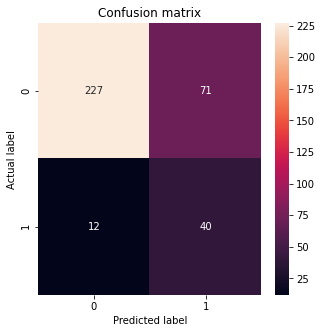

In [75]:
p = get_p(y_test_cb1, preds_cb1)
print('Optimal threshold:',p)
pred_y_thr = []
for i in range(len(y_test_cb1)):
    if  preds_cb1[i] > p: 
        pred_y_thr.append(1)
    else:
        pred_y_thr.append(0)
plot_cm(y_test_cb1, pred_y_thr)

In [77]:
print(classification_report(y_test_cb1,pred_y_thr))

              precision    recall  f1-score   support

           0       0.95      0.76      0.85       298
           1       0.36      0.77      0.49        52

    accuracy                           0.76       350
   macro avg       0.66      0.77      0.67       350
weighted avg       0.86      0.76      0.79       350



## keras

In [19]:
np.random.seed(1) # Fixed random seeds so that the result of each run was fixed
random.set_seed(1)

model = Sequential()
model.add(BatchNormalization(input_dim=20))  # Input layer and batch standardization 
 
model.add(Dense(25,  
                kernel_initializer='random_uniform',  
                activation='relu',                     
                kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),  # L1 and L2 regular terms
                use_bias=True))   # hidden layer
model.add(Dropout(0.1)) # dropout法
 
model.add(Dense(1,use_bias=True))  # output layer

In [15]:
def plot_cm(labels,y_pred):
    cm = confusion_matrix(labels,  y_pred)
    #auc_score = roc_auc_score(labels,predictions)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    #print(classification_report(labels,predictions > p))
    #print('AUC:',auc_score)
    return

In [16]:
def get_p(labels, predictions):
    best1 = 0
    p1 = 0
    for p in np.arange(0,1,0.001):
        auc_score = roc_auc_score(labels,predictions > p)
        if auc_score > best1:
            best1 = auc_score
            p1 = p
    return p1

###### Model compilation sets the learning target as (minimize) regression prediction loss mse, and the optimization algorithm is adam. The training set x and the training set label y are introduced to train the model using fit method, where epochs is the number of iteration and EarlyStopping is used to stop in time at the appropriate epoch, reducing overfitting. batch_size indicates the number of training samples randomly sampled each time the epoch

In [24]:
def dl_kears(train,test):
    model.compile(optimizer='adam', loss='mse')
    train_x,train_y = train.drop('CINV',axis = 1),train['CINV']
    oversample = SMOTE(random_state = 42,sampling_strategy = {1:200})
    train_x,train_y = oversample.fit_resample(train_x,train_y)
    test_x,test_y = test.drop('CINV',axis = 1),test['CINV']
    # training model
    history = model.fit(train_x, 
                        train_y, 
                        epochs=500,              # Number of training iterations
                        batch_size=36,           
                        validation_split=0.1,   # Split the verification set from the training set as a measure of early stop
                        callbacks=[EarlyStopping(monitor='val_loss', patience=20)],    #EarlyStopping
                        verbose=False)  # Non-output procedure  
 
    
    print("Verify the optimal result of the set：",min(history.history['val_loss']))
    pred_y = model.predict(test_x)[:,0]
    p = get_p(test_y, pred_y)
    print('Optimal threshold:',p)
    pred_y_thr = []
    for i in range(len(test_y)):
        if  pred_y[i] > p: 
            pred_y_thr.append(1)
        else:
            pred_y_thr.append(0)
    plot_cm(test_y, pred_y_thr)
    print(confusion_matrix(test_y, pred_y_thr))
    print(classification_report(test_y, pred_y_thr, digits=5))
    auc = roc_auc_score(test_y, pred_y)
    print(f'auc_score  is {auc}')
    return auc,model,train_x,test_x,pred_y,test_y

验证集最优结果： 0.2375766783952713
最佳阈值: 0.133
[[249  65]
 [ 13  24]]
              precision    recall  f1-score   support

           0    0.95038   0.79299   0.86458       314
           1    0.26966   0.64865   0.38095        37

    accuracy                        0.77778       351
   macro avg    0.61002   0.72082   0.62277       351
weighted avg    0.87863   0.77778   0.81360       351

auc_score  is 0.8027199173695989
save model
验证集最优结果： 0.2514500021934509
最佳阈值: 0.171
[[277  31]
 [ 24  18]]
              precision    recall  f1-score   support

           0    0.92027   0.89935   0.90969       308
           1    0.36735   0.42857   0.39560        42

    accuracy                        0.84286       350
   macro avg    0.64381   0.66396   0.65265       350
weighted avg    0.85392   0.84286   0.84800       350

auc_score  is 0.6919449598021028
验证集最优结果： 0.2411188930273056
最佳阈值: 0.108
[[221  87]
 [ 11  31]]
              precision    recall  f1-score   support

           0    0.95259  

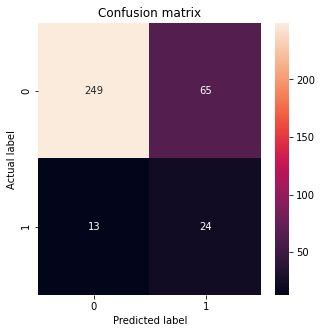

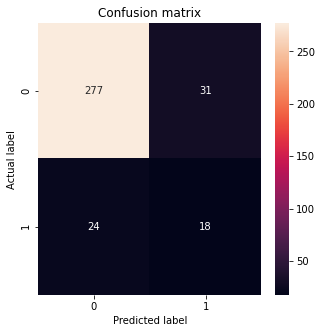

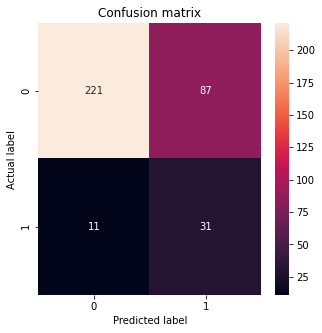

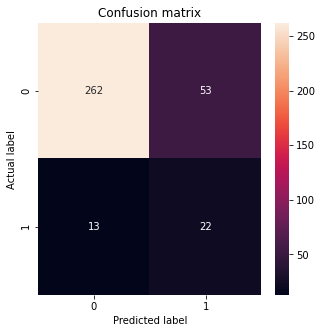

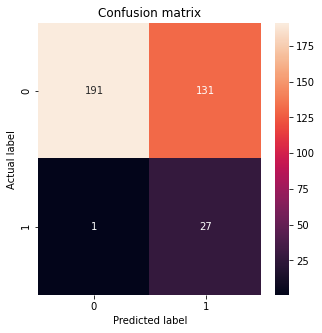

In [25]:
kf=KFold(n_splits=5,shuffle=True)
auc_t = 0
bestauc = 0.5
for train_index, test_index in kf.split(df):
    train = df.iloc[train_index,:]
    test = df.iloc[test_index,:]
    auc_score,model1,train_x1,test_x1,pred_y1 ,test_y1 = dl_kears(train,test)
    if auc_score > bestauc:
        bestauc = auc_score
        print('save model')
        model1.save('best_keras_model.h5') 
        best_train_x1,best_test_x1,best_pred_y1 ,best_test_y1 = train_x1,test_x1,pred_y1 ,test_y1
    to_best_model_choose1 = auc_score
    auc_t = auc_t + auc_score
print('AUC_ave:',auc_t/5)

In [26]:
best_test_x1.to_excel('keras_best_test_x1.xlsx',index = False)
best_train_x1.to_excel('keras_best_train_x1.xlsx',index = False)
best_test_y1.to_excel('keras_best_test_y1.xlsx',index = False)

In [27]:
#reading data
testx = pd.read_excel('keras_best_test_x1.xlsx')
testy = pd.read_excel('keras_best_test_y1.xlsx')

In [28]:
from tensorflow.keras.models import load_model  
model_keras = load_model('best_keras_model.h5')
predy = model_keras.predict(testx)[:,0]

In [29]:
roc_auc_score(testy,predy)

0.8339618456078084

###### catboost

In [38]:
from catboost import CatBoostRegressor
def cat_boost(train,test):
    other_params = {
        'iterations': 200,
        'learning_rate':0.06208212865044088,
        'l2_leaf_reg':9,
        'bagging_temperature':0.06877396513979309,
        'random_strength':2,
        'depth':5,
        'rsm':0.1991159881086658,
        'one_hot_max_size':9,
        'leaf_estimation_method':'Gradient',
        'fold_len_multiplier':6,
        'border_count':128,}
    model_cb = CatBoostRegressor(**other_params)
    x_train_cb , y_train_cb = train.drop('CINV',axis = 1),train['CINV']
    x_test_cb , y_test_cb = test.drop('CINV',axis = 1),test['CINV']
    model_cb.fit(x_train_cb, y_train_cb)    
    preds_cb = model_cb.predict(x_test_cb)
    auc_cb = roc_auc_score(y_test_cb,preds_cb)
    return auc_cb,model_cb,x_train_cb,x_test_cb,preds_cb,y_test_cb
kf=KFold(n_splits=5,shuffle=True)
auc_t = 0
bestauccb = 0.5
for train_index, test_index in kf.split(df):
    train = df.iloc[train_index,:]
    test = df.iloc[test_index,:]
    auc_cb,model_cb1,x_train_cb1,x_test_cb1,preds_cb1,y_test_cb1 = cat_boost(train,test)
    if auc_cb > bestauccb:
        bestauccb = auc_cb
        print('save model')
        #joblib.dump(filename='best_catboost_model.h5',value=model_cb1) 
        best_trainx1_cb,best_testx1_cb,best_predy1_cb ,best_testy1_cb = x_train_cb1,x_test_cb1,preds_cb1,y_test_cb1
    print(auc_cb)
    auc_t = auc_t + auc_cb
print('AUC_ave:',auc_t/5)

0:	learn: 0.3023361	total: 852us	remaining: 170ms
1:	learn: 0.3010933	total: 1.86ms	remaining: 184ms
2:	learn: 0.3001760	total: 2.94ms	remaining: 193ms
3:	learn: 0.2990197	total: 3.88ms	remaining: 190ms
4:	learn: 0.2981194	total: 4.95ms	remaining: 193ms
5:	learn: 0.2980240	total: 5.88ms	remaining: 190ms
6:	learn: 0.2968517	total: 6.95ms	remaining: 192ms
7:	learn: 0.2954593	total: 7.85ms	remaining: 188ms
8:	learn: 0.2946056	total: 8.88ms	remaining: 188ms
9:	learn: 0.2935287	total: 9.76ms	remaining: 186ms
10:	learn: 0.2925221	total: 10.8ms	remaining: 186ms
11:	learn: 0.2915657	total: 11.7ms	remaining: 183ms
12:	learn: 0.2907725	total: 12.6ms	remaining: 181ms
13:	learn: 0.2903055	total: 13.7ms	remaining: 182ms
14:	learn: 0.2894540	total: 14.9ms	remaining: 183ms
15:	learn: 0.2887067	total: 15.9ms	remaining: 183ms
16:	learn: 0.2880993	total: 16.9ms	remaining: 182ms
17:	learn: 0.2872115	total: 18.1ms	remaining: 183ms
18:	learn: 0.2868213	total: 19.4ms	remaining: 185ms
19:	learn: 0.2858809	to

178:	learn: 0.2373595	total: 171ms	remaining: 20ms
179:	learn: 0.2368561	total: 172ms	remaining: 19.1ms
180:	learn: 0.2362191	total: 173ms	remaining: 18.2ms
181:	learn: 0.2358929	total: 174ms	remaining: 17.2ms
182:	learn: 0.2356619	total: 175ms	remaining: 16.3ms
183:	learn: 0.2356054	total: 176ms	remaining: 15.3ms
184:	learn: 0.2352247	total: 177ms	remaining: 14.3ms
185:	learn: 0.2348309	total: 178ms	remaining: 13.4ms
186:	learn: 0.2347498	total: 179ms	remaining: 12.4ms
187:	learn: 0.2343611	total: 180ms	remaining: 11.5ms
188:	learn: 0.2342331	total: 181ms	remaining: 10.5ms
189:	learn: 0.2341803	total: 182ms	remaining: 9.57ms
190:	learn: 0.2339311	total: 183ms	remaining: 8.62ms
191:	learn: 0.2338849	total: 184ms	remaining: 7.66ms
192:	learn: 0.2333832	total: 185ms	remaining: 6.71ms
193:	learn: 0.2333102	total: 186ms	remaining: 5.75ms
194:	learn: 0.2331847	total: 187ms	remaining: 4.79ms
195:	learn: 0.2331150	total: 188ms	remaining: 3.83ms
196:	learn: 0.2329838	total: 189ms	remaining: 2.

74:	learn: 0.2617599	total: 72.6ms	remaining: 121ms
75:	learn: 0.2614887	total: 73.6ms	remaining: 120ms
76:	learn: 0.2610400	total: 74.5ms	remaining: 119ms
77:	learn: 0.2608870	total: 75.6ms	remaining: 118ms
78:	learn: 0.2605432	total: 76.5ms	remaining: 117ms
79:	learn: 0.2603507	total: 77.5ms	remaining: 116ms
80:	learn: 0.2600232	total: 78.4ms	remaining: 115ms
81:	learn: 0.2596934	total: 79.5ms	remaining: 114ms
82:	learn: 0.2594576	total: 80.3ms	remaining: 113ms
83:	learn: 0.2592249	total: 81.3ms	remaining: 112ms
84:	learn: 0.2585737	total: 82.2ms	remaining: 111ms
85:	learn: 0.2582248	total: 83.1ms	remaining: 110ms
86:	learn: 0.2579296	total: 84ms	remaining: 109ms
87:	learn: 0.2577833	total: 84.8ms	remaining: 108ms
88:	learn: 0.2576931	total: 85.6ms	remaining: 107ms
89:	learn: 0.2573529	total: 86.8ms	remaining: 106ms
90:	learn: 0.2571757	total: 87.6ms	remaining: 105ms
91:	learn: 0.2571124	total: 88.3ms	remaining: 104ms
92:	learn: 0.2569401	total: 89.3ms	remaining: 103ms
93:	learn: 0.2

170:	learn: 0.2485441	total: 167ms	remaining: 28.4ms
171:	learn: 0.2480153	total: 168ms	remaining: 27.4ms
172:	learn: 0.2478838	total: 169ms	remaining: 26.4ms
173:	learn: 0.2477905	total: 170ms	remaining: 25.4ms
174:	learn: 0.2474818	total: 171ms	remaining: 24.4ms
175:	learn: 0.2472219	total: 172ms	remaining: 23.4ms
176:	learn: 0.2468570	total: 173ms	remaining: 22.5ms
177:	learn: 0.2466445	total: 174ms	remaining: 21.5ms
178:	learn: 0.2463975	total: 175ms	remaining: 20.5ms
179:	learn: 0.2463750	total: 176ms	remaining: 19.5ms
180:	learn: 0.2459566	total: 177ms	remaining: 18.6ms
181:	learn: 0.2457103	total: 178ms	remaining: 17.6ms
182:	learn: 0.2455312	total: 179ms	remaining: 16.6ms
183:	learn: 0.2454230	total: 180ms	remaining: 15.6ms
184:	learn: 0.2453171	total: 181ms	remaining: 14.7ms
185:	learn: 0.2452921	total: 182ms	remaining: 13.7ms
186:	learn: 0.2451843	total: 183ms	remaining: 12.7ms
187:	learn: 0.2451067	total: 184ms	remaining: 11.7ms
188:	learn: 0.2450538	total: 185ms	remaining: 

In [39]:
best_testx1_cb.to_excel('best_testx1_cb.xlsx',index = False)
best_trainx1_cb.to_excel('best_trainx1_cb.xlsx',index = False)
best_testy1_cb.to_excel('best_testy1_cb.xlsx',index = False)

In [40]:
#reading data
testx = pd.read_excel('best_testx1_cb.xlsx')
testy = pd.read_excel('best_testy1_cb.xlsx')

In [41]:
modelcb = joblib.load(filename="best_catboost_model.h5")
predy = modelcb.predict(testx)

In [42]:
roc_auc_score(testy,predy)

0.838032786885246

In [145]:
#Hyperparameter selection
from sklearn.ensemble import RandomForestRegressor
def objective(trial):
    df = pd.read_excel('data_imputed.xlsx')
    for val in df.columns:
        if np.std(df[val],ddof=1) > 100:
            eps=0.001
            df[val] = np.log(df.pop(val)+eps)
    scaler = MinMaxScaler(feature_range=(0,1))
    for val in df.columns.drop('CINV'):
        df[val] = scaler.fit_transform(np.reshape(np.array(df[val]),(-1,1)))
    data = df.drop('CINV',axis = 1)
    target = df['CINV']
    X_train, X_test, y_train, y_test=train_test_split(data, target, test_size=0.2, random_state=42)# Data set partitioning
    
    param ={ 'n_estimators':trial.suggest_int('n_estimators', 50, 150), 
             'min_samples_split':trial.suggest_int('min_samples_split', 2, 9), 
             'min_samples_leaf':trial.suggest_int('min_samples_leaf', 1, 9), }

    
    cat=RandomForestRegressor(**param)
    cat.fit(X_train, y_train)
    pred_lgb=cat.predict(X_test)
    auc =roc_auc_score(y_test, pred_lgb)
    return auc

In [146]:
import optuna
study=optuna.create_study(direction='maximize')
n_trials=20
study.optimize(objective, n_trials=n_trials)

[I 2023-03-04 23:33:22,709] A new study created in memory with name: no-name-fd3688bb-0c2c-47a4-8f71-6c4abb16ce45
[I 2023-03-04 23:33:23,642] Trial 0 finished with value: 0.7613412228796845 and parameters: {'n_estimators': 58, 'min_samples_split': 2, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.7613412228796845.
[I 2023-03-04 23:33:24,812] Trial 1 finished with value: 0.7508629191321499 and parameters: {'n_estimators': 106, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.7613412228796845.
[I 2023-03-04 23:33:26,525] Trial 2 finished with value: 0.7645874424720579 and parameters: {'n_estimators': 144, 'min_samples_split': 3, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.7645874424720579.
[I 2023-03-04 23:33:27,719] Trial 3 finished with value: 0.762121959237344 and parameters: {'n_estimators': 88, 'min_samples_split': 4, 'min_samples_leaf': 5}. Best is trial 2 with value: 0.7645874424720579.
[I 2023-03-04 23:33:28,881] Trial 4 finished with

In [86]:
from optuna.visualization import plot_slice

plot_slice(study)

In [87]:
from optuna.visualization import plot_param_importances
plot_param_importances(study)

In [111]:
from optuna.visualization import plot_parallel_coordinate

plot_parallel_coordinate(study)

###### decision_tree

In [73]:
#Training data (decision tree)
from sklearn import tree
def decision_tree(train,test):
    x_train_dt , y_train_dt = train.drop('CINV',axis = 1),train['CINV']
    x_test_dt , y_test_dt = test.drop('CINV',axis = 1),test['CINV']
    param_dt = {'max_depth':5            
}
    model_dt = tree.DecisionTreeRegressor(**param_dt)
    model_dt.fit(x_train_dt, y_train_dt)
    preds_dt = model_dt.predict(x_test_dt)
    auc_dt = roc_auc_score(y_test_dt,preds_dt)
    return auc_dt,model_dt,x_train_dt,x_test_dt,preds_dt,y_test_dt

    
kf=KFold(n_splits=5,shuffle=True)
auc_t = 0
bestaucdt = 0.5
for train_index, test_index in kf.split(df):
    train = df.iloc[train_index,:]
    test = df.iloc[test_index,:]
    auc_dt1,model_dt1,x_train_dt1,x_test_dt1,preds_dt1,y_test_dt1 = decision_tree(train,test)
    if auc_dt1 > bestaucdt:
        bestaucdt = auc_dt1
        print('save model')
        #joblib.dump(filename='best_decisiontree_model.h5',value=model_dt1) 
        best_trainx1_dt,best_testx1_dt,best_predy1_dt ,best_testy1_dt = x_train_dt1,x_test_dt1,preds_dt1,y_test_dt1
    print(auc_dt1)
    auc_t = auc_t + auc_dt1
print('AUC_ave:',auc_t/5)

save model
0.7350529100529101
save model
0.7558072841984514
save model
0.7891805543562732
save model
0.7916099773242631
0.7250965835921521
AUC_ave: 0.75934946190481


最佳阈值: 0.14300000000000002


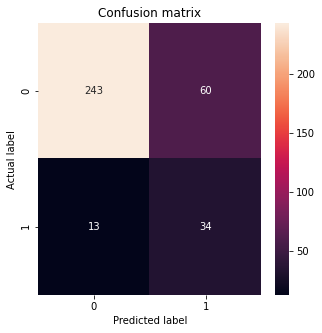

In [236]:
p= get_p(best_testy1_dt, best_predy1_dt)
print('Optimal threshold:',p)
pred_y_thr = []
for i in range(len(best_testy1_dt)):
    if  best_predy1_dt[i] > p: 
        pred_y_thr.append(1)
    else:
        pred_y_thr.append(0)
plot_cm(best_testy1_dt, pred_y_thr)

In [237]:
print(classification_report(best_testy1_dt, pred_y_thr, digits=5))

              precision    recall  f1-score   support

           0    0.94922   0.80198   0.86941       303
           1    0.36170   0.72340   0.48227        47

    accuracy                        0.79143       350
   macro avg    0.65546   0.76269   0.67584       350
weighted avg    0.87032   0.79143   0.81742       350



In [74]:
best_testx1_dt.to_excel('best_testx1_dt.xlsx',index = False)
best_trainx1_dt.to_excel('best_trainx1_dt.xlsx',index = False)
best_testy1_dt.to_excel('best_testy1_dt.xlsx',index = False)

In [75]:
# reading data
testx = pd.read_excel('best_testx1_dt.xlsx')
testy = pd.read_excel('best_testy1_dt.xlsx')

In [76]:
modeldt = joblib.load(filename="best_decisiontree_model.h5")
predy = modeldt.predict(testx)

In [77]:
roc_auc_score(testy,predy)

0.7916099773242631

# SVM

In [83]:
#Import Library
from sklearn import svm
def svm1(train,test):
    x_train_sv , y_train_sv = train.drop('CINV',axis = 1),train['CINV']
    x_test_sv , y_test_sv = test.drop('CINV',axis = 1),test['CINV']
    oversample = SMOTE(random_state = 42)
    x_train_sv,y_train_sv = oversample.fit_resample(x_train_sv,y_train_sv)
    model_sv = svm.SVR(kernel='linear', degree=3, gamma='scale', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True,
                          cache_size=200, verbose=False, max_iter=- 1)

    model_sv.fit(x_train_sv, y_train_sv)
    preds_sv = model_sv.predict(x_test_sv)
    auc_sv = roc_auc_score(y_test_sv,preds_sv)
    return auc_sv,model_sv,x_train_sv,x_test_sv,preds_sv,y_test_sv

    
kf=KFold(n_splits=5,shuffle=True)
auc_t = 0
bestaucsvm = 0.5
for train_index, test_index in kf.split(df):
    train = df.iloc[train_index,:]
    test = df.iloc[test_index,:]
    auc_sv1,model_sv1,x_train_sv1,x_test_sv1,preds_sv1,y_test_sv1 = svm1(train,test)
    if auc_sv1 > bestaucsvm:
        bestaucsvm = auc_sv1
        print('save model')
        joblib.dump(filename='best_SVM_model.h5',value=model_sv1) 
        best_trainx1_sv,best_testx1_sv,best_predy1_sv,best_testy1_sv = x_train_sv1,x_test_sv1,preds_sv1,y_test_sv1
    print(auc_sv1)
    auc_t = auc_t + auc_sv1
print('AUC_ave:',auc_t/5)

save model
0.7624338624338625
0.7180621069182389
save model
0.7862903225806451
save model
0.7902179911699779
0.745452528837622
AUC_ave: 0.7604913623880692


In [85]:
best_testx1_sv.to_excel('best_testx1_sv.xlsx',index = False)
best_trainx1_sv.to_excel('best_trainx1_sv.xlsx',index = False)
best_testy1_sv.to_excel('best_testy1_sv.xlsx',index = False)

In [86]:
# reading data
testx = pd.read_excel('best_testx1_sv.xlsx')
testy = pd.read_excel('best_testy1_sv.xlsx')

In [87]:
modelsvm = joblib.load(filename="best_SVM_model.h5")
predy = modelsvm.predict(testx)

In [88]:
roc_auc_score(testy,predy)

0.7902179911699779

###### RandomForest

In [90]:
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
def rf(train,test):
    x_train_rf , y_train_rf = train.drop('CINV',axis = 1),train['CINV']
    x_test_rf , y_test_rf = test.drop('CINV',axis = 1),test['CINV']
    oversample = SMOTE(random_state = 42,sampling_strategy = {1:200})
    x_train_rf,y_train_rf = oversample.fit_resample(x_train_rf,y_train_rf)
    
    model_rf = RandomForestRegressor(n_estimators=100, 
  criterion='mse', max_depth=None, 
  min_samples_split=2, min_samples_leaf=1, 
  min_weight_fraction_leaf=0.0, 
  max_features='auto', max_leaf_nodes=None, 
  min_impurity_decrease=0.0, 
  min_impurity_split=None, 
  bootstrap=True, oob_score=False, 
  n_jobs=None, random_state=None, 
  verbose=0, warm_start=False, 
  ccp_alpha=0.0, max_samples=None)

    model_rf.fit(x_train_rf, y_train_rf)
    preds_rf = model_rf.predict(x_test_rf)
    auc_rf = roc_auc_score(y_test_rf,preds_rf)
    return auc_rf,model_rf,x_train_rf,x_test_rf,preds_rf,y_test_rf

    
kf=KFold(n_splits=5,shuffle=True)
auc_t = 0
bestaucrf = 0.5
for train_index, test_index in kf.split(df):
    train = df.iloc[train_index,:]
    test = df.iloc[test_index,:]
    auc_rf1,model_rf1,x_train_rf1,x_test_rf1,preds_rf1,y_test_rf1 = rf(train,test)
    if auc_rf1 > bestaucrf:
        bestaucrf = auc_rf1
        print('save model')
        joblib.dump(filename='best_RandomForest_model.h5',value=model_rf1) 
        best_trainx1_rf,best_testx1_rf,best_predy1_rf,best_testy1_rf = x_train_rf1,x_test_rf1,preds_rf1,y_test_rf1
    print(auc_rf1)
    auc_t = auc_t + auc_rf1
print('AUC_ave:',auc_t/5)

save model
0.7989326906524359
0.7678239017125839
save model
0.8197113086702993
0.7576516018306637
0.7704765450483991
AUC_ave: 0.7829192095828763


In [91]:
best_testx1_rf.to_excel('best_testx1_rf.xlsx',index = False)
best_trainx1_rf.to_excel('best_trainx1_rf.xlsx',index = False)
best_testy1_rf.to_excel('best_testy1_rf.xlsx',index = False)

In [92]:
# reading data
testx = pd.read_excel('best_testx1_rf.xlsx')
testy = pd.read_excel('best_testy1_rf.xlsx')

In [93]:
modelrf = joblib.load(filename="best_RandomForest_model.h5")
predy = modelrf.predict(testx)

In [94]:
roc_auc_score(testy,predy)

0.8197113086702993